# Spatial Resilience - GI
ARIC 2020 - UNIVERSITY OF EXETER

In [1]:
import sys, os
import math 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import adjustText as aT

from shapely.geometry import Point, Polygon, LineString

import shapely.wkt
from matplotlib.colors import SymLogNorm

%matplotlib inline

from tqdm import tqdm

In [2]:
import sections as sec

df=sec.import_inputfile('Res_files/input_files/topsham_ag.inp')
inputer=sec.deteriminesections(df)

for index, row in inputer['subcatchments'].iterrows():
    inputer['subcatchments'].loc[index,'Name']=row['Name'].strip()

#Subcatchments info
subcat=pd.read_csv('Res_files/subcat_modified')
subcat.drop(columns=['Unnamed: 0'],inplace=True)

for index, row in subcat.iterrows():
    subcat.loc[index, 'geometry']=shapely.wkt.loads(row['geometry'])

subcat=gpd.GeoDataFrame(subcat, geometry='geometry',crs='EPSG:27700')

#Relationship between subcatchment and node
subcatinode=pd.read_csv('GRA_files/subcatinode')
subcatinode.set_index('Node',inplace=True)

subcatinode.drop(list(subcatinode[subcatinode['Name'].isin(['SX96884607_t','SX96885506_t','SX96884622_t','SX96884509_t','SX96884535_t'])].index),inplace=True)

subtonode=subcatinode.to_dict()
subtonode=subtonode['Name']


#Node info
nodes=pd.read_csv('GRA_files/nodes')
nodes.drop(columns='Unnamed: 0',inplace=True)

In [3]:
lonmin,latmin,lonmax,latmax = subcat.total_bounds

In [4]:
links=pd.read_csv('GRA_files/links')
for index, row in links.iterrows():
    links.loc[index, 'Point1']=shapely.wkt.loads(row['Point1'])
    links.loc[index, 'Point2']=shapely.wkt.loads(row['Point2'])
    links.loc[index, 'link']=shapely.wkt.loads(row['link'])
links=gpd.GeoDataFrame(links,geometry='link',crs='EPSG:27700')

### Change the storms input files & calculating the reference state

In [5]:
# import theinputerpy as inp
# import rainwally as wally

In [6]:
# theinputer=inp.import_inputfile('Res_files/input_files/topsham_ag.inp')

# arr=['M2_10','M2_30','M2_60','M10_10','M10_30','M10_60','M100_10','M100_30','M100_60']

# for i in arr:
#     rain=wally.givemetherain(i)
#     theinputermodified=inp.set_rainfall(theinputer,rain,ccf=1)
#     theinputermodified=inp.setraingage(theinputermodified,i)
#     inp.write_input(f'Res_files/input_files/Topsham{i}.inp',theinputermodified)

In [7]:
# from pyswmm import Simulation

In [8]:
# for i in arr:
#     sim=Simulation(f'Res_files/input_files/Topsham{i}.inp')
#     sim.execute()

In [9]:
# import res_aric2020 as resi

In [10]:
arr=['M2_10','M2_30','M2_60','M10_10','M10_30','M10_60','M100_10','M100_30','M100_60']

In [11]:
# storm='references'

# for j in tqdm(arr):
    
#     res=resi.resilienceindex_nodes_sys(f'input_files/Topsham{j}')
    
#     res_sys=pd.DataFrame()
#     res_sys=pd.DataFrame()
#     res_sys['simulation']=range(0,len(res))
#     res_sys['Res']=None
#     res_sys['Inflow']=None
#     res_sys['Flood']=None
#     res_sys['HoursFlooded']=None

#     res[0].to_csv(f'Res_files/{storm}/reference{j}')

#     res_sys.loc[res_sys['simulation']==i,'Res']=res[1][0]
#     res_sys.loc[res_sys['simulation']==i,'Inflow']=res[1][1]
#     res_sys.loc[res_sys['simulation']==i,'flood']=res[1][2]
#     res_sys.loc[res_sys['simulation']==i,'HoursFlooded']=res[1][3]

#     res_sys.to_csv(f'Res_files/{storm}/reference{j}_system')    

In [12]:
# ref={}
# for i in tqdm(arr):
#     ref[i]=pd.read_csv(f'Res_files/references/reference{i}')

## Results nodes 

In [13]:
noderesilience={}
for i in tqdm(arr):
    noderesilience[i]=pd.read_csv(f'Res_files/references/reference{i}')

100%|██████████| 9/9 [00:00<00:00, 301.64it/s]


In [14]:
route_geoms=pd.read_csv('Res_files/subcat_distance')
route_geoms.drop(columns=['Unnamed: 0','points'],inplace=True)
route_geoms.fillna(0, inplace=True)

L1=route_geoms.columns
L2=range(0,226)
rename={k:v for k,v in zip(L1,L2)}
route_geoms.rename(columns=rename,inplace=True)

In [15]:
res={}

for i in tqdm(arr):
    res[i]={}
    for j in tqdm(range(0,220)):
        res[i][j]=pd.read_csv(f'Res_files/{i}/simulation_500_{j}')
        res[i][j]['storm']=i
        res[i][j]['subcat']=j
        res[i][j]['geometry']=None
        for index, row in res[i][j].iterrows():
            res[i][j].loc[index, 'geometry']=Point(row['X'],row['Y'])
        res[i][j].drop(columns='points',inplace=True)
        res[i][j]['distance']=route_geoms[j]
        res[i][j]['dist_norm']=route_geoms[j]/route_geoms[j].mean()
        res[i][j]['DifFlood']=res[i][j]['Flood']-noderesilience[i]['Flood']
        res[i][j]['DifHF']=res[i][j]['HoursFlooded']-noderesilience[i]['HoursFlooded']
        res[i][j]['%Flood']=100*((res[i][j]['Flood']-noderesilience[i]['Flood'])/noderesilience[i]['Flood'])
        res[i][j]['%HF']=100*((res[i][j]['HoursFlooded']-noderesilience[i]['HoursFlooded'])/noderesilience[i]['HoursFlooded'])
    #     res[j].fillna(0,inplace=True)
        res[i][j].replace(to_replace=np.inf,value=0,inplace=True)
        res[i][j].replace(to_replace=np.nan,value=0,inplace=True)
        res[i][j]=gpd.GeoDataFrame(res[i][j],geometry='geometry',crs='EPSG:27700')

 70%|███████   | 155/220 [00:30<00:12,  5.32it/s]


 40%|████      | 89/220 [00:17<00:25,  5.09it/s]


 10%|█         | 22/220 [00:04<00:37,  5.28it/s]


 81%|████████  | 178/220 [00:34<00:08,  4.95it/s]


 51%|█████     | 112/220 [00:22<00:21,  4.96it/s]


 20%|██        | 45/220 [00:08<00:35,  4.87it/s]


 91%|█████████ | 200/220 [00:40<00:04,  4.73it/s]


 61%|██████    | 134/220 [00:27<00:17,  4.92it/s]


 31%|███       | 68/220 [00:13<00:28,  5.26it/s]


  0%|          | 1/220 [00:00<00:41,  5.22it/s]


 71%|███████▏  | 157/220 [00:29<00:11,  5.28it/s]


 41%|████▏     | 91/220 [00:17<00:24,  5.27it/s]


100%|██████████| 9/9 [06:28<00:00, 43.15s/it]


In [16]:
listi=[]
for i in tqdm(arr):
    for j in tqdm(range(0,220)):
        listi.append(res[i][j])
all_info=pd.concat(listi)
all_info.drop(columns=['Unnamed: 0'],inplace=True)

100%|██████████| 220/220 [00:00<00:00, 1517675.79it/s]

100%|██████████| 220/220 [00:00<00:00, 1426193.01it/s]

100%|██████████| 220/220 [00:00<00:00, 1495537.89it/s]

100%|██████████| 220/220 [00:00<00:00, 1507756.34it/s]

100%|██████████| 220/220 [00:00<00:00, 1537911.47it/s]

100%|██████████| 220/220 [00:00<00:00, 1476395.01it/s]

100%|██████████| 220/220 [00:00<00:00, 1530260.17it/s]

100%|██████████| 220/220 [00:00<00:00, 1428400.74it/s]

100%|██████████| 9/9 [00:00<00:00, 720.97it/s]


In [17]:
res_storm={}

for i in tqdm(arr):
    listi=[]
    for j in tqdm(range(0,220)):
        listi.append(res[i][j])
    
    info=pd.concat(listi)
    info.drop(columns=['Unnamed: 0'],inplace=True)
    res_storm[i]=info

100%|██████████| 9/9 [00:01<00:00,  6.62it/s]


### Location

[(-20.0, 20.0),
 Text(0, 0.5, '%FVC'),
 (0.0, 2.0),
 Text(0.5, 0, 'Normalized Distance')]

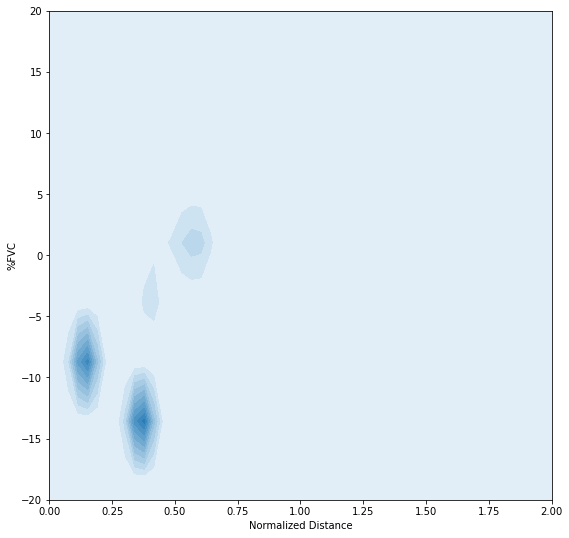

In [18]:
fig,ax = plt.subplots(figsize=(9,9))

sns.kdeplot(all_info[all_info['Flood']>15]['dist_norm'],all_info[all_info['Flood']>15]['%Flood'],cut=2, shade=True, ax=ax)

ax.set(xlim=(0,2.0),ylim=(-20,20),xlabel='Normalized Distance', ylabel='%FVC')

[(-20.0, 20.0), Text(0, 0.5, '%FDC'), Text(0.5, 0, 'Distance Normalized')]

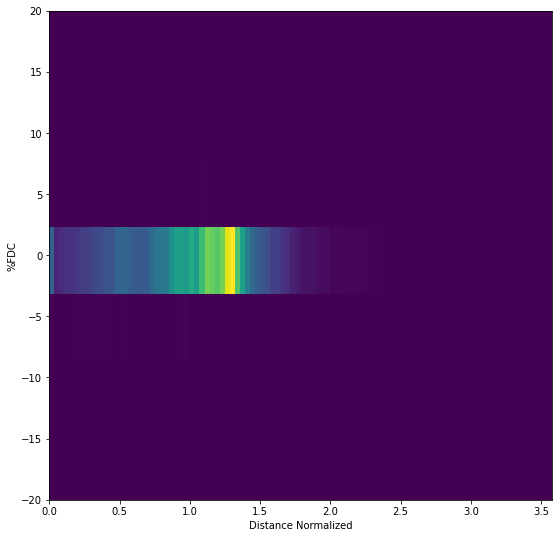

In [19]:
fig,ax = plt.subplots(figsize=(9,9))

ax.hist2d(x=all_info[all_info['Flood']>15]['dist_norm'],y=all_info[all_info['Flood']>15]['%HF'],bins=100)

ax.set(ylim=(-20,20),xlabel='Distance Normalized', ylabel='%FDC')

In [20]:
from scipy.stats import gaussian_kde

[(-70.0, 70.0), Text(0, 0.5, '%FDC'), Text(0.5, 0, 'Distance Normalized')]

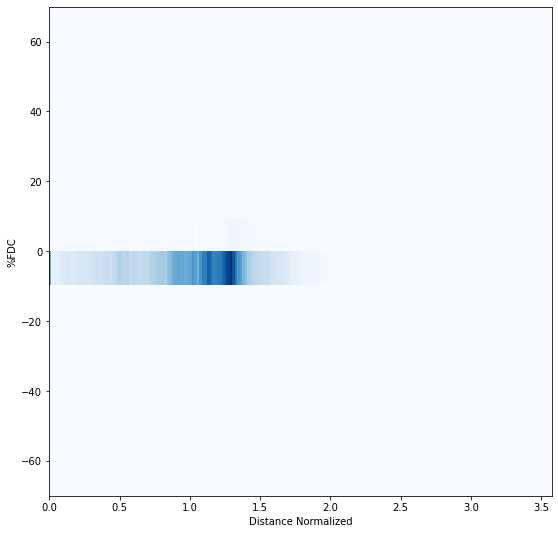

In [21]:
fig,ax = plt.subplots(figsize=(9,9))

ax.hist2d(all_info[all_info['Flood']>15]['dist_norm'],all_info[all_info['Flood']>15]['%Flood'], (200,50), cmap='Blues')

ax.set(ylim=(-70,70),xlabel='Distance Normalized', ylabel='%FDC')

In [22]:
# sns.lmplot(x='distance', y='DifFlood', col='storm', col_wrap=3, height=3,data=all_info[all_info['DifFlood']<0])

In [23]:
# sns.lmplot(x='distance', y='DifHF', col='storm', col_wrap=3, height=3,data=all_info)

In [24]:
# import matplotlib.colors as mcolors

In [25]:
# # Set up the matplotlib figure
# f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True)

# i=0

# # Rotate the starting point around the cubehelix hue circle
# for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

#     # Create a cubehelix colormap to use with kdeplot
#     cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

#     # Generate and plot a random bivariate dataset
#     x=res_storm[arr[i]][res_storm[arr[i]]['DifHF']!=0]['distance']
#     y=res_storm[arr[i]][res_storm[arr[i]]['DifHF']!=0]['DifHF']
    
#     ax.hist2d(x, y,density=True,bins=100,  norm=mcolors.PowerNorm(0.3))
    
#     i=i+1

# f.tight_layout()

### Magnitude

### SYSTEM

In [32]:
res_sys=pd.DataFrame()
for i in arr:
    res_sys_a=pd.read_csv(f'Res_files/references/reference{i}_system')
    res_sys_a['storm']=i
    res_sys_a.drop(1,inplace=True)
    res_sys=pd.concat([res_sys,res_sys_a])

In [33]:
res_sys.drop(columns=['Flood','Unnamed: 0'],inplace=True)

In [34]:
res_sys.reset_index(drop=True, inplace=True)

In [35]:
arr

['M2_10',
 'M2_30',
 'M2_60',
 'M10_10',
 'M10_30',
 'M10_60',
 'M100_10',
 'M100_30',
 'M100_60']

In [41]:
res_sys_gi=pd.DataFrame()

In [42]:
for i in arr: 
    res_sys_a=pd.read_csv(f'Res_files/{i}/simulation_500_system')
    res_sys_a['storm']=i
    res_sys_gi=pd.concat([res_sys_gi,res_sys_a])

In [43]:
res_sys_gi.drop(columns=['Flood','Unnamed: 0'],inplace=True)

In [44]:
res_sys_gi.reset_index(drop=True, inplace=True)

In [45]:
for index, row in res_sys_gi.iterrows():
    res_sys_gi.loc[index,'dif_flood']=(row['flood']-res_sys.loc[res_sys['storm']==row['storm'],'flood'].values[0])
    res_sys_gi.loc[index,'dif_hf']=(row['HoursFlooded']-res_sys.loc[res_sys['storm']==row['storm'],'HoursFlooded'].values[0])
    res_sys_gi.loc[index,'dif_flood_%']=100*((row['flood']-res_sys.loc[res_sys['storm']==row['storm'],'flood'].values[0])/res_sys.loc[res_sys['storm']==row['storm'],'flood'].values[0])
    res_sys_gi.loc[index,'dif_hf_%']=100*((row['HoursFlooded']-res_sys.loc[res_sys['storm']==row['storm'],'HoursFlooded'].values[0])/res_sys.loc[res_sys['storm']==row['storm'],'HoursFlooded'].values[0])

In [46]:
res_sys_gi.groupby(by='storm').mean()

simulation       Res         Inflow  HoursFlooded          flood  \
storm                                                                       
M100_10       109.5  0.993559  175874.233628      0.388303  140037.316441   
M100_30       109.5  0.989308  286884.322256      0.597857  246270.038301   
M100_60       109.5  0.983889  342296.862566      0.889674  297524.386404   
M10_10        109.5  0.995169  108968.413571      0.331043   76337.307138   
M10_30        109.5  0.990715  174707.949086      0.567399  137225.903978   
M10_60        109.5  0.986753  206782.366113      0.796561  165064.559429   
M2_10         109.5  0.996524   68459.931633      0.288030   39656.035177   
M2_30         109.5  0.993215  110610.435627      0.471824   76354.249793   
M2_60         109.5  0.990051  133021.960643      0.672045   94521.896268   

          dif_flood    dif_hf  dif_flood_%  dif_hf_%  
storm                                                 
M100_10 -109.458396 -0.000093    -0.078103 -0.023928  
M100_30 -148.043790 -0.000281    -0.060078 -0.046931  
M100_60 -170.648843 -0.000270    -0.057323 -0.030337  
M10_10   -38.154291 -0.000068    -0.049956 -0.020565  
M10_30  -140.102795 -0.000178    -0.101992 -0.031431  
M10_60    -6.115319 -0.000219    -0.003705 -0.027531  
M2_10    -14.542236 -0.000105    -0.036657 -0.036483  
M2_30    -71.286565 -0.000084    -0.093276 -0.017902  
M2_60    -44.898396  0.000265    -0.047478  0.039455

NameError: name 'mean_res_gi' is not defined

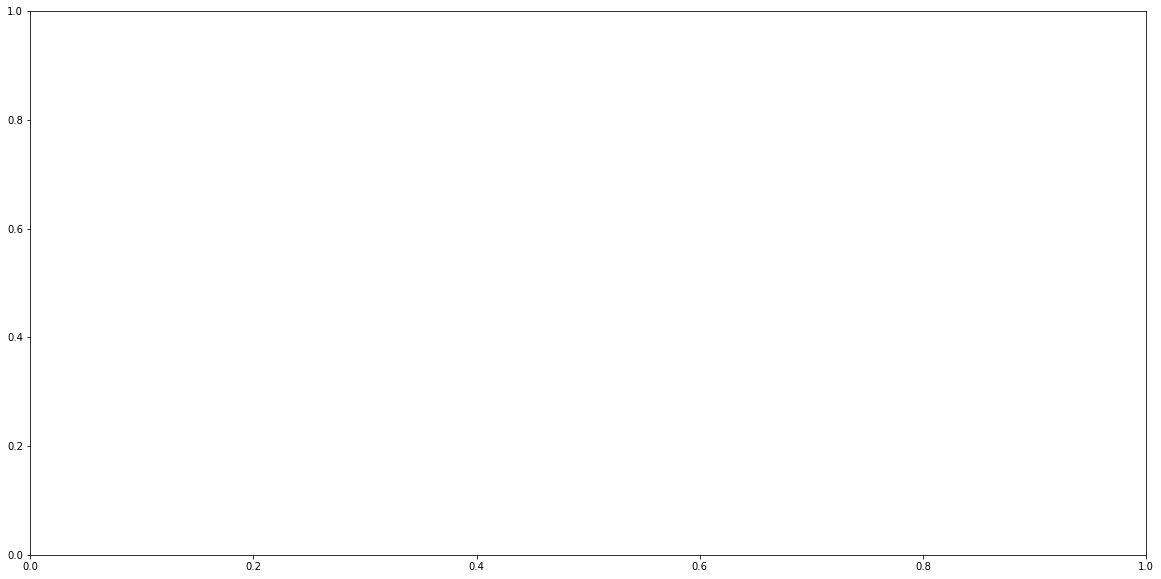

In [47]:
fig, ax =plt.subplots(figsize=(20,10))

ax.bar(x=res_sys['storm'],height=100*(mean_res_gi['dif_max']/res_sys['flood']))
ax.bar(x=res_sys['storm'],height=100*(mean_res_gi['dif_min']/res_sys['flood']))
ax.bar(x=res_sys['storm'],height=100*(mean_res_gi['dif_mean']/res_sys['flood']))
ax.tick_params(axis="x", labelsize=8, rotation=70)

ax.set_xlabel('Storms')
ax.set_ylabel('% diference total flood')

ax.legend(['Max','Min','Mean'])

In [ ]:
fig, ax =plt.subplots(figsize=(20,10))

ax.bar(x=res_sys['storm'],height=100*(mean_res_gi['dif_max']/res_sys['flood']))
ax.bar(x=res_sys['storm'],height=100*(mean_res_gi['dif_min']/res_sys['flood']))
ax.bar(x=res_sys['storm'],height=100*(mean_res_gi['dif_mean']/res_sys['flood']))
ax.tick_params(axis="x", labelsize=8, rotation=70)

ax.set_xlabel('Storms')
ax.set_ylabel('% diference total flood')

ax.legend(['Max','Min','Mean'])

In [50]:
mean_res_gi=res_sys_gi.groupby(by='storm').mean()

In [51]:
mean_res_gi.reset_index(inplace=True)

In [52]:
mean_res_gi['min_flood']=res_sys_gi.groupby(by='storm').min()['flood'].values
mean_res_gi['min_hf']=res_sys_gi.groupby(by='storm').min()['HoursFlooded'].values

In [53]:
mean_res_gi['max_flood']=res_sys_gi.groupby(by='storm').max()['flood'].values
mean_res_gi['max_hf']=res_sys_gi.groupby(by='storm').max()['HoursFlooded'].values

In [54]:
for index, row in mean_res_gi.iterrows():
    mean_res_gi.loc[index,'dif_mean']=row['flood']-res_sys.loc[res_sys['storm']==row['storm'],'flood'].values[0]
    mean_res_gi.loc[index,'dif_min']=row['min_flood']-res_sys.loc[res_sys['storm']==row['storm'],['flood']].values[0]
    mean_res_gi.loc[index,'dif_max']=row['max_flood']-res_sys.loc[res_sys['storm']==row['storm'],['flood']].values[0]
    
    mean_res_gi.loc[index,'dif_mean_hf']=row['HoursFlooded']-res_sys.loc[res_sys['storm']==row['storm'],'HoursFlooded'].values[0]
    mean_res_gi.loc[index,'dif_min_hf']=row['min_hf']-res_sys.loc[res_sys['storm']==row['storm'],'HoursFlooded'].values[0]
    mean_res_gi.loc[index,'dif_max_hf']=row['max_hf']-res_sys.loc[res_sys['storm']==row['storm'],'HoursFlooded'].values[0]

In [55]:
mean_res_gi=mean_res_gi.reindex([6,7,8,3,4,5,0,1,2])

In [56]:
mean_res_gi.reset_index(drop=True,inplace=True)

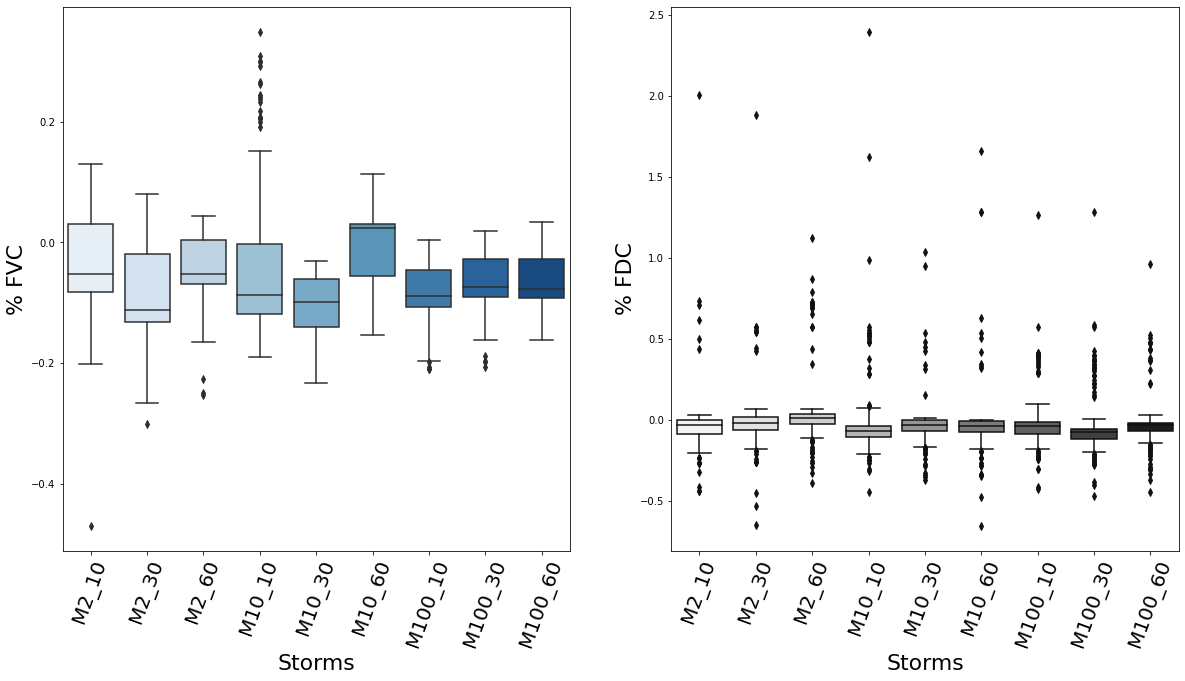

In [57]:
fig, ax =plt.subplots(1,2, figsize=(20,10))

sns.boxplot(x='storm',y='dif_flood_%',data=res_sys_gi,palette='Blues', ax=ax[0])
ax[0].set_xlabel('Storms',fontsize=22)
ax[0].set_ylabel('% FVC',fontsize=22)
ax[0].tick_params(axis="x", labelsize=20, rotation=70)


sns.boxplot(x='storm',y='dif_hf_%',data=res_sys_gi,palette='Greys', ax=ax[1])
ax[1].set_xlabel('Storms',fontsize=22)
ax[1].set_ylabel('% FDC',fontsize=22)
ax[1].tick_params(axis="x", labelsize=20, rotation=70)


# sns.boxplot(x='storm',y='DifFlood',data=all_info,palette='Blues', ax=ax[1,0])
# ax[1,0].set_xlabel('Storms',fontsize=15)
# ax[1,0].set_ylabel('% difference total flood volume',fontsize=15)
# ax[1,0].tick_params(axis="x", labelsize=8, rotation=70)


# sns.boxplot(x='storm',y='DifHF',data=all_info,palette='Greys', ax=ax[1,1])
# ax[1,1].set_xlabel('Storms',fontsize=15)
# ax[1,1].set_ylabel('% difference flood duration',fontsize=15)
# ax[1,1].tick_params(axis="x", labelsize=10, rotation=70)

In [ ]:
floodi_sys=res_sys_gi.groupby('storm')['dif_flood_%'].describe()
floodi_sys=floodi_sys.reindex(arr)
floodi_sys.reset_index(inplace=True)

In [ ]:
hfi_sys=res_sys_gi.groupby('storm')['dif_hf_%'].describe()
hfi_sys=hfi_sys.reindex(arr)
hfi_sys.reset_index(inplace=True)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

sns.barplot(ax=ax[0], x='storm',y='max',data=floodi_sys,palette='Blues')
sns.barplot(ax=ax[0], x='storm',y='min',data=floodi_sys,palette='Blues')
sns.barplot(ax=ax[0], x='storm',y='mean',data=floodi_sys,color='black',linewidth=1, facecolor=(1, 0, 1, 0),edgecolor='0.1')



ax[0].set_ylabel('% Flood Volume Change',fontsize=15)
ax[0].set_xlabel('Storms',fontsize=15)
ax[0].tick_params(axis="x", labelsize=12, rotation=70)



sns.barplot(ax=ax[1], x='storm',y='max',data=hfi_sys,palette='Greys')
sns.barplot(ax=ax[1], x='storm',y='min',data=hfi_sys,palette='Greys')

ax[1].scatter(hfi_sys['storm'],hfi_sys['mean'],color='blue',s=30,zorder=2)

ax[1].set_ylabel('% Flood Duration Change',fontsize=15)
ax[1].set_xlabel('Storms',fontsize=15)
ax[1].tick_params(axis="x", labelsize=12, rotation=70)

fig.tight_layout()

### LOCAL EFFECTS

In [102]:
res['M2_10'][0]

Unnamed: 0                Name         X        Y  TInflowVolume  Flood  \
0             0    CSO_FolletRoad#1  296438.0  88265.0   13832.364396    0.0   
1             1    CSO_FolletRoad#2  296437.5  88265.4       0.000000    0.0   
2             2          SX94899201  294973.0  89273.0   28854.000000    0.0   
3             3          SX95887720  295786.0  88755.0    1049.530965    0.0   
4             4          SX95887721  295751.0  88780.0    1049.516898    0.0   
..          ...                 ...       ...      ...            ...    ...   
482         482          SX96882104  296232.0  88143.0    1818.742394    0.0   
483         483          SX96882105  296229.0  88145.0       0.000000    0.0   
484         484          SX94899203  294967.7  89275.1   29020.166887    0.0   
485         485       SPS_FerryRoad  296271.0  88226.0   36135.045050    0.0   
486         486  SPS_FerryRoadStorm  296271.2  88223.4    6889.687182    0.0   

     HoursFlooded  Res  storm  subcat                      geometry  \
0             0.0  1.0  M2_10       0  POINT (296438.000 88265.000)   
1             0.0  1.0  M2_10       0  POINT (296437.500 88265.400)   
2             0.0  1.0  M2_10       0  POINT (294973.000 89273.000)   
3             0.0  1.0  M2_10       0  POINT (295786.000 88755.000)   
4             0.0  1.0  M2_10       0  POINT (295751.000 88780.000)   
..            ...  ...    ...     ...                           ...   
482           0.0  1.0  M2_10       0  POINT (296232.000 88143.000)   
483           0.0  1.0  M2_10       0  POINT (296229.000 88145.000)   
484           0.0  1.0  M2_10       0  POINT (294967.700 89275.100)   
485           0.0  1.0  M2_10       0  POINT (296271.000 88226.000)   
486           0.0  1.0  M2_10       0  POINT (296271.200 88223.400)   

        distance  dist_norm  DifFlood  DifHF  %Flood  %HF  
0    1066.913583   0.810661       0.0    0.0     0.0  0.0  
1    1060.510459   0.805796       0.0    0.0     0.0  0.0  
2       0.000000   0.000000       0.0    0.0     0.0  0.0  
3       0.000000   0.000000       0.0    0.0     0.0  0.0  
4    2460.531814   1.869559       0.0    0.0     0.0  0.0  
..           ...        ...       ...    ...     ...  ...  
482  2193.758837   1.666860       0.0    0.0     0.0  0.0  
483  2238.669861   1.700984       0.0    0.0     0.0  0.0  
484  2252.811996   1.711730       0.0    0.0     0.0  0.0  
485  2202.647169   1.673614       0.0    0.0     0.0  0.0  
486     0.000000   0.000000       0.0    0.0     0.0  0.0  

[487 rows x 17 columns]

In [58]:
flood={}
for i in tqdm(arr):
    flood[i]=pd.DataFrame()
    flood[i]['Name']=res[i][j]['Name']
    for j in tqdm(range(0,220)):
        flood[i][j]=None
        for ind,row in tqdm(res[i][j].iterrows()):
            if noderesilience[i][noderesilience[i].index==ind]['Flood'].values[0]>15:
                flood[i].loc[ind,j]=100*((row['Flood']-noderesilience[i][noderesilience[i].index==ind]['Flood'].values[0])/noderesilience[i][noderesilience[i].index==ind]['Flood'].values[0])
            else:
                flood[i].loc[ind,j]=0
    flood[i].replace(to_replace=np.inf,value=0,inplace=True)
    flood[i].replace(to_replace=np.nan,value=0,inplace=True)

  0%|          | 0/220 [00:00<?, ?it/s]

0it [00:00, ?it/s]

135it [00:00, 1348.19it/s]

290it [00:00, 1402.10it/s]

487it [00:00, 1449.40it/s]

  0%|          | 1/220 [00:00<01:14,  2.96it/s]

0it [00:00, ?it/s]

156it [00:00, 1555.30it/s]

321it [00:00, 1580.14it/s]

487it [00:00, 1522.80it/s]

  1%|          | 2/220 [00:00<01:12,  3.00it/s]

0it [00:00, ?it/s]

162it [00:00, 1617.64it/s]

330it [00:00, 1631.61it/s]

487it [00:00, 1554.62it/s]

  1%|▏         | 3/220 [00:00<01:11,  3.04it/s]

0it [00:00, ?it/s]

158it [00:00, 1562.10it/s]

318it [00:00, 1572.95it/s]

487it [00:00, 1512.61it/s]

  2%|▏         | 4/220 [00:01<01:10,  3.05it/s]

0it [00:00, ?it/s]

159it [00:00, 1583.27it/s]

326it [00:00, 1606.41it/s]

487it [00:00, 1547.73it/s]

  2%|▏         | 5/220 [00:01<01:09,  3.08it/s]

0it [00:00, ?it/s]

158it [00:00, 1575.18it/s]

323it [00:00, 1595.17it/s]

487it [00:00, 1538.30it/s]

  3%|▎         | 6/220 [00:01<01:09,  3.09it/s]

0it [00:00, ?it/s]

155it [00:00, 1545.84

 20%|██        | 45/220 [00:14<00:55,  3.14it/s]

0it [00:00, ?it/s]

160it [00:00, 1593.01it/s]

324it [00:00, 1604.12it/s]

487it [00:00, 1530.88it/s]

 21%|██        | 46/220 [00:14<00:55,  3.13it/s]

0it [00:00, ?it/s]

161it [00:00, 1602.12it/s]

329it [00:00, 1620.13it/s]

487it [00:00, 1567.05it/s]

 21%|██▏       | 47/220 [00:15<00:55,  3.14it/s]

0it [00:00, ?it/s]

158it [00:00, 1575.90it/s]

324it [00:00, 1597.77it/s]

487it [00:00, 1535.45it/s]

 22%|██▏       | 48/220 [00:15<00:54,  3.14it/s]

0it [00:00, ?it/s]

158it [00:00, 1575.04it/s]

324it [00:00, 1598.83it/s]

487it [00:00, 1541.91it/s]

 22%|██▏       | 49/220 [00:15<00:54,  3.14it/s]

0it [00:00, ?it/s]

159it [00:00, 1576.63it/s]

326it [00:00, 1598.95it/s]

487it [00:00, 1543.28it/s]

 23%|██▎       | 50/220 [00:16<00:54,  3.13it/s]

0it [00:00, ?it/s]

159it [00:00, 1572.50it/s]

325it [00:00, 1597.10it/s]

487it [00:00, 1539.10it/s]

 23%|██▎       | 51/220 [00:16<00:53,  3.13it/s]

0it [00:00, ?it/s]

161it 

 41%|████      | 90/220 [00:29<00:44,  2.90it/s]

0it [00:00, ?it/s]

154it [00:00, 1530.69it/s]

311it [00:00, 1540.53it/s]

487it [00:00, 1492.74it/s]

 41%|████▏     | 91/220 [00:29<00:43,  2.94it/s]

0it [00:00, ?it/s]

160it [00:00, 1593.58it/s]

324it [00:00, 1606.68it/s]

487it [00:00, 1520.74it/s]

 42%|████▏     | 92/220 [00:30<00:42,  2.98it/s]

0it [00:00, ?it/s]

155it [00:00, 1547.48it/s]

312it [00:00, 1554.11it/s]

487it [00:00, 1456.21it/s]

 42%|████▏     | 93/220 [00:30<00:42,  2.98it/s]

0it [00:00, ?it/s]

147it [00:00, 1468.36it/s]

301it [00:00, 1487.10it/s]

487it [00:00, 1412.21it/s]

 43%|████▎     | 94/220 [00:30<00:42,  2.94it/s]

0it [00:00, ?it/s]

150it [00:00, 1497.73it/s]

300it [00:00, 1496.69it/s]

487it [00:00, 1409.73it/s]

 43%|████▎     | 95/220 [00:31<00:42,  2.92it/s]

0it [00:00, ?it/s]

145it [00:00, 1448.19it/s]

296it [00:00, 1465.98it/s]

487it [00:00, 1412.71it/s]

 44%|████▎     | 96/220 [00:31<00:42,  2.91it/s]

0it [00:00, ?it/s]

146it 

 61%|██████▏   | 135/220 [00:44<00:27,  3.05it/s]

0it [00:00, ?it/s]

157it [00:00, 1566.87it/s]

321it [00:00, 1587.91it/s]

487it [00:00, 1515.49it/s]

 62%|██████▏   | 136/220 [00:44<00:27,  3.06it/s]

0it [00:00, ?it/s]

157it [00:00, 1565.96it/s]

324it [00:00, 1594.08it/s]

487it [00:00, 1523.41it/s]

 62%|██████▏   | 137/220 [00:45<00:27,  3.07it/s]

0it [00:00, ?it/s]

157it [00:00, 1563.51it/s]

322it [00:00, 1586.48it/s]

487it [00:00, 1509.59it/s]

 63%|██████▎   | 138/220 [00:45<00:26,  3.07it/s]

0it [00:00, ?it/s]

153it [00:00, 1528.24it/s]

309it [00:00, 1535.32it/s]

487it [00:00, 1501.22it/s]

 63%|██████▎   | 139/220 [00:45<00:26,  3.06it/s]

0it [00:00, ?it/s]

156it [00:00, 1556.61it/s]

325it [00:00, 1593.00it/s]

487it [00:00, 1526.81it/s]

 64%|██████▎   | 140/220 [00:46<00:26,  3.07it/s]

0it [00:00, ?it/s]

155it [00:00, 1545.02it/s]

314it [00:00, 1557.59it/s]

487it [00:00, 1493.98it/s]

 64%|██████▍   | 141/220 [00:46<00:25,  3.06it/s]

0it [00:00, ?it/s]


 82%|████████▏ | 180/220 [00:59<00:13,  3.04it/s]

0it [00:00, ?it/s]

155it [00:00, 1548.30it/s]

317it [00:00, 1568.13it/s]

487it [00:00, 1507.69it/s]

 82%|████████▏ | 181/220 [00:59<00:12,  3.05it/s]

0it [00:00, ?it/s]

149it [00:00, 1487.80it/s]

309it [00:00, 1517.66it/s]

487it [00:00, 1485.63it/s]

 83%|████████▎ | 182/220 [00:59<00:12,  3.04it/s]

0it [00:00, ?it/s]

156it [00:00, 1554.94it/s]

314it [00:00, 1560.53it/s]

487it [00:00, 1503.64it/s]

 83%|████████▎ | 183/220 [01:00<00:12,  3.04it/s]

0it [00:00, ?it/s]

141it [00:00, 1405.45it/s]

290it [00:00, 1429.35it/s]

487it [00:00, 1426.17it/s]

 84%|████████▎ | 184/220 [01:00<00:12,  3.00it/s]

0it [00:00, ?it/s]

157it [00:00, 1565.01it/s]

318it [00:00, 1577.29it/s]

487it [00:00, 1508.04it/s]

 84%|████████▍ | 185/220 [01:00<00:11,  3.02it/s]

0it [00:00, ?it/s]

158it [00:00, 1565.69it/s]

324it [00:00, 1590.77it/s]

487it [00:00, 1518.93it/s]

 85%|████████▍ | 186/220 [01:01<00:11,  3.04it/s]

0it [00:00, ?it/s]


159it [00:00, 1586.21it/s]

323it [00:00, 1600.87it/s]

487it [00:00, 1501.63it/s]

  2%|▏         | 5/220 [00:01<01:10,  3.06it/s]

0it [00:00, ?it/s]

156it [00:00, 1557.14it/s]

317it [00:00, 1570.87it/s]

487it [00:00, 1491.27it/s]

  3%|▎         | 6/220 [00:01<01:10,  3.05it/s]

0it [00:00, ?it/s]

158it [00:00, 1564.76it/s]

324it [00:00, 1587.21it/s]

487it [00:00, 1501.60it/s]

  3%|▎         | 7/220 [00:02<01:09,  3.05it/s]

0it [00:00, ?it/s]

156it [00:00, 1557.32it/s]

320it [00:00, 1579.12it/s]

487it [00:00, 1497.84it/s]

  4%|▎         | 8/220 [00:02<01:09,  3.05it/s]

0it [00:00, ?it/s]

158it [00:00, 1574.95it/s]

323it [00:00, 1596.13it/s]

487it [00:00, 1514.96it/s]

  4%|▍         | 9/220 [00:02<01:09,  3.06it/s]

0it [00:00, ?it/s]

158it [00:00, 1573.43it/s]

322it [00:00, 1591.91it/s]

487it [00:00, 1486.08it/s]

  5%|▍         | 10/220 [00:03<01:08,  3.04it/s]

0it [00:00, ?it/s]

156it [00:00, 1552.22it/s]

321it [00:00, 1579.11it/s]

487it [00:00, 1505.36it/s

315it [00:00, 1564.07it/s]

487it [00:00, 1260.51it/s]

 23%|██▎       | 50/220 [00:16<00:59,  2.86it/s]

0it [00:00, ?it/s]

157it [00:00, 1562.75it/s]

316it [00:00, 1568.59it/s]

487it [00:00, 1487.93it/s]

 23%|██▎       | 51/220 [00:16<00:58,  2.91it/s]

0it [00:00, ?it/s]

154it [00:00, 1529.33it/s]

314it [00:00, 1548.55it/s]

487it [00:00, 1469.04it/s]

 24%|██▎       | 52/220 [00:17<00:57,  2.93it/s]

0it [00:00, ?it/s]

153it [00:00, 1524.68it/s]

313it [00:00, 1544.50it/s]

487it [00:00, 1469.76it/s]

 24%|██▍       | 53/220 [00:17<00:56,  2.95it/s]

0it [00:00, ?it/s]

158it [00:00, 1578.44it/s]

311it [00:00, 1562.64it/s]

487it [00:00, 1477.47it/s]

 25%|██▍       | 54/220 [00:17<00:56,  2.96it/s]

0it [00:00, ?it/s]

148it [00:00, 1477.06it/s]

303it [00:00, 1496.15it/s]

487it [00:00, 1431.90it/s]

 25%|██▌       | 55/220 [00:18<00:56,  2.94it/s]

0it [00:00, ?it/s]

153it [00:00, 1525.08it/s]

304it [00:00, 1519.02it/s]

487it [00:00, 1414.15it/s]

 25%|██▌       | 56/

487it [00:00, 1480.47it/s]

 43%|████▎     | 95/220 [00:31<00:42,  2.96it/s]

0it [00:00, ?it/s]

158it [00:00, 1572.01it/s]

319it [00:00, 1581.24it/s]

487it [00:00, 1487.91it/s]

 44%|████▎     | 96/220 [00:32<00:41,  2.98it/s]

0it [00:00, ?it/s]

154it [00:00, 1530.71it/s]

314it [00:00, 1549.61it/s]

487it [00:00, 1467.84it/s]

 44%|████▍     | 97/220 [00:32<00:41,  2.98it/s]

0it [00:00, ?it/s]

158it [00:00, 1568.72it/s]

319it [00:00, 1580.19it/s]

487it [00:00, 1497.35it/s]

 45%|████▍     | 98/220 [00:32<00:40,  3.00it/s]

0it [00:00, ?it/s]

153it [00:00, 1529.26it/s]

318it [00:00, 1561.42it/s]

487it [00:00, 1491.65it/s]

 45%|████▌     | 99/220 [00:33<00:40,  3.01it/s]

0it [00:00, ?it/s]

156it [00:00, 1557.43it/s]

316it [00:00, 1568.16it/s]

487it [00:00, 1488.75it/s]

 45%|████▌     | 100/220 [00:33<00:39,  3.01it/s]

0it [00:00, ?it/s]

153it [00:00, 1527.19it/s]

316it [00:00, 1554.55it/s]

487it [00:00, 1478.49it/s]

 46%|████▌     | 101/220 [00:33<00:39,  3.01it/

487it [00:00, 1475.40it/s]

 64%|██████▎   | 140/220 [00:46<00:26,  2.97it/s]

0it [00:00, ?it/s]

154it [00:00, 1528.11it/s]

314it [00:00, 1547.92it/s]

487it [00:00, 1468.28it/s]

 64%|██████▍   | 141/220 [00:47<00:26,  2.97it/s]

0it [00:00, ?it/s]

152it [00:00, 1513.49it/s]

306it [00:00, 1521.24it/s]

487it [00:00, 1448.96it/s]

 65%|██████▍   | 142/220 [00:47<00:26,  2.96it/s]

0it [00:00, ?it/s]

153it [00:00, 1529.54it/s]

309it [00:00, 1538.27it/s]

487it [00:00, 1466.74it/s]

 65%|██████▌   | 143/220 [00:47<00:25,  2.97it/s]

0it [00:00, ?it/s]

150it [00:00, 1497.35it/s]

308it [00:00, 1519.08it/s]

487it [00:00, 1460.99it/s]

 65%|██████▌   | 144/220 [00:48<00:25,  2.97it/s]

0it [00:00, ?it/s]

151it [00:00, 1503.79it/s]

305it [00:00, 1512.40it/s]

487it [00:00, 1442.86it/s]

 66%|██████▌   | 145/220 [00:48<00:25,  2.96it/s]

0it [00:00, ?it/s]

153it [00:00, 1523.86it/s]

309it [00:00, 1534.37it/s]

487it [00:00, 1453.73it/s]

 66%|██████▋   | 146/220 [00:48<00:25,  2.

487it [00:00, 1462.73it/s]

 84%|████████▍ | 185/220 [01:02<00:11,  2.96it/s]

0it [00:00, ?it/s]

152it [00:00, 1503.76it/s]

311it [00:00, 1527.26it/s]

487it [00:00, 1455.41it/s]

 85%|████████▍ | 186/220 [01:02<00:11,  2.96it/s]

0it [00:00, ?it/s]

151it [00:00, 1509.55it/s]

303it [00:00, 1510.52it/s]

487it [00:00, 1448.64it/s]

 85%|████████▌ | 187/220 [01:02<00:11,  2.95it/s]

0it [00:00, ?it/s]

153it [00:00, 1529.02it/s]

307it [00:00, 1530.71it/s]

487it [00:00, 1459.13it/s]

 85%|████████▌ | 188/220 [01:03<00:10,  2.96it/s]

0it [00:00, ?it/s]

149it [00:00, 1487.73it/s]

302it [00:00, 1498.60it/s]

487it [00:00, 1444.61it/s]

 86%|████████▌ | 189/220 [01:03<00:10,  2.95it/s]

0it [00:00, ?it/s]

141it [00:00, 1408.30it/s]

294it [00:00, 1442.59it/s]

487it [00:00, 1421.57it/s]

 86%|████████▋ | 190/220 [01:03<00:10,  2.93it/s]

0it [00:00, ?it/s]

152it [00:00, 1513.25it/s]

309it [00:00, 1529.43it/s]

487it [00:00, 1473.03it/s]

 87%|████████▋ | 191/220 [01:04<00:09,  2.

159it [00:00, 1575.16it/s]

328it [00:00, 1603.25it/s]

487it [00:00, 1539.56it/s]

  5%|▍         | 10/220 [00:03<01:08,  3.06it/s]

0it [00:00, ?it/s]

155it [00:00, 1549.12it/s]

323it [00:00, 1585.94it/s]

487it [00:00, 1515.92it/s]

  5%|▌         | 11/220 [00:03<01:08,  3.06it/s]

0it [00:00, ?it/s]

155it [00:00, 1543.58it/s]

322it [00:00, 1578.63it/s]

487it [00:00, 1521.59it/s]

  5%|▌         | 12/220 [00:03<01:07,  3.07it/s]

0it [00:00, ?it/s]

158it [00:00, 1563.81it/s]

325it [00:00, 1591.80it/s]

487it [00:00, 1532.31it/s]

  6%|▌         | 13/220 [00:04<01:07,  3.08it/s]

0it [00:00, ?it/s]

155it [00:00, 1544.13it/s]

323it [00:00, 1581.71it/s]

487it [00:00, 1528.74it/s]

  6%|▋         | 14/220 [00:04<01:06,  3.09it/s]

0it [00:00, ?it/s]

158it [00:00, 1568.47it/s]

325it [00:00, 1594.19it/s]

487it [00:00, 1537.85it/s]

  7%|▋         | 15/220 [00:04<01:06,  3.10it/s]

0it [00:00, ?it/s]

157it [00:00, 1566.10it/s]

324it [00:00, 1592.37it/s]

487it [00:00, 1526.6

308it [00:00, 1513.52it/s]

487it [00:00, 1486.76it/s]

 25%|██▌       | 55/220 [00:18<00:54,  3.02it/s]

0it [00:00, ?it/s]

158it [00:00, 1565.44it/s]

324it [00:00, 1591.38it/s]

487it [00:00, 1492.16it/s]

 25%|██▌       | 56/220 [00:18<00:54,  3.02it/s]

0it [00:00, ?it/s]

149it [00:00, 1486.36it/s]

309it [00:00, 1517.64it/s]

487it [00:00, 1487.47it/s]

 26%|██▌       | 57/220 [00:19<00:53,  3.02it/s]

0it [00:00, ?it/s]

157it [00:00, 1564.54it/s]

324it [00:00, 1592.91it/s]

487it [00:00, 1517.91it/s]

 26%|██▋       | 58/220 [00:19<00:53,  3.04it/s]

0it [00:00, ?it/s]

150it [00:00, 1496.32it/s]

310it [00:00, 1525.29it/s]

487it [00:00, 1474.96it/s]

 27%|██▋       | 59/220 [00:19<00:53,  3.03it/s]

0it [00:00, ?it/s]

146it [00:00, 1456.27it/s]

300it [00:00, 1480.13it/s]

487it [00:00, 1438.49it/s]

 27%|██▋       | 60/220 [00:20<00:53,  3.00it/s]

0it [00:00, ?it/s]

148it [00:00, 1478.88it/s]

300it [00:00, 1490.25it/s]

487it [00:00, 1444.97it/s]

 28%|██▊       | 61/

265it [00:00, 1306.26it/s]

487it [00:00, 1314.04it/s]

 45%|████▌     | 100/220 [00:34<00:46,  2.60it/s]

0it [00:00, ?it/s]

141it [00:00, 1403.28it/s]

286it [00:00, 1414.83it/s]

487it [00:00, 1385.76it/s]

 46%|████▌     | 101/220 [00:34<00:44,  2.66it/s]

0it [00:00, ?it/s]

132it [00:00, 1305.34it/s]

269it [00:00, 1320.08it/s]

487it [00:00, 1268.46it/s]

 46%|████▋     | 102/220 [00:34<00:44,  2.64it/s]

0it [00:00, ?it/s]

151it [00:00, 1506.12it/s]

300it [00:00, 1499.34it/s]

487it [00:00, 1306.03it/s]

 47%|████▋     | 103/220 [00:35<00:44,  2.64it/s]

0it [00:00, ?it/s]

125it [00:00, 1242.05it/s]

269it [00:00, 1294.12it/s]

392it [00:00, 1271.87it/s]

487it [00:00, 1166.41it/s]

 47%|████▋     | 104/220 [00:35<00:45,  2.56it/s]

0it [00:00, ?it/s]

122it [00:00, 1214.50it/s]

243it [00:00, 1209.81it/s]

487it [00:00, 1217.22it/s]

 48%|████▊     | 105/220 [00:35<00:45,  2.53it/s]

0it [00:00, ?it/s]

120it [00:00, 1199.33it/s]

266it [00:00, 1265.96it/s]

487it [00:00, 

487it [00:00, 1436.08it/s]

 65%|██████▌   | 144/220 [00:50<00:27,  2.74it/s]

0it [00:00, ?it/s]

149it [00:00, 1489.49it/s]

300it [00:00, 1495.20it/s]

487it [00:00, 1437.64it/s]

 66%|██████▌   | 145/220 [00:50<00:26,  2.79it/s]

0it [00:00, ?it/s]

150it [00:00, 1497.59it/s]

307it [00:00, 1517.49it/s]

487it [00:00, 1443.33it/s]

 66%|██████▋   | 146/220 [00:50<00:26,  2.83it/s]

0it [00:00, ?it/s]

146it [00:00, 1451.22it/s]

299it [00:00, 1473.54it/s]

487it [00:00, 1445.12it/s]

 67%|██████▋   | 147/220 [00:51<00:25,  2.86it/s]

0it [00:00, ?it/s]

157it [00:00, 1562.36it/s]

315it [00:00, 1566.84it/s]

487it [00:00, 1480.59it/s]

 67%|██████▋   | 148/220 [00:51<00:24,  2.90it/s]

0it [00:00, ?it/s]

143it [00:00, 1428.81it/s]

292it [00:00, 1446.45it/s]

487it [00:00, 1433.15it/s]

 68%|██████▊   | 149/220 [00:51<00:24,  2.91it/s]

0it [00:00, ?it/s]

149it [00:00, 1489.79it/s]

253it [00:00, 1314.86it/s]

487it [00:00, 1280.57it/s]

 68%|██████▊   | 150/220 [00:52<00:24,  2.

315it [00:00, 1551.89it/s]

487it [00:00, 1478.30it/s]

 86%|████████▌ | 189/220 [01:05<00:10,  2.88it/s]

0it [00:00, ?it/s]

151it [00:00, 1503.02it/s]

310it [00:00, 1526.39it/s]

487it [00:00, 1487.20it/s]

 86%|████████▋ | 190/220 [01:06<00:10,  2.92it/s]

0it [00:00, ?it/s]

151it [00:00, 1507.15it/s]

310it [00:00, 1530.70it/s]

487it [00:00, 1453.68it/s]

 87%|████████▋ | 191/220 [01:06<00:09,  2.93it/s]

0it [00:00, ?it/s]

146it [00:00, 1458.86it/s]

303it [00:00, 1489.70it/s]

487it [00:00, 1469.11it/s]

 87%|████████▋ | 192/220 [01:06<00:09,  2.94it/s]

0it [00:00, ?it/s]

139it [00:00, 1387.23it/s]

295it [00:00, 1433.47it/s]

487it [00:00, 1434.40it/s]

 88%|████████▊ | 193/220 [01:07<00:09,  2.93it/s]

0it [00:00, ?it/s]

152it [00:00, 1515.32it/s]

315it [00:00, 1545.44it/s]

487it [00:00, 1451.68it/s]

 88%|████████▊ | 194/220 [01:07<00:08,  2.94it/s]

0it [00:00, ?it/s]

147it [00:00, 1466.99it/s]

297it [00:00, 1476.52it/s]

487it [00:00, 1443.72it/s]

 89%|████████▊

  6%|▌         | 13/220 [00:04<01:11,  2.91it/s]

0it [00:00, ?it/s]

152it [00:00, 1516.08it/s]

302it [00:00, 1510.03it/s]

487it [00:00, 1393.53it/s]

  6%|▋         | 14/220 [00:04<01:11,  2.89it/s]

0it [00:00, ?it/s]

143it [00:00, 1424.40it/s]

290it [00:00, 1436.71it/s]

487it [00:00, 1388.58it/s]

  7%|▋         | 15/220 [00:05<01:11,  2.87it/s]

0it [00:00, ?it/s]

146it [00:00, 1453.81it/s]

295it [00:00, 1464.48it/s]

487it [00:00, 1382.71it/s]

  7%|▋         | 16/220 [00:05<01:11,  2.85it/s]

0it [00:00, ?it/s]

151it [00:00, 1509.12it/s]

299it [00:00, 1499.70it/s]

487it [00:00, 1409.73it/s]

  8%|▊         | 17/220 [00:05<01:11,  2.86it/s]

0it [00:00, ?it/s]

151it [00:00, 1501.13it/s]

302it [00:00, 1502.79it/s]

487it [00:00, 1412.61it/s]

  8%|▊         | 18/220 [00:06<01:10,  2.86it/s]

0it [00:00, ?it/s]

152it [00:00, 1516.73it/s]

305it [00:00, 1518.50it/s]

487it [00:00, 1422.35it/s]

  9%|▊         | 19/220 [00:06<01:10,  2.87it/s]

0it [00:00, ?it/s]

148it 

 26%|██▋       | 58/220 [00:20<00:57,  2.82it/s]

0it [00:00, ?it/s]

149it [00:00, 1487.32it/s]

290it [00:00, 1462.41it/s]

487it [00:00, 1367.49it/s]

 27%|██▋       | 59/220 [00:20<00:57,  2.81it/s]

0it [00:00, ?it/s]

147it [00:00, 1464.21it/s]

302it [00:00, 1487.41it/s]

487it [00:00, 1420.30it/s]

 27%|██▋       | 60/220 [00:21<00:56,  2.83it/s]

0it [00:00, ?it/s]

151it [00:00, 1509.12it/s]

302it [00:00, 1508.46it/s]

487it [00:00, 1422.03it/s]

 28%|██▊       | 61/220 [00:21<00:55,  2.85it/s]

0it [00:00, ?it/s]

151it [00:00, 1503.02it/s]

297it [00:00, 1488.37it/s]

487it [00:00, 1413.63it/s]

 28%|██▊       | 62/220 [00:21<00:55,  2.86it/s]

0it [00:00, ?it/s]

154it [00:00, 1537.89it/s]

294it [00:00, 1493.71it/s]

487it [00:00, 1377.61it/s]

 29%|██▊       | 63/220 [00:22<00:55,  2.84it/s]

0it [00:00, ?it/s]

147it [00:00, 1468.82it/s]

292it [00:00, 1462.71it/s]

487it [00:00, 1382.39it/s]

 29%|██▉       | 64/220 [00:22<00:55,  2.83it/s]

0it [00:00, ?it/s]

151it 

 47%|████▋     | 103/220 [00:36<00:41,  2.85it/s]

0it [00:00, ?it/s]

147it [00:00, 1463.09it/s]

299it [00:00, 1479.30it/s]

487it [00:00, 1392.15it/s]

 47%|████▋     | 104/220 [00:36<00:40,  2.85it/s]

0it [00:00, ?it/s]

138it [00:00, 1372.70it/s]

284it [00:00, 1396.17it/s]

487it [00:00, 1351.90it/s]

 48%|████▊     | 105/220 [00:37<00:40,  2.82it/s]

0it [00:00, ?it/s]

145it [00:00, 1444.97it/s]

290it [00:00, 1444.39it/s]

487it [00:00, 1369.24it/s]

 48%|████▊     | 106/220 [00:37<00:40,  2.81it/s]

0it [00:00, ?it/s]

147it [00:00, 1469.05it/s]

297it [00:00, 1478.00it/s]

487it [00:00, 1390.07it/s]

 49%|████▊     | 107/220 [00:37<00:40,  2.81it/s]

0it [00:00, ?it/s]

144it [00:00, 1438.02it/s]

292it [00:00, 1450.01it/s]

487it [00:00, 1373.14it/s]

 49%|████▉     | 108/220 [00:38<00:39,  2.81it/s]

0it [00:00, ?it/s]

117it [00:00, 1164.87it/s]

259it [00:00, 1229.79it/s]

487it [00:00, 1331.19it/s]

 50%|████▉     | 109/220 [00:38<00:40,  2.77it/s]

0it [00:00, ?it/s]


 67%|██████▋   | 148/220 [00:52<00:25,  2.81it/s]

0it [00:00, ?it/s]

147it [00:00, 1465.41it/s]

296it [00:00, 1468.87it/s]

487it [00:00, 1397.61it/s]

 68%|██████▊   | 149/220 [00:52<00:25,  2.82it/s]

0it [00:00, ?it/s]

145it [00:00, 1446.50it/s]

290it [00:00, 1443.54it/s]

487it [00:00, 1369.80it/s]

 68%|██████▊   | 150/220 [00:53<00:24,  2.81it/s]

0it [00:00, ?it/s]

142it [00:00, 1418.23it/s]

291it [00:00, 1436.99it/s]

487it [00:00, 1380.68it/s]

 69%|██████▊   | 151/220 [00:53<00:24,  2.81it/s]

0it [00:00, ?it/s]

142it [00:00, 1413.06it/s]

280it [00:00, 1400.99it/s]

487it [00:00, 1332.95it/s]

 69%|██████▉   | 152/220 [00:54<00:24,  2.77it/s]

0it [00:00, ?it/s]

137it [00:00, 1362.29it/s]

277it [00:00, 1369.82it/s]

487it [00:00, 1343.30it/s]

 70%|██████▉   | 153/220 [00:54<00:24,  2.76it/s]

0it [00:00, ?it/s]

140it [00:00, 1392.96it/s]

269it [00:00, 1359.34it/s]

487it [00:00, 1297.11it/s]

 70%|███████   | 154/220 [00:54<00:24,  2.72it/s]

0it [00:00, ?it/s]


 88%|████████▊ | 193/220 [01:08<00:09,  2.72it/s]

0it [00:00, ?it/s]

147it [00:00, 1467.74it/s]

296it [00:00, 1470.88it/s]

487it [00:00, 1419.50it/s]

 88%|████████▊ | 194/220 [01:09<00:09,  2.77it/s]

0it [00:00, ?it/s]

145it [00:00, 1449.04it/s]

290it [00:00, 1448.30it/s]

487it [00:00, 1382.13it/s]

 89%|████████▊ | 195/220 [01:09<00:08,  2.78it/s]

0it [00:00, ?it/s]

140it [00:00, 1398.59it/s]

290it [00:00, 1426.07it/s]

487it [00:00, 1394.12it/s]

 89%|████████▉ | 196/220 [01:09<00:08,  2.80it/s]

0it [00:00, ?it/s]

147it [00:00, 1464.54it/s]

282it [00:00, 1427.72it/s]

487it [00:00, 1365.66it/s]

 90%|████████▉ | 197/220 [01:10<00:08,  2.79it/s]

0it [00:00, ?it/s]

147it [00:00, 1464.85it/s]

296it [00:00, 1471.95it/s]

487it [00:00, 1394.45it/s]

 90%|█████████ | 198/220 [01:10<00:07,  2.81it/s]

0it [00:00, ?it/s]

146it [00:00, 1456.13it/s]

290it [00:00, 1449.39it/s]

487it [00:00, 1371.22it/s]

 90%|█████████ | 199/220 [01:11<00:07,  2.80it/s]

0it [00:00, ?it/s]


295it [00:00, 1465.74it/s]

487it [00:00, 1392.45it/s]

  8%|▊         | 18/220 [00:06<01:11,  2.83it/s]

0it [00:00, ?it/s]

143it [00:00, 1423.59it/s]

289it [00:00, 1433.61it/s]

487it [00:00, 1352.89it/s]

  9%|▊         | 19/220 [00:06<01:11,  2.80it/s]

0it [00:00, ?it/s]

141it [00:00, 1403.32it/s]

290it [00:00, 1423.67it/s]

487it [00:00, 1383.59it/s]

  9%|▉         | 20/220 [00:07<01:11,  2.81it/s]

0it [00:00, ?it/s]

149it [00:00, 1485.38it/s]

290it [00:00, 1459.23it/s]

487it [00:00, 1370.68it/s]

 10%|▉         | 21/220 [00:07<01:11,  2.80it/s]

0it [00:00, ?it/s]

148it [00:00, 1475.88it/s]

295it [00:00, 1472.27it/s]

487it [00:00, 1405.25it/s]

 10%|█         | 22/220 [00:07<01:10,  2.82it/s]

0it [00:00, ?it/s]

138it [00:00, 1367.27it/s]

278it [00:00, 1375.34it/s]

487it [00:00, 1350.78it/s]

 10%|█         | 23/220 [00:08<01:10,  2.79it/s]

0it [00:00, ?it/s]

144it [00:00, 1436.08it/s]

294it [00:00, 1452.88it/s]

487it [00:00, 1337.76it/s]

 11%|█         | 24/

487it [00:00, 1327.01it/s]

 29%|██▊       | 63/220 [00:22<00:57,  2.71it/s]

0it [00:00, ?it/s]

139it [00:00, 1389.91it/s]

277it [00:00, 1384.25it/s]

487it [00:00, 1340.73it/s]

 29%|██▉       | 64/220 [00:22<00:57,  2.72it/s]

0it [00:00, ?it/s]

150it [00:00, 1493.24it/s]

296it [00:00, 1478.36it/s]

487it [00:00, 1382.43it/s]

 30%|██▉       | 65/220 [00:23<00:56,  2.74it/s]

0it [00:00, ?it/s]

142it [00:00, 1415.88it/s]

289it [00:00, 1431.36it/s]

487it [00:00, 1372.29it/s]

 30%|███       | 66/220 [00:23<00:55,  2.76it/s]

0it [00:00, ?it/s]

140it [00:00, 1395.80it/s]

288it [00:00, 1419.53it/s]

487it [00:00, 1386.39it/s]

 30%|███       | 67/220 [00:24<00:55,  2.78it/s]

0it [00:00, ?it/s]

150it [00:00, 1495.81it/s]

290it [00:00, 1465.11it/s]

487it [00:00, 1371.61it/s]

 31%|███       | 68/220 [00:24<00:54,  2.78it/s]

0it [00:00, ?it/s]

142it [00:00, 1416.67it/s]

286it [00:00, 1422.07it/s]

487it [00:00, 1342.23it/s]

 31%|███▏      | 69/220 [00:24<00:54,  2.76it/s]

 49%|████▉     | 108/220 [00:38<00:41,  2.70it/s]

0it [00:00, ?it/s]

128it [00:00, 1277.09it/s]

257it [00:00, 1280.44it/s]

487it [00:00, 1273.82it/s]

 50%|████▉     | 109/220 [00:39<00:41,  2.67it/s]

0it [00:00, ?it/s]

141it [00:00, 1408.84it/s]

285it [00:00, 1418.01it/s]

487it [00:00, 1357.13it/s]

 50%|█████     | 110/220 [00:39<00:40,  2.69it/s]

0it [00:00, ?it/s]

144it [00:00, 1435.76it/s]

295it [00:00, 1455.79it/s]

487it [00:00, 1396.07it/s]

 50%|█████     | 111/220 [00:39<00:39,  2.74it/s]

0it [00:00, ?it/s]

140it [00:00, 1394.00it/s]

285it [00:00, 1408.49it/s]

487it [00:00, 1379.02it/s]

 51%|█████     | 112/220 [00:40<00:39,  2.76it/s]

0it [00:00, ?it/s]

145it [00:00, 1443.06it/s]

296it [00:00, 1462.34it/s]

487it [00:00, 1392.98it/s]

 51%|█████▏    | 113/220 [00:40<00:38,  2.78it/s]

0it [00:00, ?it/s]

138it [00:00, 1369.16it/s]

275it [00:00, 1367.01it/s]

487it [00:00, 1342.05it/s]

 52%|█████▏    | 114/220 [00:41<00:38,  2.76it/s]

0it [00:00, ?it/s]


 70%|██████▉   | 153/220 [00:55<00:24,  2.71it/s]

0it [00:00, ?it/s]

141it [00:00, 1403.73it/s]

290it [00:00, 1427.82it/s]

487it [00:00, 1370.90it/s]

 70%|███████   | 154/220 [00:55<00:24,  2.73it/s]

0it [00:00, ?it/s]

139it [00:00, 1386.23it/s]

279it [00:00, 1388.74it/s]

487it [00:00, 1340.83it/s]

 70%|███████   | 155/220 [00:55<00:23,  2.73it/s]

0it [00:00, ?it/s]

138it [00:00, 1370.94it/s]

283it [00:00, 1393.53it/s]

487it [00:00, 1368.42it/s]

 71%|███████   | 156/220 [00:56<00:23,  2.74it/s]

0it [00:00, ?it/s]

145it [00:00, 1445.59it/s]

292it [00:00, 1452.14it/s]

487it [00:00, 1357.11it/s]

 71%|███████▏  | 157/220 [00:56<00:22,  2.75it/s]

0it [00:00, ?it/s]

138it [00:00, 1364.30it/s]

280it [00:00, 1379.00it/s]

487it [00:00, 1336.74it/s]

 72%|███████▏  | 158/220 [00:57<00:22,  2.74it/s]

0it [00:00, ?it/s]

142it [00:00, 1413.82it/s]

292it [00:00, 1437.22it/s]

487it [00:00, 1377.31it/s]

 72%|███████▏  | 159/220 [00:57<00:22,  2.76it/s]

0it [00:00, ?it/s]


 90%|█████████ | 198/220 [01:11<00:08,  2.72it/s]

0it [00:00, ?it/s]

137it [00:00, 1357.76it/s]

274it [00:00, 1360.58it/s]

487it [00:00, 1319.89it/s]

 90%|█████████ | 199/220 [01:11<00:07,  2.71it/s]

0it [00:00, ?it/s]

141it [00:00, 1406.44it/s]

286it [00:00, 1417.49it/s]

487it [00:00, 1339.48it/s]

 91%|█████████ | 200/220 [01:12<00:07,  2.72it/s]

0it [00:00, ?it/s]

139it [00:00, 1382.04it/s]

283it [00:00, 1397.03it/s]

487it [00:00, 1342.33it/s]

 91%|█████████▏| 201/220 [01:12<00:06,  2.72it/s]

0it [00:00, ?it/s]

138it [00:00, 1372.86it/s]

279it [00:00, 1382.29it/s]

487it [00:00, 1344.36it/s]

 92%|█████████▏| 202/220 [01:13<00:06,  2.72it/s]

0it [00:00, ?it/s]

139it [00:00, 1378.00it/s]

277it [00:00, 1375.30it/s]

487it [00:00, 1322.50it/s]

 92%|█████████▏| 203/220 [01:13<00:06,  2.72it/s]

0it [00:00, ?it/s]

145it [00:00, 1446.30it/s]

288it [00:00, 1440.59it/s]

487it [00:00, 1333.68it/s]

 93%|█████████▎| 204/220 [01:13<00:05,  2.71it/s]

0it [00:00, ?it/s]


303it [00:00, 1497.17it/s]

487it [00:00, 1411.98it/s]

 10%|█         | 23/220 [00:08<01:09,  2.84it/s]

0it [00:00, ?it/s]

149it [00:00, 1484.37it/s]

301it [00:00, 1492.77it/s]

487it [00:00, 1398.34it/s]

 11%|█         | 24/220 [00:08<01:08,  2.84it/s]

0it [00:00, ?it/s]

150it [00:00, 1496.81it/s]

303it [00:00, 1504.66it/s]

487it [00:00, 1321.02it/s]

 11%|█▏        | 25/220 [00:08<01:09,  2.80it/s]

0it [00:00, ?it/s]

140it [00:00, 1399.63it/s]

299it [00:00, 1451.09it/s]

487it [00:00, 1434.68it/s]

 12%|█▏        | 26/220 [00:09<01:08,  2.83it/s]

0it [00:00, ?it/s]

146it [00:00, 1459.74it/s]

300it [00:00, 1481.05it/s]

487it [00:00, 1427.02it/s]

 12%|█▏        | 27/220 [00:09<01:07,  2.85it/s]

0it [00:00, ?it/s]

140it [00:00, 1394.83it/s]

285it [00:00, 1409.92it/s]

487it [00:00, 1361.60it/s]

 13%|█▎        | 28/220 [00:09<01:07,  2.82it/s]

0it [00:00, ?it/s]

145it [00:00, 1445.72it/s]

295it [00:00, 1459.82it/s]

487it [00:00, 1381.99it/s]

 13%|█▎        | 29/

289it [00:00, 1414.77it/s]

487it [00:00, 1349.23it/s]

 31%|███       | 68/220 [00:24<00:55,  2.74it/s]

0it [00:00, ?it/s]

139it [00:00, 1379.47it/s]

286it [00:00, 1405.08it/s]

487it [00:00, 1366.69it/s]

 31%|███▏      | 69/220 [00:24<00:54,  2.76it/s]

0it [00:00, ?it/s]

138it [00:00, 1365.86it/s]

242it [00:00, 1244.11it/s]

338it [00:00, 1139.52it/s]

487it [00:00, 1049.57it/s]

 32%|███▏      | 70/220 [00:25<00:59,  2.54it/s]

0it [00:00, ?it/s]

110it [00:00, 1098.36it/s]

216it [00:00, 1085.03it/s]

320it [00:00, 1070.26it/s]

487it [00:00, 1092.81it/s]

 32%|███▏      | 71/220 [00:25<01:01,  2.43it/s]

0it [00:00, ?it/s]

140it [00:00, 1395.31it/s]

283it [00:00, 1404.89it/s]

487it [00:00, 1265.97it/s]

 33%|███▎      | 72/220 [00:25<00:59,  2.47it/s]

0it [00:00, ?it/s]

130it [00:00, 1289.76it/s]

259it [00:00, 1287.76it/s]

487it [00:00, 1213.90it/s]

 33%|███▎      | 73/220 [00:26<00:59,  2.47it/s]

0it [00:00, ?it/s]

134it [00:00, 1339.33it/s]

265it [00:00, 1326.2

487it [00:00, 1370.20it/s]

 50%|█████     | 111/220 [00:40<00:38,  2.81it/s]

0it [00:00, ?it/s]

144it [00:00, 1435.59it/s]

282it [00:00, 1417.49it/s]

487it [00:00, 1347.02it/s]

 51%|█████     | 112/220 [00:41<00:38,  2.79it/s]

0it [00:00, ?it/s]

145it [00:00, 1444.54it/s]

293it [00:00, 1453.53it/s]

487it [00:00, 1373.21it/s]

 51%|█████▏    | 113/220 [00:41<00:38,  2.79it/s]

0it [00:00, ?it/s]

141it [00:00, 1406.97it/s]

290it [00:00, 1429.23it/s]

487it [00:00, 1382.36it/s]

 52%|█████▏    | 114/220 [00:41<00:37,  2.80it/s]

0it [00:00, ?it/s]

143it [00:00, 1429.40it/s]

292it [00:00, 1446.60it/s]

487it [00:00, 1365.08it/s]

 52%|█████▏    | 115/220 [00:42<00:37,  2.79it/s]

0it [00:00, ?it/s]

139it [00:00, 1381.52it/s]

284it [00:00, 1399.36it/s]

487it [00:00, 1342.38it/s]

 53%|█████▎    | 116/220 [00:42<00:37,  2.77it/s]

0it [00:00, ?it/s]

147it [00:00, 1467.18it/s]

298it [00:00, 1479.02it/s]

487it [00:00, 1410.67it/s]

 53%|█████▎    | 117/220 [00:42<00:36,  2.

139it [00:00, 1375.70it/s]

261it [00:00, 1324.56it/s]

487it [00:00, 1240.81it/s]

 71%|███████   | 156/220 [00:57<00:23,  2.68it/s]

0it [00:00, ?it/s]

133it [00:00, 1324.04it/s]

276it [00:00, 1353.68it/s]

487it [00:00, 1355.47it/s]

 71%|███████▏  | 157/220 [00:57<00:23,  2.71it/s]

0it [00:00, ?it/s]

139it [00:00, 1378.06it/s]

276it [00:00, 1375.63it/s]

487it [00:00, 1319.43it/s]

 72%|███████▏  | 158/220 [00:57<00:22,  2.70it/s]

0it [00:00, ?it/s]

137it [00:00, 1369.68it/s]

277it [00:00, 1377.27it/s]

487it [00:00, 1323.43it/s]

 72%|███████▏  | 159/220 [00:58<00:22,  2.70it/s]

0it [00:00, ?it/s]

145it [00:00, 1448.02it/s]

289it [00:00, 1444.60it/s]

487it [00:00, 1381.36it/s]

 73%|███████▎  | 160/220 [00:58<00:21,  2.73it/s]

0it [00:00, ?it/s]

147it [00:00, 1463.38it/s]

299it [00:00, 1479.74it/s]

487it [00:00, 1406.85it/s]

 73%|███████▎  | 161/220 [00:59<00:21,  2.77it/s]

0it [00:00, ?it/s]

150it [00:00, 1495.14it/s]

295it [00:00, 1480.60it/s]

487it [00:00, 

141it [00:00, 1405.33it/s]

279it [00:00, 1395.43it/s]

487it [00:00, 1262.03it/s]

 91%|█████████ | 200/220 [01:13<00:07,  2.69it/s]

0it [00:00, ?it/s]

128it [00:00, 1279.60it/s]

266it [00:00, 1306.48it/s]

487it [00:00, 1320.46it/s]

 91%|█████████▏| 201/220 [01:14<00:07,  2.69it/s]

0it [00:00, ?it/s]

138it [00:00, 1376.48it/s]

288it [00:00, 1409.34it/s]

487it [00:00, 1343.54it/s]

 92%|█████████▏| 202/220 [01:14<00:06,  2.70it/s]

0it [00:00, ?it/s]

141it [00:00, 1409.77it/s]

288it [00:00, 1426.92it/s]

487it [00:00, 1386.96it/s]

 92%|█████████▏| 203/220 [01:14<00:06,  2.74it/s]

0it [00:00, ?it/s]

145it [00:00, 1443.52it/s]

297it [00:00, 1464.52it/s]

487it [00:00, 1401.26it/s]

 93%|█████████▎| 204/220 [01:15<00:05,  2.77it/s]

0it [00:00, ?it/s]

140it [00:00, 1396.52it/s]

283it [00:00, 1404.85it/s]

487it [00:00, 1375.62it/s]

 93%|█████████▎| 205/220 [01:15<00:05,  2.78it/s]

0it [00:00, ?it/s]

139it [00:00, 1372.25it/s]

279it [00:00, 1380.07it/s]

487it [00:00, 

 10%|█         | 23/220 [00:09<01:27,  2.24it/s]

0it [00:00, ?it/s]

134it [00:00, 1337.55it/s]

267it [00:00, 1334.91it/s]

487it [00:00, 1251.89it/s]

 11%|█         | 24/220 [00:09<01:24,  2.33it/s]

0it [00:00, ?it/s]

137it [00:00, 1355.00it/s]

274it [00:00, 1358.36it/s]

487it [00:00, 1245.92it/s]

 11%|█▏        | 25/220 [00:10<01:21,  2.39it/s]

0it [00:00, ?it/s]

98it [00:00, 969.43it/s]

198it [00:00, 978.34it/s]

315it [00:00, 1028.69it/s]

487it [00:00, 1045.59it/s]

 12%|█▏        | 26/220 [00:10<01:24,  2.30it/s]

0it [00:00, ?it/s]

132it [00:00, 1316.17it/s]

264it [00:00, 1314.51it/s]

373it [00:00, 1235.78it/s]

487it [00:00, 1192.30it/s]

 12%|█▏        | 27/220 [00:11<01:22,  2.34it/s]

0it [00:00, ?it/s]

127it [00:00, 1267.38it/s]

232it [00:00, 1191.72it/s]

326it [00:00, 1100.81it/s]

487it [00:00, 1029.69it/s]

 13%|█▎        | 28/220 [00:11<01:24,  2.26it/s]

0it [00:00, ?it/s]

68it [00:00, 678.72it/s]

159it [00:00, 734.43it/s]

249it [00:00, 777.12it/s]


272it [00:00, 1348.98it/s]

487it [00:00, 1292.52it/s]

 30%|███       | 66/220 [00:27<01:00,  2.56it/s]

0it [00:00, ?it/s]

138it [00:00, 1374.62it/s]

275it [00:00, 1372.66it/s]

487it [00:00, 1305.77it/s]

 30%|███       | 67/220 [00:27<00:59,  2.59it/s]

0it [00:00, ?it/s]

145it [00:00, 1440.75it/s]

275it [00:00, 1393.85it/s]

487it [00:00, 1279.96it/s]

 31%|███       | 68/220 [00:27<00:58,  2.59it/s]

0it [00:00, ?it/s]

132it [00:00, 1319.83it/s]

264it [00:00, 1319.29it/s]

487it [00:00, 1262.75it/s]

 31%|███▏      | 69/220 [00:28<00:58,  2.59it/s]

0it [00:00, ?it/s]

106it [00:00, 1057.16it/s]

186it [00:00, 961.72it/s] 

287it [00:00, 975.44it/s]

487it [00:00, 1013.31it/s]

 32%|███▏      | 70/220 [00:28<01:02,  2.40it/s]

0it [00:00, ?it/s]

136it [00:00, 1357.54it/s]

274it [00:00, 1362.61it/s]

487it [00:00, 1276.54it/s]

 32%|███▏      | 71/220 [00:29<01:00,  2.46it/s]

0it [00:00, ?it/s]

140it [00:00, 1395.85it/s]

275it [00:00, 1381.46it/s]

487it [00:00, 1297.36

0it [00:00, ?it/s]

135it [00:00, 1345.33it/s]

265it [00:00, 1330.63it/s]

487it [00:00, 1256.60it/s]

 50%|████▉     | 109/220 [00:44<00:46,  2.36it/s]

0it [00:00, ?it/s]

133it [00:00, 1327.13it/s]

262it [00:00, 1315.06it/s]

487it [00:00, 1255.64it/s]

 50%|█████     | 110/220 [00:44<00:45,  2.42it/s]

0it [00:00, ?it/s]

141it [00:00, 1404.87it/s]

281it [00:00, 1402.35it/s]

487it [00:00, 1310.56it/s]

 50%|█████     | 111/220 [00:45<00:43,  2.49it/s]

0it [00:00, ?it/s]

133it [00:00, 1326.01it/s]

266it [00:00, 1326.69it/s]

487it [00:00, 1272.41it/s]

 51%|█████     | 112/220 [00:45<00:42,  2.52it/s]

0it [00:00, ?it/s]

139it [00:00, 1379.43it/s]

283it [00:00, 1395.54it/s]

487it [00:00, 1269.64it/s]

 51%|█████▏    | 113/220 [00:46<00:42,  2.54it/s]

0it [00:00, ?it/s]

131it [00:00, 1303.56it/s]

264it [00:00, 1309.66it/s]

487it [00:00, 1273.14it/s]

 52%|█████▏    | 114/220 [00:46<00:41,  2.55it/s]

0it [00:00, ?it/s]

139it [00:00, 1375.72it/s]

273it [00:00, 1362.95i

487it [00:00, 1238.73it/s]

 70%|██████▉   | 153/220 [01:01<00:25,  2.58it/s]

0it [00:00, ?it/s]

130it [00:00, 1296.17it/s]

264it [00:00, 1304.81it/s]

487it [00:00, 1253.93it/s]

 70%|███████   | 154/220 [01:02<00:25,  2.57it/s]

0it [00:00, ?it/s]

133it [00:00, 1324.36it/s]

260it [00:00, 1306.28it/s]

487it [00:00, 1221.72it/s]

 70%|███████   | 155/220 [01:02<00:25,  2.55it/s]

0it [00:00, ?it/s]

130it [00:00, 1299.95it/s]

264it [00:00, 1310.65it/s]

487it [00:00, 1253.09it/s]

 71%|███████   | 156/220 [01:02<00:25,  2.55it/s]

0it [00:00, ?it/s]

136it [00:00, 1348.93it/s]

268it [00:00, 1338.83it/s]

487it [00:00, 1257.31it/s]

 71%|███████▏  | 157/220 [01:03<00:24,  2.55it/s]

0it [00:00, ?it/s]

134it [00:00, 1337.59it/s]

265it [00:00, 1325.44it/s]

487it [00:00, 1242.38it/s]

 72%|███████▏  | 158/220 [01:03<00:24,  2.54it/s]

0it [00:00, ?it/s]

120it [00:00, 1198.06it/s]

253it [00:00, 1232.09it/s]

487it [00:00, 1242.28it/s]

 72%|███████▏  | 159/220 [01:04<00:24,  2.

 90%|████████▉ | 197/220 [01:18<00:09,  2.50it/s]

0it [00:00, ?it/s]

123it [00:00, 1229.39it/s]

250it [00:00, 1239.74it/s]

487it [00:00, 1218.99it/s]

 90%|█████████ | 198/220 [01:19<00:08,  2.49it/s]

0it [00:00, ?it/s]

129it [00:00, 1289.72it/s]

253it [00:00, 1272.74it/s]

362it [00:00, 1207.35it/s]

487it [00:00, 1171.59it/s]

 90%|█████████ | 199/220 [01:19<00:08,  2.46it/s]

0it [00:00, ?it/s]

130it [00:00, 1294.06it/s]

264it [00:00, 1307.48it/s]

487it [00:00, 1244.18it/s]

 91%|█████████ | 200/220 [01:20<00:08,  2.48it/s]

0it [00:00, ?it/s]

122it [00:00, 1219.45it/s]

254it [00:00, 1247.81it/s]

487it [00:00, 1233.03it/s]

 91%|█████████▏| 201/220 [01:20<00:07,  2.49it/s]

0it [00:00, ?it/s]

134it [00:00, 1335.63it/s]

266it [00:00, 1330.85it/s]

487it [00:00, 1277.43it/s]

 92%|█████████▏| 202/220 [01:20<00:07,  2.52it/s]

0it [00:00, ?it/s]

138it [00:00, 1365.78it/s]

275it [00:00, 1366.94it/s]

487it [00:00, 1286.78it/s]

 92%|█████████▏| 203/220 [01:21<00:06,  2.

379it [00:00, 1276.51it/s]

487it [00:00, 1199.35it/s]

  9%|▉         | 20/220 [00:07<01:20,  2.47it/s]

0it [00:00, ?it/s]

127it [00:00, 1269.93it/s]

253it [00:00, 1263.69it/s]

487it [00:00, 1212.74it/s]

 10%|▉         | 21/220 [00:08<01:20,  2.47it/s]

0it [00:00, ?it/s]

137it [00:00, 1354.94it/s]

268it [00:00, 1339.68it/s]

487it [00:00, 1251.75it/s]

 10%|█         | 22/220 [00:08<01:19,  2.49it/s]

0it [00:00, ?it/s]

137it [00:00, 1369.15it/s]

272it [00:00, 1358.59it/s]

394it [00:00, 1308.68it/s]

487it [00:00, 1172.87it/s]

 10%|█         | 23/220 [00:09<01:19,  2.46it/s]

0it [00:00, ?it/s]

95it [00:00, 942.79it/s]

205it [00:00, 984.39it/s]

290it [00:00, 937.03it/s]

487it [00:00, 970.10it/s]

 11%|█         | 24/220 [00:09<01:25,  2.29it/s]

0it [00:00, ?it/s]

117it [00:00, 1164.61it/s]

237it [00:00, 1174.08it/s]

358it [00:00, 1182.00it/s]

487it [00:00, 1060.15it/s]

 11%|█▏        | 25/220 [00:10<01:26,  2.25it/s]

0it [00:00, ?it/s]

95it [00:00, 947.06it/s]


132it [00:00, 1315.60it/s]

269it [00:00, 1330.69it/s]

487it [00:00, 1285.54it/s]

 29%|██▊       | 63/220 [00:25<01:02,  2.50it/s]

0it [00:00, ?it/s]

136it [00:00, 1353.41it/s]

275it [00:00, 1359.98it/s]

487it [00:00, 1264.08it/s]

 29%|██▉       | 64/220 [00:25<01:01,  2.52it/s]

0it [00:00, ?it/s]

136it [00:00, 1353.15it/s]

272it [00:00, 1352.48it/s]

487it [00:00, 1281.78it/s]

 30%|██▉       | 65/220 [00:26<01:00,  2.54it/s]

0it [00:00, ?it/s]

137it [00:00, 1358.71it/s]

273it [00:00, 1358.82it/s]

487it [00:00, 1271.81it/s]

 30%|███       | 66/220 [00:26<01:00,  2.56it/s]

0it [00:00, ?it/s]

135it [00:00, 1344.17it/s]

269it [00:00, 1342.20it/s]

487it [00:00, 1273.61it/s]

 30%|███       | 67/220 [00:26<00:59,  2.57it/s]

0it [00:00, ?it/s]

139it [00:00, 1389.28it/s]

272it [00:00, 1368.70it/s]

487it [00:00, 1273.98it/s]

 31%|███       | 68/220 [00:27<00:59,  2.57it/s]

0it [00:00, ?it/s]

136it [00:00, 1353.27it/s]

272it [00:00, 1354.67it/s]

487it [00:00, 1257.0

276it [00:00, 1377.55it/s]

487it [00:00, 1300.86it/s]

 49%|████▉     | 108/220 [00:42<00:42,  2.62it/s]

0it [00:00, ?it/s]

137it [00:00, 1354.73it/s]

273it [00:00, 1354.40it/s]

487it [00:00, 1289.57it/s]

 50%|████▉     | 109/220 [00:42<00:42,  2.62it/s]

0it [00:00, ?it/s]

138it [00:00, 1369.32it/s]

272it [00:00, 1353.95it/s]

487it [00:00, 1268.29it/s]

 50%|█████     | 110/220 [00:43<00:42,  2.61it/s]

0it [00:00, ?it/s]

138it [00:00, 1375.38it/s]

274it [00:00, 1369.01it/s]

487it [00:00, 1283.41it/s]

 50%|█████     | 111/220 [00:43<00:41,  2.61it/s]

0it [00:00, ?it/s]

136it [00:00, 1340.05it/s]

269it [00:00, 1336.82it/s]

487it [00:00, 1279.27it/s]

 51%|█████     | 112/220 [00:44<00:41,  2.61it/s]

0it [00:00, ?it/s]

138it [00:00, 1368.87it/s]

273it [00:00, 1361.66it/s]

487it [00:00, 1277.18it/s]

 51%|█████▏    | 113/220 [00:44<00:41,  2.60it/s]

0it [00:00, ?it/s]

137it [00:00, 1358.09it/s]

265it [00:00, 1327.76it/s]

487it [00:00, 1261.39it/s]

 52%|█████▏   

133it [00:00, 1326.88it/s]

264it [00:00, 1318.76it/s]

487it [00:00, 1230.85it/s]

 70%|██████▉   | 153/220 [00:59<00:26,  2.52it/s]

0it [00:00, ?it/s]

131it [00:00, 1307.58it/s]

261it [00:00, 1303.66it/s]

487it [00:00, 1247.67it/s]

 70%|███████   | 154/220 [01:00<00:26,  2.52it/s]

0it [00:00, ?it/s]

134it [00:00, 1339.92it/s]

267it [00:00, 1336.26it/s]

487it [00:00, 1278.08it/s]

 70%|███████   | 155/220 [01:00<00:25,  2.55it/s]

0it [00:00, ?it/s]

137it [00:00, 1369.12it/s]

264it [00:00, 1336.48it/s]

487it [00:00, 1259.55it/s]

 71%|███████   | 156/220 [01:01<00:25,  2.55it/s]

0it [00:00, ?it/s]

137it [00:00, 1357.78it/s]

269it [00:00, 1345.88it/s]

487it [00:00, 1266.50it/s]

 71%|███████▏  | 157/220 [01:01<00:24,  2.56it/s]

0it [00:00, ?it/s]

134it [00:00, 1336.59it/s]

272it [00:00, 1345.66it/s]

487it [00:00, 1289.22it/s]

 72%|███████▏  | 158/220 [01:01<00:24,  2.58it/s]

0it [00:00, ?it/s]

136it [00:00, 1348.49it/s]

266it [00:00, 1333.48it/s]

487it [00:00, 

 90%|████████▉ | 197/220 [01:16<00:08,  2.60it/s]

0it [00:00, ?it/s]

137it [00:00, 1361.74it/s]

269it [00:00, 1347.72it/s]

487it [00:00, 1274.39it/s]

 90%|█████████ | 198/220 [01:17<00:08,  2.60it/s]

0it [00:00, ?it/s]

136it [00:00, 1351.67it/s]

267it [00:00, 1338.71it/s]

487it [00:00, 1279.36it/s]

 90%|█████████ | 199/220 [01:17<00:08,  2.60it/s]

0it [00:00, ?it/s]

136it [00:00, 1359.56it/s]

270it [00:00, 1353.57it/s]

487it [00:00, 1260.46it/s]

 91%|█████████ | 200/220 [01:18<00:07,  2.59it/s]

0it [00:00, ?it/s]

136it [00:00, 1359.21it/s]

271it [00:00, 1354.39it/s]

487it [00:00, 1274.08it/s]

 91%|█████████▏| 201/220 [01:18<00:07,  2.59it/s]

0it [00:00, ?it/s]

137it [00:00, 1354.83it/s]

275it [00:00, 1357.99it/s]

487it [00:00, 1284.45it/s]

 92%|█████████▏| 202/220 [01:18<00:06,  2.60it/s]

0it [00:00, ?it/s]

137it [00:00, 1355.08it/s]

274it [00:00, 1358.68it/s]

487it [00:00, 1278.36it/s]

 92%|█████████▏| 203/220 [01:19<00:06,  2.60it/s]

0it [00:00, ?it/s]


290it [00:00, 1438.40it/s]

487it [00:00, 1319.21it/s]

 10%|█         | 22/220 [00:07<01:11,  2.75it/s]

0it [00:00, ?it/s]

138it [00:00, 1362.49it/s]

272it [00:00, 1354.50it/s]

487it [00:00, 1285.72it/s]

 10%|█         | 23/220 [00:08<01:12,  2.71it/s]

0it [00:00, ?it/s]

137it [00:00, 1362.29it/s]

275it [00:00, 1362.95it/s]

487it [00:00, 1297.15it/s]

 11%|█         | 24/220 [00:08<01:12,  2.69it/s]

0it [00:00, ?it/s]

138it [00:00, 1364.47it/s]

275it [00:00, 1365.16it/s]

487it [00:00, 1298.49it/s]

 11%|█▏        | 25/220 [00:09<01:12,  2.68it/s]

0it [00:00, ?it/s]

139it [00:00, 1384.32it/s]

277it [00:00, 1382.96it/s]

487it [00:00, 1232.84it/s]

 12%|█▏        | 26/220 [00:09<01:13,  2.63it/s]

0it [00:00, ?it/s]

138it [00:00, 1373.75it/s]

272it [00:00, 1360.68it/s]

487it [00:00, 1295.20it/s]

 12%|█▏        | 27/220 [00:09<01:13,  2.63it/s]

0it [00:00, ?it/s]

138it [00:00, 1364.94it/s]

277it [00:00, 1368.10it/s]

384it [00:00, 1256.59it/s]

487it [00:00, 1197.4

275it [00:00, 1377.28it/s]

487it [00:00, 1298.89it/s]

 30%|███       | 67/220 [00:24<00:58,  2.63it/s]

0it [00:00, ?it/s]

141it [00:00, 1403.14it/s]

279it [00:00, 1395.60it/s]

487it [00:00, 1307.68it/s]

 31%|███       | 68/220 [00:25<00:57,  2.64it/s]

0it [00:00, ?it/s]

136it [00:00, 1358.87it/s]

273it [00:00, 1362.08it/s]

487it [00:00, 1280.22it/s]

 31%|███▏      | 69/220 [00:25<00:57,  2.63it/s]

0it [00:00, ?it/s]

138it [00:00, 1377.79it/s]

278it [00:00, 1382.43it/s]

487it [00:00, 1293.66it/s]

 32%|███▏      | 70/220 [00:25<00:57,  2.63it/s]

0it [00:00, ?it/s]

139it [00:00, 1374.06it/s]

278it [00:00, 1376.83it/s]

487it [00:00, 1306.66it/s]

 32%|███▏      | 71/220 [00:26<00:56,  2.64it/s]

0it [00:00, ?it/s]

136it [00:00, 1349.93it/s]

270it [00:00, 1346.49it/s]

487it [00:00, 1283.03it/s]

 33%|███▎      | 72/220 [00:26<00:56,  2.63it/s]

0it [00:00, ?it/s]

138it [00:00, 1368.83it/s]

275it [00:00, 1366.78it/s]

487it [00:00, 1301.40it/s]

 33%|███▎      | 73/

266it [00:00, 1323.68it/s]

487it [00:00, 1249.16it/s]

 51%|█████     | 112/220 [00:41<00:41,  2.60it/s]

0it [00:00, ?it/s]

138it [00:00, 1379.05it/s]

273it [00:00, 1368.97it/s]

487it [00:00, 1296.49it/s]

 51%|█████▏    | 113/220 [00:42<00:41,  2.61it/s]

0it [00:00, ?it/s]

136it [00:00, 1341.90it/s]

272it [00:00, 1345.99it/s]

487it [00:00, 1277.81it/s]

 52%|█████▏    | 114/220 [00:42<00:40,  2.61it/s]

0it [00:00, ?it/s]

133it [00:00, 1323.13it/s]

266it [00:00, 1323.24it/s]

487it [00:00, 1277.90it/s]

 52%|█████▏    | 115/220 [00:42<00:40,  2.61it/s]

0it [00:00, ?it/s]

137it [00:00, 1364.05it/s]

272it [00:00, 1357.51it/s]

487it [00:00, 1270.87it/s]

 53%|█████▎    | 116/220 [00:43<00:39,  2.60it/s]

0it [00:00, ?it/s]

130it [00:00, 1295.62it/s]

258it [00:00, 1289.71it/s]

376it [00:00, 1254.38it/s]

487it [00:00, 1146.98it/s]

 53%|█████▎    | 117/220 [00:43<00:40,  2.51it/s]

0it [00:00, ?it/s]

118it [00:00, 1173.60it/s]

253it [00:00, 1217.72it/s]

387it [00:00, 

487it [00:00, 1106.00it/s]

 70%|███████   | 154/220 [00:58<00:28,  2.33it/s]

0it [00:00, ?it/s]

113it [00:00, 1119.25it/s]

244it [00:00, 1166.93it/s]

356it [00:00, 1151.97it/s]

487it [00:00, 1106.30it/s]

 70%|███████   | 155/220 [00:59<00:28,  2.31it/s]

0it [00:00, ?it/s]

100it [00:00, 988.85it/s]

222it [00:00, 1046.82it/s]

349it [00:00, 1104.08it/s]

487it [00:00, 1097.24it/s]

 71%|███████   | 156/220 [00:59<00:28,  2.28it/s]

0it [00:00, ?it/s]

110it [00:00, 1093.83it/s]

201it [00:00, 1027.72it/s]

305it [00:00, 1030.10it/s]

487it [00:00, 1026.77it/s]

 71%|███████▏  | 157/220 [01:00<00:28,  2.22it/s]

0it [00:00, ?it/s]

130it [00:00, 1287.56it/s]

252it [00:00, 1263.83it/s]

375it [00:00, 1250.64it/s]

487it [00:00, 1198.97it/s]

 72%|███████▏  | 158/220 [01:00<00:27,  2.28it/s]

0it [00:00, ?it/s]

137it [00:00, 1363.50it/s]

269it [00:00, 1346.26it/s]

487it [00:00, 1298.74it/s]

 72%|███████▏  | 159/220 [01:01<00:25,  2.38it/s]

0it [00:00, ?it/s]

141it [00:00, 1

487it [00:00, 1261.98it/s]

 90%|████████▉ | 197/220 [01:15<00:08,  2.56it/s]

0it [00:00, ?it/s]

138it [00:00, 1363.72it/s]

278it [00:00, 1373.39it/s]

487it [00:00, 1312.63it/s]

 90%|█████████ | 198/220 [01:16<00:08,  2.59it/s]

0it [00:00, ?it/s]

130it [00:00, 1292.63it/s]

263it [00:00, 1303.57it/s]

487it [00:00, 1262.03it/s]

 90%|█████████ | 199/220 [01:16<00:08,  2.58it/s]

0it [00:00, ?it/s]

139it [00:00, 1383.11it/s]

282it [00:00, 1395.33it/s]

487it [00:00, 1285.59it/s]

 91%|█████████ | 200/220 [01:17<00:07,  2.59it/s]

0it [00:00, ?it/s]

138it [00:00, 1376.61it/s]

273it [00:00, 1366.17it/s]

487it [00:00, 1302.57it/s]

 91%|█████████▏| 201/220 [01:17<00:07,  2.61it/s]

0it [00:00, ?it/s]

140it [00:00, 1395.94it/s]

283it [00:00, 1404.91it/s]

487it [00:00, 1316.10it/s]

 92%|█████████▏| 202/220 [01:17<00:06,  2.63it/s]

0it [00:00, ?it/s]

132it [00:00, 1318.72it/s]

269it [00:00, 1332.59it/s]

487it [00:00, 1272.29it/s]

 92%|█████████▏| 203/220 [01:18<00:06,  2.

In [59]:
for i in tqdm(arr):
    flood[i].drop(columns=['Name'],inplace=True)
    for j in range(0,220):
        flood[i][j]=pd.to_numeric(flood[i][j])
    flood[i][flood[i].isnull()]=0
    flood[i].replace(to_replace=np.inf,value=0,inplace=True)
    flood[i].replace(to_replace=np.nan,value=0,inplace=True)

100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


<ipython-input-60-1f3cb40f0bdf>:5: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  sns.heatmap(flood[arr[i]],cmap='RdBu_r',center=0,norm=SymLogNorm(2), vmax=200, vmin=-200, ax=ax,cbar_kws={'label':'% Flood Volume Change'})


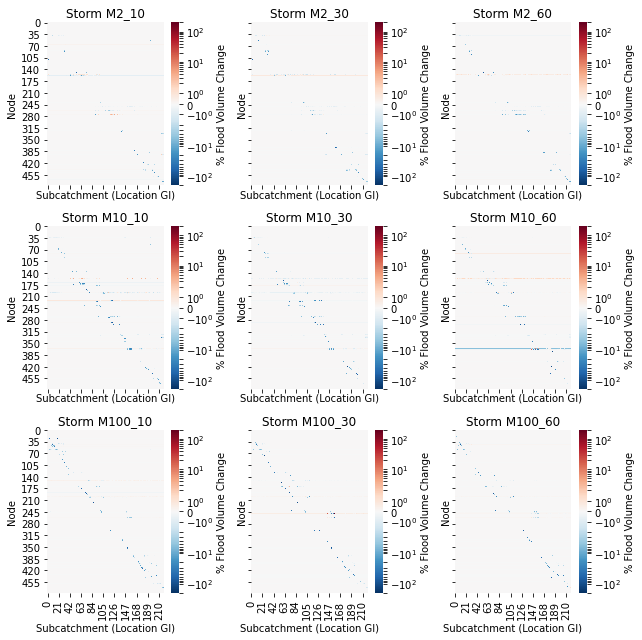

In [60]:
fig,axes=plt.subplots(3,3, figsize=(9,9),sharey=True, sharex=True)
i=0

for ax, s in zip(axes.flat,np.linspace(0,3,10)):
    sns.heatmap(flood[arr[i]],cmap='RdBu_r',center=0,norm=SymLogNorm(2), vmax=200, vmin=-200, ax=ax,cbar_kws={'label':'% Flood Volume Change'})
    ax.set_title(f'Storm {arr[i]}')
    ax.set_xlabel('Subcatchment (Location GI)')
    ax.set_ylabel('Node')
    i=i+1
    
fig.tight_layout()

In [61]:
hf={}
for i in tqdm(arr):
    hf[i]=pd.DataFrame()
    hf[i]['Name']=res[i][j]['Name']
    for j in tqdm(range(0,220)):
        hf[i][j]=None
        for ind,row in tqdm(res[i][j].iterrows()):
            if noderesilience[i][noderesilience[i].index==ind]['HoursFlooded'].values[0]>0:
                hf[i].loc[ind,j]=100*((row['HoursFlooded']-noderesilience[i][noderesilience[i].index==ind]['HoursFlooded'].values[0])/noderesilience[i][noderesilience[i].index==ind]['HoursFlooded'].values[0])
            else:
                hf[i].loc[ind,j]=0
    hf[i].replace(to_replace=np.inf,value=0,inplace=True)
    hf[i].replace(to_replace=np.nan,value=0,inplace=True)

  0%|          | 0/220 [00:00<?, ?it/s]

0it [00:00, ?it/s]

150it [00:00, 1494.18it/s]

304it [00:00, 1506.11it/s]

487it [00:00, 1433.52it/s]

  0%|          | 1/220 [00:00<01:14,  2.93it/s]

0it [00:00, ?it/s]

158it [00:00, 1572.19it/s]

318it [00:00, 1580.01it/s]

487it [00:00, 1486.48it/s]

  1%|          | 2/220 [00:00<01:13,  2.96it/s]

0it [00:00, ?it/s]

159it [00:00, 1575.68it/s]

318it [00:00, 1579.75it/s]

487it [00:00, 1469.56it/s]

  1%|▏         | 3/220 [00:01<01:13,  2.96it/s]

0it [00:00, ?it/s]

155it [00:00, 1549.23it/s]

310it [00:00, 1548.23it/s]

487it [00:00, 1464.55it/s]

  2%|▏         | 4/220 [00:01<01:12,  2.97it/s]

0it [00:00, ?it/s]

157it [00:00, 1563.11it/s]

299it [00:00, 1517.08it/s]

487it [00:00, 1394.30it/s]

  2%|▏         | 5/220 [00:01<01:13,  2.92it/s]

0it [00:00, ?it/s]

152it [00:00, 1507.77it/s]

302it [00:00, 1503.90it/s]

487it [00:00, 1425.54it/s]

  3%|▎         | 6/220 [00:02<01:13,  2.92it/s]

0it [00:00, ?it/s]

159it [00:00, 1580.74

 20%|██        | 45/220 [00:15<01:03,  2.76it/s]

0it [00:00, ?it/s]

143it [00:00, 1425.01it/s]

288it [00:00, 1430.91it/s]

487it [00:00, 1380.59it/s]

 21%|██        | 46/220 [00:16<01:02,  2.78it/s]

0it [00:00, ?it/s]

155it [00:00, 1549.16it/s]

302it [00:00, 1523.11it/s]

487it [00:00, 1385.15it/s]

 21%|██▏       | 47/220 [00:16<01:02,  2.79it/s]

0it [00:00, ?it/s]

153it [00:00, 1526.47it/s]

298it [00:00, 1501.55it/s]

487it [00:00, 1405.57it/s]

 22%|██▏       | 48/220 [00:16<01:01,  2.81it/s]

0it [00:00, ?it/s]

156it [00:00, 1556.03it/s]

304it [00:00, 1531.71it/s]

487it [00:00, 1395.79it/s]

 22%|██▏       | 49/220 [00:17<01:00,  2.82it/s]

0it [00:00, ?it/s]

152it [00:00, 1510.53it/s]

303it [00:00, 1505.98it/s]

487it [00:00, 1402.71it/s]

 23%|██▎       | 50/220 [00:17<01:00,  2.83it/s]

0it [00:00, ?it/s]

152it [00:00, 1508.09it/s]

301it [00:00, 1502.24it/s]

487it [00:00, 1397.74it/s]

 23%|██▎       | 51/220 [00:17<00:59,  2.84it/s]

0it [00:00, ?it/s]

109it 

 41%|████      | 90/220 [00:31<00:45,  2.83it/s]

0it [00:00, ?it/s]

151it [00:00, 1501.76it/s]

292it [00:00, 1472.95it/s]

487it [00:00, 1394.11it/s]

 41%|████▏     | 91/220 [00:32<00:45,  2.83it/s]

0it [00:00, ?it/s]

152it [00:00, 1509.48it/s]

299it [00:00, 1495.61it/s]

487it [00:00, 1403.99it/s]

 42%|████▏     | 92/220 [00:32<00:45,  2.84it/s]

0it [00:00, ?it/s]

146it [00:00, 1459.82it/s]

286it [00:00, 1436.91it/s]

487it [00:00, 1372.63it/s]

 42%|████▏     | 93/220 [00:32<00:44,  2.82it/s]

0it [00:00, ?it/s]

146it [00:00, 1456.68it/s]

292it [00:00, 1457.32it/s]

487it [00:00, 1386.20it/s]

 43%|████▎     | 94/220 [00:33<00:44,  2.82it/s]

0it [00:00, ?it/s]

152it [00:00, 1508.28it/s]

294it [00:00, 1478.39it/s]

487it [00:00, 1397.91it/s]

 43%|████▎     | 95/220 [00:33<00:44,  2.83it/s]

0it [00:00, ?it/s]

154it [00:00, 1537.91it/s]

298it [00:00, 1505.02it/s]

487it [00:00, 1403.49it/s]

 44%|████▎     | 96/220 [00:33<00:43,  2.84it/s]

0it [00:00, ?it/s]

156it 

487it [00:00, 1348.78it/s]

 61%|██████▏   | 135/220 [00:47<00:30,  2.78it/s]

0it [00:00, ?it/s]

152it [00:00, 1518.69it/s]

303it [00:00, 1512.30it/s]

487it [00:00, 1427.78it/s]

 62%|██████▏   | 136/220 [00:48<00:29,  2.82it/s]

0it [00:00, ?it/s]

150it [00:00, 1496.87it/s]

300it [00:00, 1497.42it/s]

487it [00:00, 1400.08it/s]

 62%|██████▏   | 137/220 [00:48<00:29,  2.83it/s]

0it [00:00, ?it/s]

145it [00:00, 1442.36it/s]

287it [00:00, 1435.30it/s]

487it [00:00, 1377.08it/s]

 63%|██████▎   | 138/220 [00:48<00:29,  2.82it/s]

0it [00:00, ?it/s]

140it [00:00, 1398.28it/s]

272it [00:00, 1373.25it/s]

487it [00:00, 1311.94it/s]

 63%|██████▎   | 139/220 [00:49<00:29,  2.77it/s]

0it [00:00, ?it/s]

141it [00:00, 1407.73it/s]

283it [00:00, 1410.39it/s]

487it [00:00, 1347.37it/s]

 64%|██████▎   | 140/220 [00:49<00:28,  2.76it/s]

0it [00:00, ?it/s]

145it [00:00, 1449.58it/s]

290it [00:00, 1445.83it/s]

487it [00:00, 1364.55it/s]

 64%|██████▍   | 141/220 [00:50<00:28,  2.

487it [00:00, 1336.01it/s]

 82%|████████▏ | 180/220 [01:04<00:14,  2.75it/s]

0it [00:00, ?it/s]

143it [00:00, 1427.66it/s]

290it [00:00, 1435.49it/s]

487it [00:00, 1377.94it/s]

 82%|████████▏ | 181/220 [01:04<00:14,  2.77it/s]

0it [00:00, ?it/s]

146it [00:00, 1450.58it/s]

276it [00:00, 1401.82it/s]

487it [00:00, 1249.64it/s]

 83%|████████▎ | 182/220 [01:04<00:14,  2.70it/s]

0it [00:00, ?it/s]

139it [00:00, 1379.04it/s]

281it [00:00, 1389.56it/s]

487it [00:00, 1327.31it/s]

 83%|████████▎ | 183/220 [01:05<00:13,  2.70it/s]

0it [00:00, ?it/s]

141it [00:00, 1407.86it/s]

288it [00:00, 1425.82it/s]

487it [00:00, 1348.10it/s]

 84%|████████▎ | 184/220 [01:05<00:13,  2.71it/s]

0it [00:00, ?it/s]

142it [00:00, 1413.53it/s]

286it [00:00, 1418.98it/s]

487it [00:00, 1346.98it/s]

 84%|████████▍ | 185/220 [01:05<00:12,  2.72it/s]

0it [00:00, ?it/s]

148it [00:00, 1477.90it/s]

289it [00:00, 1455.03it/s]

487it [00:00, 1368.84it/s]

 85%|████████▍ | 186/220 [01:06<00:12,  2.

487it [00:00, 1272.45it/s]

  2%|▏         | 4/220 [00:01<01:19,  2.72it/s]

0it [00:00, ?it/s]

93it [00:00, 925.66it/s]

236it [00:00, 1034.94it/s]

487it [00:00, 1229.11it/s]

  2%|▏         | 5/220 [00:01<01:21,  2.64it/s]

0it [00:00, ?it/s]

146it [00:00, 1454.76it/s]

290it [00:00, 1449.20it/s]

487it [00:00, 1366.78it/s]

  3%|▎         | 6/220 [00:02<01:19,  2.68it/s]

0it [00:00, ?it/s]

124it [00:00, 1237.39it/s]

264it [00:00, 1279.53it/s]

487it [00:00, 1309.92it/s]

  3%|▎         | 7/220 [00:02<01:19,  2.68it/s]

0it [00:00, ?it/s]

150it [00:00, 1499.74it/s]

294it [00:00, 1480.39it/s]

487it [00:00, 1345.95it/s]

  4%|▎         | 8/220 [00:02<01:18,  2.69it/s]

0it [00:00, ?it/s]

144it [00:00, 1438.99it/s]

291it [00:00, 1447.58it/s]

487it [00:00, 1303.32it/s]

  4%|▍         | 9/220 [00:03<01:18,  2.68it/s]

0it [00:00, ?it/s]

130it [00:00, 1287.83it/s]

275it [00:00, 1331.43it/s]

487it [00:00, 1339.21it/s]

  5%|▍         | 10/220 [00:03<01:17,  2.70it/s]

0it [0

 22%|██▏       | 49/220 [00:18<01:02,  2.73it/s]

0it [00:00, ?it/s]

141it [00:00, 1408.82it/s]

282it [00:00, 1407.89it/s]

487it [00:00, 1347.66it/s]

 23%|██▎       | 50/220 [00:18<01:02,  2.74it/s]

0it [00:00, ?it/s]

141it [00:00, 1405.57it/s]

282it [00:00, 1405.95it/s]

487it [00:00, 1332.32it/s]

 23%|██▎       | 51/220 [00:18<01:01,  2.73it/s]

0it [00:00, ?it/s]

139it [00:00, 1385.77it/s]

277it [00:00, 1375.90it/s]

383it [00:00, 1262.95it/s]

487it [00:00, 1177.38it/s]

 24%|██▎       | 52/220 [00:19<01:04,  2.62it/s]

0it [00:00, ?it/s]

123it [00:00, 1229.17it/s]

264it [00:00, 1276.21it/s]

487it [00:00, 1299.03it/s]

 24%|██▍       | 53/220 [00:19<01:03,  2.63it/s]

0it [00:00, ?it/s]

143it [00:00, 1426.70it/s]

293it [00:00, 1446.58it/s]

487it [00:00, 1288.76it/s]

 25%|██▍       | 54/220 [00:20<01:03,  2.63it/s]

0it [00:00, ?it/s]

139it [00:00, 1375.84it/s]

281it [00:00, 1387.03it/s]

487it [00:00, 1341.31it/s]

 25%|██▌       | 55/220 [00:20<01:02,  2.66it/s]

142it [00:00, 1416.83it/s]

284it [00:00, 1416.53it/s]

487it [00:00, 1387.38it/s]

 43%|████▎     | 94/220 [00:35<00:45,  2.76it/s]

0it [00:00, ?it/s]

139it [00:00, 1378.98it/s]

289it [00:00, 1411.41it/s]

487it [00:00, 1393.48it/s]

 43%|████▎     | 95/220 [00:35<00:44,  2.78it/s]

0it [00:00, ?it/s]

154it [00:00, 1525.43it/s]

305it [00:00, 1519.76it/s]

487it [00:00, 1425.05it/s]

 44%|████▎     | 96/220 [00:35<00:44,  2.81it/s]

0it [00:00, ?it/s]

148it [00:00, 1476.58it/s]

300it [00:00, 1487.79it/s]

487it [00:00, 1384.05it/s]

 44%|████▍     | 97/220 [00:36<00:43,  2.81it/s]

0it [00:00, ?it/s]

139it [00:00, 1382.97it/s]

281it [00:00, 1392.55it/s]

487it [00:00, 1349.80it/s]

 45%|████▍     | 98/220 [00:36<00:43,  2.79it/s]

0it [00:00, ?it/s]

140it [00:00, 1397.63it/s]

282it [00:00, 1403.28it/s]

487it [00:00, 1364.31it/s]

 45%|████▌     | 99/220 [00:36<00:43,  2.79it/s]

0it [00:00, ?it/s]

148it [00:00, 1474.41it/s]

297it [00:00, 1476.97it/s]

487it [00:00, 1395.5

148it [00:00, 1478.89it/s]

295it [00:00, 1474.87it/s]

487it [00:00, 1409.18it/s]

 63%|██████▎   | 139/220 [00:51<00:28,  2.84it/s]

0it [00:00, ?it/s]

148it [00:00, 1477.31it/s]

296it [00:00, 1474.87it/s]

487it [00:00, 1398.09it/s]

 64%|██████▎   | 140/220 [00:51<00:28,  2.84it/s]

0it [00:00, ?it/s]

142it [00:00, 1414.89it/s]

276it [00:00, 1390.03it/s]

487it [00:00, 1347.14it/s]

 64%|██████▍   | 141/220 [00:52<00:28,  2.81it/s]

0it [00:00, ?it/s]

144it [00:00, 1438.05it/s]

294it [00:00, 1455.56it/s]

487it [00:00, 1413.92it/s]

 65%|██████▍   | 142/220 [00:52<00:27,  2.83it/s]

0it [00:00, ?it/s]

149it [00:00, 1485.32it/s]

299it [00:00, 1488.81it/s]

487it [00:00, 1403.90it/s]

 65%|██████▌   | 143/220 [00:52<00:27,  2.83it/s]

0it [00:00, ?it/s]

145it [00:00, 1443.56it/s]

289it [00:00, 1440.70it/s]

487it [00:00, 1380.37it/s]

 65%|██████▌   | 144/220 [00:53<00:26,  2.83it/s]

0it [00:00, ?it/s]

147it [00:00, 1467.59it/s]

280it [00:00, 1421.44it/s]

487it [00:00, 

139it [00:00, 1386.59it/s]

277it [00:00, 1382.23it/s]

487it [00:00, 1322.42it/s]

 84%|████████▎ | 184/220 [01:07<00:13,  2.68it/s]

0it [00:00, ?it/s]

139it [00:00, 1375.92it/s]

277it [00:00, 1375.96it/s]

487it [00:00, 1309.39it/s]

 84%|████████▍ | 185/220 [01:08<00:13,  2.68it/s]

0it [00:00, ?it/s]

138it [00:00, 1369.10it/s]

278it [00:00, 1377.70it/s]

487it [00:00, 1320.76it/s]

 85%|████████▍ | 186/220 [01:08<00:12,  2.68it/s]

0it [00:00, ?it/s]

133it [00:00, 1328.93it/s]

274it [00:00, 1351.76it/s]

487it [00:00, 1303.25it/s]

 85%|████████▌ | 187/220 [01:09<00:12,  2.67it/s]

0it [00:00, ?it/s]

132it [00:00, 1318.39it/s]

266it [00:00, 1322.96it/s]

487it [00:00, 1306.78it/s]

 85%|████████▌ | 188/220 [01:09<00:11,  2.67it/s]

0it [00:00, ?it/s]

144it [00:00, 1438.42it/s]

274it [00:00, 1393.51it/s]

487it [00:00, 1306.81it/s]

 86%|████████▌ | 189/220 [01:09<00:11,  2.67it/s]

0it [00:00, ?it/s]

145it [00:00, 1444.61it/s]

295it [00:00, 1459.93it/s]

487it [00:00, 

487it [00:00, 1417.19it/s]

  4%|▎         | 8/220 [00:02<01:13,  2.88it/s]

0it [00:00, ?it/s]

142it [00:00, 1418.50it/s]

289it [00:00, 1432.32it/s]

487it [00:00, 1416.57it/s]

  4%|▍         | 9/220 [00:03<01:13,  2.88it/s]

0it [00:00, ?it/s]

135it [00:00, 1346.11it/s]

258it [00:00, 1307.33it/s]

487it [00:00, 1288.65it/s]

  5%|▍         | 10/220 [00:03<01:15,  2.80it/s]

0it [00:00, ?it/s]

139it [00:00, 1377.42it/s]

282it [00:00, 1391.50it/s]

487it [00:00, 1254.60it/s]

  5%|▌         | 11/220 [00:03<01:16,  2.72it/s]

0it [00:00, ?it/s]

146it [00:00, 1456.24it/s]

287it [00:00, 1441.28it/s]

487it [00:00, 1367.23it/s]

  5%|▌         | 12/220 [00:04<01:15,  2.74it/s]

0it [00:00, ?it/s]

139it [00:00, 1383.98it/s]

283it [00:00, 1398.40it/s]

487it [00:00, 1375.83it/s]

  6%|▌         | 13/220 [00:04<01:15,  2.76it/s]

0it [00:00, ?it/s]

145it [00:00, 1445.82it/s]

289it [00:00, 1442.23it/s]

487it [00:00, 1391.63it/s]

  6%|▋         | 14/220 [00:04<01:14,  2.78it/s]



142it [00:00, 1413.03it/s]

264it [00:00, 1346.95it/s]

378it [00:00, 1274.98it/s]

487it [00:00, 1200.24it/s]

 24%|██▍       | 53/220 [00:19<01:03,  2.63it/s]

0it [00:00, ?it/s]

116it [00:00, 1159.33it/s]

237it [00:00, 1171.44it/s]

334it [00:00, 1102.49it/s]

487it [00:00, 1137.72it/s]

 25%|██▍       | 54/220 [00:19<01:05,  2.53it/s]

0it [00:00, ?it/s]

139it [00:00, 1388.25it/s]

284it [00:00, 1404.38it/s]

487it [00:00, 1321.67it/s]

 25%|██▌       | 55/220 [00:20<01:04,  2.57it/s]

0it [00:00, ?it/s]

134it [00:00, 1333.90it/s]

253it [00:00, 1286.18it/s]

487it [00:00, 1259.43it/s]

 25%|██▌       | 56/220 [00:20<01:03,  2.57it/s]

0it [00:00, ?it/s]

121it [00:00, 1207.19it/s]

243it [00:00, 1208.02it/s]

487it [00:00, 1247.07it/s]

 26%|██▌       | 57/220 [00:21<01:03,  2.56it/s]

0it [00:00, ?it/s]

108it [00:00, 1079.01it/s]

237it [00:00, 1134.13it/s]

487it [00:00, 1239.77it/s]

 26%|██▋       | 58/220 [00:21<01:03,  2.55it/s]

0it [00:00, ?it/s]

124it [00:00, 1236.4

 44%|████▍     | 97/220 [00:35<00:45,  2.71it/s]

0it [00:00, ?it/s]

143it [00:00, 1424.77it/s]

286it [00:00, 1424.53it/s]

487it [00:00, 1367.18it/s]

 45%|████▍     | 98/220 [00:35<00:44,  2.73it/s]

0it [00:00, ?it/s]

144it [00:00, 1433.86it/s]

288it [00:00, 1435.29it/s]

487it [00:00, 1405.77it/s]

 45%|████▌     | 99/220 [00:36<00:43,  2.77it/s]

0it [00:00, ?it/s]

138it [00:00, 1364.59it/s]

280it [00:00, 1378.48it/s]

487it [00:00, 1355.71it/s]

 45%|████▌     | 100/220 [00:36<00:43,  2.76it/s]

0it [00:00, ?it/s]

141it [00:00, 1409.90it/s]

278it [00:00, 1396.68it/s]

487it [00:00, 1338.64it/s]

 46%|████▌     | 101/220 [00:36<00:43,  2.75it/s]

0it [00:00, ?it/s]

140it [00:00, 1398.47it/s]

281it [00:00, 1400.33it/s]

487it [00:00, 1388.85it/s]

 46%|████▋     | 102/220 [00:37<00:42,  2.77it/s]

0it [00:00, ?it/s]

148it [00:00, 1479.26it/s]

288it [00:00, 1454.53it/s]

487it [00:00, 1369.42it/s]

 47%|████▋     | 103/220 [00:37<00:42,  2.78it/s]

0it [00:00, ?it/s]

13

267it [00:00, 1290.93it/s]

487it [00:00, 1262.84it/s]

 65%|██████▍   | 142/220 [00:52<00:30,  2.57it/s]

0it [00:00, ?it/s]

136it [00:00, 1356.03it/s]

272it [00:00, 1351.52it/s]

487it [00:00, 1279.45it/s]

 65%|██████▌   | 143/220 [00:52<00:29,  2.58it/s]

0it [00:00, ?it/s]

129it [00:00, 1283.46it/s]

223it [00:00, 1151.39it/s]

347it [00:00, 1172.72it/s]

487it [00:00, 1160.46it/s]

 65%|██████▌   | 144/220 [00:52<00:30,  2.51it/s]

0it [00:00, ?it/s]

140it [00:00, 1398.75it/s]

275it [00:00, 1381.71it/s]

487it [00:00, 1276.20it/s]

 66%|██████▌   | 145/220 [00:53<00:29,  2.53it/s]

0it [00:00, ?it/s]

125it [00:00, 1244.81it/s]

242it [00:00, 1219.79it/s]

373it [00:00, 1245.47it/s]

487it [00:00, 1171.36it/s]

 66%|██████▋   | 146/220 [00:53<00:29,  2.49it/s]

0it [00:00, ?it/s]

125it [00:00, 1243.95it/s]

243it [00:00, 1223.69it/s]

487it [00:00, 1231.46it/s]

 67%|██████▋   | 147/220 [00:54<00:29,  2.49it/s]

0it [00:00, ?it/s]

123it [00:00, 1229.09it/s]

253it [00:00, 

 85%|████████▍ | 186/220 [01:08<00:12,  2.78it/s]

0it [00:00, ?it/s]

140it [00:00, 1394.33it/s]

279it [00:00, 1391.51it/s]

487it [00:00, 1369.74it/s]

 85%|████████▌ | 187/220 [01:08<00:11,  2.78it/s]

0it [00:00, ?it/s]

139it [00:00, 1380.88it/s]

280it [00:00, 1384.31it/s]

487it [00:00, 1364.70it/s]

 85%|████████▌ | 188/220 [01:09<00:11,  2.78it/s]

0it [00:00, ?it/s]

144it [00:00, 1436.25it/s]

290it [00:00, 1441.52it/s]

487it [00:00, 1389.02it/s]

 86%|████████▌ | 189/220 [01:09<00:11,  2.79it/s]

0it [00:00, ?it/s]

139it [00:00, 1382.77it/s]

282it [00:00, 1395.28it/s]

487it [00:00, 1365.26it/s]

 86%|████████▋ | 190/220 [01:09<00:10,  2.79it/s]

0it [00:00, ?it/s]

140it [00:00, 1398.27it/s]

280it [00:00, 1397.02it/s]

487it [00:00, 1381.12it/s]

 87%|████████▋ | 191/220 [01:10<00:10,  2.79it/s]

0it [00:00, ?it/s]

144it [00:00, 1434.90it/s]

294it [00:00, 1451.91it/s]

487it [00:00, 1417.45it/s]

 87%|████████▋ | 192/220 [01:10<00:09,  2.82it/s]

0it [00:00, ?it/s]


138it [00:00, 1375.12it/s]

265it [00:00, 1338.79it/s]

487it [00:00, 1264.51it/s]

  5%|▌         | 11/220 [00:04<01:21,  2.55it/s]

0it [00:00, ?it/s]

138it [00:00, 1374.89it/s]

267it [00:00, 1347.87it/s]

487it [00:00, 1292.73it/s]

  5%|▌         | 12/220 [00:04<01:20,  2.57it/s]

0it [00:00, ?it/s]

106it [00:00, 1055.81it/s]

206it [00:00, 1038.01it/s]

324it [00:00, 1074.59it/s]

487it [00:00, 1087.43it/s]

  6%|▌         | 13/220 [00:05<01:24,  2.45it/s]

0it [00:00, ?it/s]

137it [00:00, 1361.14it/s]

262it [00:00, 1325.43it/s]

487it [00:00, 1254.19it/s]

  6%|▋         | 14/220 [00:05<01:22,  2.48it/s]

0it [00:00, ?it/s]

139it [00:00, 1384.14it/s]

271it [00:00, 1362.53it/s]

487it [00:00, 1253.68it/s]

  7%|▋         | 15/220 [00:05<01:21,  2.50it/s]

0it [00:00, ?it/s]

139it [00:00, 1374.89it/s]

272it [00:00, 1359.30it/s]

487it [00:00, 1306.63it/s]

  7%|▋         | 16/220 [00:06<01:20,  2.55it/s]

0it [00:00, ?it/s]

143it [00:00, 1424.50it/s]

274it [00:00, 1385.9

487it [00:00, 1330.60it/s]

 25%|██▌       | 55/220 [00:21<01:02,  2.66it/s]

0it [00:00, ?it/s]

143it [00:00, 1428.74it/s]

276it [00:00, 1396.05it/s]

487it [00:00, 1320.95it/s]

 25%|██▌       | 56/220 [00:21<01:01,  2.67it/s]

0it [00:00, ?it/s]

145it [00:00, 1446.44it/s]

280it [00:00, 1415.07it/s]

487it [00:00, 1341.99it/s]

 26%|██▌       | 57/220 [00:22<01:00,  2.69it/s]

0it [00:00, ?it/s]

143it [00:00, 1418.85it/s]

280it [00:00, 1400.86it/s]

487it [00:00, 1334.30it/s]

 26%|██▋       | 58/220 [00:22<01:00,  2.69it/s]

0it [00:00, ?it/s]

143it [00:00, 1426.87it/s]

275it [00:00, 1388.58it/s]

487it [00:00, 1322.03it/s]

 27%|██▋       | 59/220 [00:22<00:59,  2.69it/s]

0it [00:00, ?it/s]

143it [00:00, 1420.98it/s]

277it [00:00, 1390.71it/s]

487it [00:00, 1324.45it/s]

 27%|██▋       | 60/220 [00:23<00:59,  2.69it/s]

0it [00:00, ?it/s]

146it [00:00, 1454.58it/s]

276it [00:00, 1402.67it/s]

487it [00:00, 1316.71it/s]

 28%|██▊       | 61/220 [00:23<00:59,  2.69it/s]

0it [00:00, ?it/s]

143it [00:00, 1417.67it/s]

270it [00:00, 1369.81it/s]

487it [00:00, 1279.93it/s]

 45%|████▌     | 100/220 [00:39<00:47,  2.54it/s]

0it [00:00, ?it/s]

138it [00:00, 1372.78it/s]

268it [00:00, 1347.72it/s]

487it [00:00, 1265.82it/s]

 46%|████▌     | 101/220 [00:39<00:46,  2.55it/s]

0it [00:00, ?it/s]

133it [00:00, 1321.94it/s]

259it [00:00, 1300.94it/s]

487it [00:00, 1232.45it/s]

 46%|████▋     | 102/220 [00:39<00:46,  2.54it/s]

0it [00:00, ?it/s]

137it [00:00, 1362.03it/s]

265it [00:00, 1335.34it/s]

487it [00:00, 1279.15it/s]

 47%|████▋     | 103/220 [00:40<00:45,  2.56it/s]

0it [00:00, ?it/s]

138it [00:00, 1367.91it/s]

267it [00:00, 1343.24it/s]

487it [00:00, 1275.07it/s]

 47%|████▋     | 104/220 [00:40<00:45,  2.57it/s]

0it [00:00, ?it/s]

138it [00:00, 1379.16it/s]

268it [00:00, 1353.94it/s]

487it [00:00, 1293.49it/s]

 48%|████▊     | 105/220 [00:40<00:44,  2.59it/s]

0it [00:00, ?it/s]

141it [00:00, 1407.31it/s]

276it [00:00, 1385.37i

487it [00:00, 1111.14it/s]

 64%|██████▍   | 141/220 [00:55<00:34,  2.31it/s]

0it [00:00, ?it/s]

132it [00:00, 1318.13it/s]

258it [00:00, 1298.56it/s]

487it [00:00, 1243.22it/s]

 65%|██████▍   | 142/220 [00:56<00:32,  2.37it/s]

0it [00:00, ?it/s]

137it [00:00, 1359.13it/s]

270it [00:00, 1349.31it/s]

487it [00:00, 1248.27it/s]

 65%|██████▌   | 143/220 [00:56<00:31,  2.42it/s]

0it [00:00, ?it/s]

138it [00:00, 1371.97it/s]

264it [00:00, 1332.85it/s]

487it [00:00, 1220.21it/s]

 65%|██████▌   | 144/220 [00:57<00:31,  2.44it/s]

0it [00:00, ?it/s]

134it [00:00, 1335.36it/s]

253it [00:00, 1283.60it/s]

487it [00:00, 1239.58it/s]

 66%|██████▌   | 145/220 [00:57<00:30,  2.46it/s]

0it [00:00, ?it/s]

138it [00:00, 1366.95it/s]

267it [00:00, 1342.61it/s]

487it [00:00, 1258.11it/s]

 66%|██████▋   | 146/220 [00:57<00:29,  2.49it/s]

0it [00:00, ?it/s]

131it [00:00, 1299.39it/s]

256it [00:00, 1283.35it/s]

487it [00:00, 1253.83it/s]

 67%|██████▋   | 147/220 [00:58<00:29,  2.

 84%|████████▍ | 185/220 [01:13<00:13,  2.51it/s]

0it [00:00, ?it/s]

136it [00:00, 1344.06it/s]

247it [00:00, 1260.75it/s]

357it [00:00, 1206.52it/s]

487it [00:00, 1155.31it/s]

 85%|████████▍ | 186/220 [01:13<00:13,  2.46it/s]

0it [00:00, ?it/s]

133it [00:00, 1328.95it/s]

256it [00:00, 1297.21it/s]

487it [00:00, 1233.44it/s]

 85%|████████▌ | 187/220 [01:14<00:13,  2.47it/s]

0it [00:00, ?it/s]

136it [00:00, 1351.89it/s]

265it [00:00, 1331.19it/s]

487it [00:00, 1249.42it/s]

 85%|████████▌ | 188/220 [01:14<00:12,  2.50it/s]

0it [00:00, ?it/s]

134it [00:00, 1337.40it/s]

253it [00:00, 1288.55it/s]

487it [00:00, 1235.89it/s]

 86%|████████▌ | 189/220 [01:14<00:12,  2.50it/s]

0it [00:00, ?it/s]

138it [00:00, 1370.32it/s]

264it [00:00, 1334.85it/s]

487it [00:00, 1279.83it/s]

 86%|████████▋ | 190/220 [01:15<00:11,  2.53it/s]

0it [00:00, ?it/s]

130it [00:00, 1290.00it/s]

252it [00:00, 1266.25it/s]

487it [00:00, 1224.90it/s]

 87%|████████▋ | 191/220 [01:15<00:11,  2.

0it [00:00, ?it/s]

134it [00:00, 1339.61it/s]

271it [00:00, 1346.61it/s]

487it [00:00, 1281.60it/s]

  4%|▍         | 9/220 [00:03<01:19,  2.64it/s]

0it [00:00, ?it/s]

138it [00:00, 1366.57it/s]

277it [00:00, 1371.56it/s]

487it [00:00, 1295.34it/s]

  5%|▍         | 10/220 [00:03<01:19,  2.64it/s]

0it [00:00, ?it/s]

139it [00:00, 1388.77it/s]

277it [00:00, 1380.32it/s]

487it [00:00, 1299.82it/s]

  5%|▌         | 11/220 [00:04<01:19,  2.64it/s]

0it [00:00, ?it/s]

138it [00:00, 1369.86it/s]

276it [00:00, 1370.66it/s]

487it [00:00, 1305.03it/s]

  5%|▌         | 12/220 [00:04<01:18,  2.64it/s]

0it [00:00, ?it/s]

144it [00:00, 1435.42it/s]

280it [00:00, 1411.36it/s]

487it [00:00, 1305.42it/s]

  6%|▌         | 13/220 [00:04<01:18,  2.65it/s]

0it [00:00, ?it/s]

136it [00:00, 1353.40it/s]

272it [00:00, 1351.79it/s]

487it [00:00, 1284.83it/s]

  6%|▋         | 14/220 [00:05<01:18,  2.64it/s]

0it [00:00, ?it/s]

139it [00:00, 1385.52it/s]

276it [00:00, 1380.03it/s]

4

131it [00:00, 1297.20it/s]

267it [00:00, 1314.80it/s]

487it [00:00, 1268.76it/s]

 24%|██▍       | 53/220 [00:20<01:05,  2.56it/s]

0it [00:00, ?it/s]

138it [00:00, 1362.34it/s]

275it [00:00, 1361.48it/s]

487it [00:00, 1289.57it/s]

 25%|██▍       | 54/220 [00:20<01:04,  2.58it/s]

0it [00:00, ?it/s]

138it [00:00, 1364.57it/s]

273it [00:00, 1360.08it/s]

487it [00:00, 1307.41it/s]

 25%|██▌       | 55/220 [00:21<01:03,  2.60it/s]

0it [00:00, ?it/s]

138it [00:00, 1377.78it/s]

280it [00:00, 1388.78it/s]

487it [00:00, 1301.43it/s]

 25%|██▌       | 56/220 [00:21<01:02,  2.61it/s]

0it [00:00, ?it/s]

138it [00:00, 1376.93it/s]

277it [00:00, 1377.61it/s]

487it [00:00, 1289.59it/s]

 26%|██▌       | 57/220 [00:22<01:02,  2.62it/s]

0it [00:00, ?it/s]

139it [00:00, 1387.71it/s]

276it [00:00, 1382.21it/s]

487it [00:00, 1304.90it/s]

 26%|██▋       | 58/220 [00:22<01:01,  2.63it/s]

0it [00:00, ?it/s]

136it [00:00, 1358.47it/s]

275it [00:00, 1365.85it/s]

487it [00:00, 1291.5

270it [00:00, 1353.43it/s]

487it [00:00, 1306.02it/s]

 45%|████▍     | 98/220 [00:37<00:46,  2.63it/s]

0it [00:00, ?it/s]

135it [00:00, 1343.99it/s]

276it [00:00, 1361.05it/s]

487it [00:00, 1286.26it/s]

 45%|████▌     | 99/220 [00:38<00:46,  2.63it/s]

0it [00:00, ?it/s]

137it [00:00, 1354.02it/s]

273it [00:00, 1354.11it/s]

487it [00:00, 1281.60it/s]

 45%|████▌     | 100/220 [00:38<00:45,  2.62it/s]

0it [00:00, ?it/s]

136it [00:00, 1356.91it/s]

269it [00:00, 1348.02it/s]

487it [00:00, 1265.93it/s]

 46%|████▌     | 101/220 [00:38<00:45,  2.61it/s]

0it [00:00, ?it/s]

136it [00:00, 1358.33it/s]

277it [00:00, 1370.09it/s]

487it [00:00, 1284.97it/s]

 46%|████▋     | 102/220 [00:39<00:45,  2.61it/s]

0it [00:00, ?it/s]

136it [00:00, 1356.31it/s]

264it [00:00, 1330.01it/s]

487it [00:00, 1257.82it/s]

 47%|████▋     | 103/220 [00:39<00:45,  2.59it/s]

0it [00:00, ?it/s]

132it [00:00, 1319.22it/s]

264it [00:00, 1314.07it/s]

487it [00:00, 1245.36it/s]

 47%|████▋     |

269it [00:00, 1346.84it/s]

487it [00:00, 1265.92it/s]

 65%|██████▌   | 143/220 [00:54<00:29,  2.58it/s]

0it [00:00, ?it/s]

138it [00:00, 1363.48it/s]

272it [00:00, 1354.29it/s]

487it [00:00, 1273.76it/s]

 65%|██████▌   | 144/220 [00:55<00:29,  2.58it/s]

0it [00:00, ?it/s]

140it [00:00, 1399.57it/s]

280it [00:00, 1397.31it/s]

487it [00:00, 1300.24it/s]

 66%|██████▌   | 145/220 [00:55<00:28,  2.60it/s]

0it [00:00, ?it/s]

133it [00:00, 1325.84it/s]

270it [00:00, 1337.77it/s]

487it [00:00, 1284.50it/s]

 66%|██████▋   | 146/220 [00:55<00:28,  2.61it/s]

0it [00:00, ?it/s]

128it [00:00, 1273.55it/s]

262it [00:00, 1292.10it/s]

487it [00:00, 1226.24it/s]

 67%|██████▋   | 147/220 [00:56<00:28,  2.57it/s]

0it [00:00, ?it/s]

137it [00:00, 1355.98it/s]

272it [00:00, 1352.77it/s]

487it [00:00, 1273.60it/s]

 67%|██████▋   | 148/220 [00:56<00:27,  2.58it/s]

0it [00:00, ?it/s]

136it [00:00, 1347.95it/s]

275it [00:00, 1358.15it/s]

487it [00:00, 1277.66it/s]

 68%|██████▊  

264it [00:00, 1318.84it/s]

487it [00:00, 1245.24it/s]

 85%|████████▌ | 188/220 [01:12<00:12,  2.58it/s]

0it [00:00, ?it/s]

131it [00:00, 1309.87it/s]

265it [00:00, 1318.57it/s]

487it [00:00, 1260.47it/s]

 86%|████████▌ | 189/220 [01:12<00:12,  2.57it/s]

0it [00:00, ?it/s]

136it [00:00, 1352.75it/s]

272it [00:00, 1352.41it/s]

487it [00:00, 1286.99it/s]

 86%|████████▋ | 190/220 [01:12<00:11,  2.59it/s]

0it [00:00, ?it/s]

132it [00:00, 1315.92it/s]

266it [00:00, 1321.89it/s]

487it [00:00, 1254.97it/s]

 87%|████████▋ | 191/220 [01:13<00:11,  2.58it/s]

0it [00:00, ?it/s]

126it [00:00, 1257.07it/s]

258it [00:00, 1273.85it/s]

487it [00:00, 1253.38it/s]

 87%|████████▋ | 192/220 [01:13<00:10,  2.57it/s]

0it [00:00, ?it/s]

134it [00:00, 1339.96it/s]

271it [00:00, 1347.79it/s]

487it [00:00, 1267.68it/s]

 88%|████████▊ | 193/220 [01:14<00:10,  2.58it/s]

0it [00:00, ?it/s]

136it [00:00, 1352.87it/s]

276it [00:00, 1365.24it/s]

487it [00:00, 1314.07it/s]

 88%|████████▊

  5%|▌         | 12/220 [00:04<01:15,  2.75it/s]

0it [00:00, ?it/s]

144it [00:00, 1439.68it/s]

281it [00:00, 1416.45it/s]

487it [00:00, 1356.75it/s]

  6%|▌         | 13/220 [00:04<01:15,  2.75it/s]

0it [00:00, ?it/s]

142it [00:00, 1415.91it/s]

286it [00:00, 1420.06it/s]

487it [00:00, 1337.46it/s]

  6%|▋         | 14/220 [00:05<01:15,  2.74it/s]

0it [00:00, ?it/s]

137it [00:00, 1361.96it/s]

277it [00:00, 1371.28it/s]

487it [00:00, 1318.69it/s]

  7%|▋         | 15/220 [00:05<01:15,  2.73it/s]

0it [00:00, ?it/s]

140it [00:00, 1394.17it/s]

288it [00:00, 1417.55it/s]

487it [00:00, 1370.02it/s]

  7%|▋         | 16/220 [00:05<01:14,  2.74it/s]

0it [00:00, ?it/s]

141it [00:00, 1403.78it/s]

284it [00:00, 1410.56it/s]

487it [00:00, 1344.74it/s]

  8%|▊         | 17/220 [00:06<01:14,  2.74it/s]

0it [00:00, ?it/s]

138it [00:00, 1369.75it/s]

279it [00:00, 1381.40it/s]

487it [00:00, 1346.51it/s]

  8%|▊         | 18/220 [00:06<01:13,  2.74it/s]

0it [00:00, ?it/s]

142it 

 26%|██▌       | 57/220 [00:21<01:00,  2.68it/s]

0it [00:00, ?it/s]

138it [00:00, 1364.86it/s]

277it [00:00, 1371.00it/s]

487it [00:00, 1320.30it/s]

 26%|██▋       | 58/220 [00:21<01:00,  2.69it/s]

0it [00:00, ?it/s]

137it [00:00, 1369.25it/s]

248it [00:00, 1277.93it/s]

487it [00:00, 1238.58it/s]

 27%|██▋       | 59/220 [00:21<01:01,  2.63it/s]

0it [00:00, ?it/s]

143it [00:00, 1426.94it/s]

292it [00:00, 1444.83it/s]

487it [00:00, 1323.21it/s]

 27%|██▋       | 60/220 [00:22<01:00,  2.65it/s]

0it [00:00, ?it/s]

143it [00:00, 1426.72it/s]

288it [00:00, 1433.12it/s]

487it [00:00, 1379.10it/s]

 28%|██▊       | 61/220 [00:22<00:58,  2.70it/s]

0it [00:00, ?it/s]

144it [00:00, 1433.08it/s]

289it [00:00, 1436.79it/s]

487it [00:00, 1370.48it/s]

 28%|██▊       | 62/220 [00:22<00:58,  2.72it/s]

0it [00:00, ?it/s]

144it [00:00, 1438.06it/s]

287it [00:00, 1434.37it/s]

487it [00:00, 1343.73it/s]

 29%|██▊       | 63/220 [00:23<00:57,  2.73it/s]

0it [00:00, ?it/s]

138it 

487it [00:00, 1370.63it/s]

 46%|████▋     | 102/220 [00:37<00:43,  2.71it/s]

0it [00:00, ?it/s]

138it [00:00, 1377.71it/s]

280it [00:00, 1388.68it/s]

487it [00:00, 1352.27it/s]

 47%|████▋     | 103/220 [00:38<00:43,  2.72it/s]

0it [00:00, ?it/s]

138it [00:00, 1378.88it/s]

281it [00:00, 1391.47it/s]

487it [00:00, 1372.30it/s]

 47%|████▋     | 104/220 [00:38<00:42,  2.74it/s]

0it [00:00, ?it/s]

143it [00:00, 1426.15it/s]

287it [00:00, 1428.56it/s]

487it [00:00, 1355.44it/s]

 48%|████▊     | 105/220 [00:39<00:41,  2.74it/s]

0it [00:00, ?it/s]

137it [00:00, 1358.14it/s]

276it [00:00, 1363.07it/s]

487it [00:00, 1326.10it/s]

 48%|████▊     | 106/220 [00:39<00:41,  2.73it/s]

0it [00:00, ?it/s]

140it [00:00, 1394.67it/s]

286it [00:00, 1408.89it/s]

487it [00:00, 1368.98it/s]

 49%|████▊     | 107/220 [00:39<00:41,  2.74it/s]

0it [00:00, ?it/s]

144it [00:00, 1436.70it/s]

292it [00:00, 1449.05it/s]

487it [00:00, 1374.74it/s]

 49%|████▉     | 108/220 [00:40<00:40,  2.

487it [00:00, 1269.31it/s]

 67%|██████▋   | 147/220 [00:54<00:27,  2.68it/s]

0it [00:00, ?it/s]

132it [00:00, 1313.84it/s]

265it [00:00, 1317.94it/s]

487it [00:00, 1267.10it/s]

 67%|██████▋   | 148/220 [00:54<00:27,  2.65it/s]

0it [00:00, ?it/s]

134it [00:00, 1336.67it/s]

265it [00:00, 1325.47it/s]

487it [00:00, 1277.35it/s]

 68%|██████▊   | 149/220 [00:55<00:26,  2.63it/s]

0it [00:00, ?it/s]

133it [00:00, 1328.43it/s]

272it [00:00, 1346.02it/s]

487it [00:00, 1292.75it/s]

 68%|██████▊   | 150/220 [00:55<00:26,  2.63it/s]

0it [00:00, ?it/s]

136it [00:00, 1355.66it/s]

275it [00:00, 1362.70it/s]

487it [00:00, 1315.16it/s]

 69%|██████▊   | 151/220 [00:56<00:26,  2.65it/s]

0it [00:00, ?it/s]

133it [00:00, 1327.45it/s]

272it [00:00, 1343.40it/s]

487it [00:00, 1314.75it/s]

 69%|██████▉   | 152/220 [00:56<00:25,  2.65it/s]

0it [00:00, ?it/s]

131it [00:00, 1306.16it/s]

265it [00:00, 1314.30it/s]

487it [00:00, 1266.55it/s]

 70%|██████▉   | 153/220 [00:56<00:25,  2.

487it [00:00, 1279.35it/s]

 87%|████████▋ | 192/220 [01:11<00:10,  2.69it/s]

0it [00:00, ?it/s]

136it [00:00, 1359.01it/s]

272it [00:00, 1359.00it/s]

487it [00:00, 1285.52it/s]

 88%|████████▊ | 193/220 [01:11<00:10,  2.67it/s]

0it [00:00, ?it/s]

132it [00:00, 1319.17it/s]

271it [00:00, 1337.80it/s]

487it [00:00, 1287.26it/s]

 88%|████████▊ | 194/220 [01:12<00:09,  2.65it/s]

0it [00:00, ?it/s]

134it [00:00, 1337.82it/s]

272it [00:00, 1346.07it/s]

487it [00:00, 1288.96it/s]

 89%|████████▊ | 195/220 [01:12<00:09,  2.64it/s]

0it [00:00, ?it/s]

136it [00:00, 1348.43it/s]

271it [00:00, 1347.47it/s]

487it [00:00, 1295.11it/s]

 89%|████████▉ | 196/220 [01:12<00:09,  2.64it/s]

0it [00:00, ?it/s]

131it [00:00, 1307.86it/s]

271it [00:00, 1333.83it/s]

399it [00:00, 1313.68it/s]

487it [00:00, 1177.03it/s]

 90%|████████▉ | 197/220 [01:13<00:08,  2.57it/s]

0it [00:00, ?it/s]

116it [00:00, 1155.84it/s]

255it [00:00, 1216.73it/s]

487it [00:00, 1268.45it/s]

 90%|█████████

356it [00:00, 1185.16it/s]

487it [00:00, 1112.58it/s]

  6%|▌         | 13/220 [00:05<01:31,  2.27it/s]

0it [00:00, ?it/s]

123it [00:00, 1229.07it/s]

248it [00:00, 1234.62it/s]

368it [00:00, 1223.37it/s]

487it [00:00, 1154.37it/s]

  6%|▋         | 14/220 [00:06<01:29,  2.30it/s]

0it [00:00, ?it/s]

124it [00:00, 1237.71it/s]

243it [00:00, 1218.26it/s]

365it [00:00, 1216.94it/s]

487it [00:00, 1142.25it/s]

  7%|▋         | 15/220 [00:06<01:28,  2.30it/s]

0it [00:00, ?it/s]

128it [00:00, 1274.73it/s]

246it [00:00, 1243.08it/s]

369it [00:00, 1234.70it/s]

487it [00:00, 1141.22it/s]

  7%|▋         | 16/220 [00:07<01:28,  2.31it/s]

0it [00:00, ?it/s]

116it [00:00, 1159.92it/s]

202it [00:00, 1048.64it/s]

270it [00:00, 901.08it/s] 

376it [00:00, 942.15it/s]

487it [00:00, 945.16it/s]

  8%|▊         | 17/220 [00:07<01:33,  2.18it/s]

0it [00:00, ?it/s]

112it [00:00, 1114.89it/s]

226it [00:00, 1121.89it/s]

343it [00:00, 1135.23it/s]

487it [00:00, 1091.19it/s]

  8%|▊  

130it [00:00, 1286.06it/s]

250it [00:00, 1257.01it/s]

372it [00:00, 1241.77it/s]

487it [00:00, 1169.22it/s]

 23%|██▎       | 51/220 [00:23<01:16,  2.21it/s]

0it [00:00, ?it/s]

130it [00:00, 1291.86it/s]

251it [00:00, 1265.23it/s]

372it [00:00, 1245.06it/s]

487it [00:00, 1172.69it/s]

 24%|██▎       | 52/220 [00:23<01:14,  2.26it/s]

0it [00:00, ?it/s]

129it [00:00, 1286.66it/s]

248it [00:00, 1254.45it/s]

371it [00:00, 1245.75it/s]

487it [00:00, 1156.66it/s]

 24%|██▍       | 53/220 [00:24<01:12,  2.29it/s]

0it [00:00, ?it/s]

130it [00:00, 1290.34it/s]

252it [00:00, 1265.42it/s]

378it [00:00, 1260.77it/s]

487it [00:00, 1184.52it/s]

 25%|██▍       | 54/220 [00:24<01:11,  2.32it/s]

0it [00:00, ?it/s]

133it [00:00, 1325.76it/s]

256it [00:00, 1292.06it/s]

378it [00:00, 1264.87it/s]

487it [00:00, 1197.19it/s]

 25%|██▌       | 55/220 [00:24<01:09,  2.36it/s]

0it [00:00, ?it/s]

133it [00:00, 1329.43it/s]

257it [00:00, 1299.59it/s]

487it [00:00, 1224.53it/s]

 25%|█

0it [00:00, ?it/s]

137it [00:00, 1360.18it/s]

264it [00:00, 1327.88it/s]

487it [00:00, 1234.94it/s]

 41%|████      | 90/220 [00:39<00:53,  2.44it/s]

0it [00:00, ?it/s]

135it [00:00, 1348.36it/s]

260it [00:00, 1316.98it/s]

487it [00:00, 1227.13it/s]

 41%|████▏     | 91/220 [00:39<00:52,  2.46it/s]

0it [00:00, ?it/s]

126it [00:00, 1255.21it/s]

250it [00:00, 1248.19it/s]

376it [00:00, 1247.88it/s]

487it [00:00, 1192.22it/s]

 42%|████▏     | 92/220 [00:40<00:52,  2.45it/s]

0it [00:00, ?it/s]

137it [00:00, 1359.20it/s]

254it [00:00, 1295.63it/s]

374it [00:00, 1263.86it/s]

487it [00:00, 1184.60it/s]

 42%|████▏     | 93/220 [00:40<00:52,  2.44it/s]

0it [00:00, ?it/s]

130it [00:00, 1287.73it/s]

252it [00:00, 1265.62it/s]

378it [00:00, 1259.62it/s]

487it [00:00, 1202.80it/s]

 43%|████▎     | 94/220 [00:41<00:53,  2.33it/s]

0it [00:00, ?it/s]

130it [00:00, 1299.75it/s]

250it [00:00, 1266.29it/s]

371it [00:00, 1246.78it/s]

487it [00:00, 1176.73it/s]

 43%|████▎    

487it [00:00, 1139.43it/s]

 58%|█████▊    | 128/220 [00:55<00:39,  2.35it/s]

0it [00:00, ?it/s]

129it [00:00, 1284.36it/s]

248it [00:00, 1253.49it/s]

362it [00:00, 1215.92it/s]

487it [00:00, 1121.17it/s]

 59%|█████▊    | 129/220 [00:56<00:38,  2.33it/s]

0it [00:00, ?it/s]

121it [00:00, 1204.94it/s]

242it [00:00, 1205.94it/s]

360it [00:00, 1196.42it/s]

487it [00:00, 1138.11it/s]

 59%|█████▉    | 130/220 [00:56<00:38,  2.33it/s]

0it [00:00, ?it/s]

130it [00:00, 1299.85it/s]

239it [00:00, 1225.30it/s]

359it [00:00, 1217.12it/s]

487it [00:00, 1126.48it/s]

 60%|█████▉    | 131/220 [00:57<00:38,  2.32it/s]

0it [00:00, ?it/s]

120it [00:00, 1198.39it/s]

242it [00:00, 1200.89it/s]

361it [00:00, 1195.30it/s]

487it [00:00, 1136.34it/s]

 60%|██████    | 132/220 [00:57<00:37,  2.32it/s]

0it [00:00, ?it/s]

125it [00:00, 1245.43it/s]

246it [00:00, 1230.98it/s]

364it [00:00, 1212.49it/s]

487it [00:00, 1140.22it/s]

 60%|██████    | 133/220 [00:57<00:37,  2.32it/s]

0it [0

324it [00:00, 1089.41it/s]

487it [00:00, 1040.18it/s]

 75%|███████▌  | 166/220 [01:12<00:24,  2.18it/s]

0it [00:00, ?it/s]

92it [00:00, 918.33it/s]

183it [00:00, 914.25it/s]

290it [00:00, 955.49it/s]

391it [00:00, 970.97it/s]

487it [00:00, 962.27it/s]

 76%|███████▌  | 167/220 [01:13<00:25,  2.11it/s]

0it [00:00, ?it/s]

115it [00:00, 1147.92it/s]

215it [00:00, 1097.61it/s]

317it [00:00, 1072.27it/s]

487it [00:00, 995.87it/s] 

 76%|███████▋  | 168/220 [01:13<00:24,  2.09it/s]

0it [00:00, ?it/s]

119it [00:00, 1181.68it/s]

224it [00:00, 1137.11it/s]

328it [00:00, 1104.86it/s]

487it [00:00, 1047.13it/s]

 77%|███████▋  | 169/220 [01:14<00:24,  2.10it/s]

0it [00:00, ?it/s]

125it [00:00, 1248.84it/s]

249it [00:00, 1242.75it/s]

371it [00:00, 1235.60it/s]

487it [00:00, 1168.94it/s]

 77%|███████▋  | 170/220 [01:14<00:22,  2.18it/s]

0it [00:00, ?it/s]

114it [00:00, 1135.75it/s]

241it [00:00, 1170.11it/s]

365it [00:00, 1188.17it/s]

487it [00:00, 1146.61it/s]

 78%|██

129it [00:00, 1287.32it/s]

245it [00:00, 1243.80it/s]

339it [00:00, 1132.99it/s]

487it [00:00, 1075.52it/s]

 93%|█████████▎| 204/220 [01:29<00:07,  2.28it/s]

0it [00:00, ?it/s]

124it [00:00, 1238.88it/s]

243it [00:00, 1221.18it/s]

360it [00:00, 1205.08it/s]

487it [00:00, 1126.38it/s]

 93%|█████████▎| 205/220 [01:29<00:06,  2.29it/s]

0it [00:00, ?it/s]

119it [00:00, 1186.63it/s]

241it [00:00, 1193.89it/s]

360it [00:00, 1192.02it/s]

487it [00:00, 1140.94it/s]

 94%|█████████▎| 206/220 [01:30<00:06,  2.30it/s]

0it [00:00, ?it/s]

132it [00:00, 1314.04it/s]

254it [00:00, 1284.31it/s]

377it [00:00, 1265.52it/s]

487it [00:00, 1194.34it/s]

 94%|█████████▍| 207/220 [01:30<00:05,  2.34it/s]

0it [00:00, ?it/s]

131it [00:00, 1302.43it/s]

253it [00:00, 1273.83it/s]

377it [00:00, 1260.88it/s]

487it [00:00, 1205.25it/s]

 95%|█████████▍| 208/220 [01:31<00:05,  2.37it/s]

0it [00:00, ?it/s]

136it [00:00, 1348.98it/s]

256it [00:00, 1296.76it/s]

376it [00:00, 1261.72it/s]

4

0it [00:00, ?it/s]

134it [00:00, 1339.73it/s]

256it [00:00, 1301.29it/s]

378it [00:00, 1273.71it/s]

487it [00:00, 1160.65it/s]

 10%|█         | 23/220 [00:09<01:22,  2.40it/s]

0it [00:00, ?it/s]

129it [00:00, 1289.42it/s]

249it [00:00, 1258.38it/s]

370it [00:00, 1243.46it/s]

487it [00:00, 1172.81it/s]

 11%|█         | 24/220 [00:09<01:21,  2.40it/s]

0it [00:00, ?it/s]

130it [00:00, 1286.74it/s]

249it [00:00, 1251.60it/s]

366it [00:00, 1225.56it/s]

487it [00:00, 1146.94it/s]

 11%|█▏        | 25/220 [00:10<01:21,  2.38it/s]

0it [00:00, ?it/s]

131it [00:00, 1296.10it/s]

250it [00:00, 1258.35it/s]

374it [00:00, 1250.97it/s]

487it [00:00, 1176.64it/s]

 12%|█▏        | 26/220 [00:10<01:21,  2.39it/s]

0it [00:00, ?it/s]

136it [00:00, 1354.89it/s]

250it [00:00, 1281.45it/s]

373it [00:00, 1264.61it/s]

487it [00:00, 1171.99it/s]

 12%|█▏        | 27/220 [00:11<01:20,  2.39it/s]

0it [00:00, ?it/s]

136it [00:00, 1350.65it/s]

256it [00:00, 1300.03it/s]

487it [00:00, 

487it [00:00, 1185.21it/s]

 28%|██▊       | 61/220 [00:25<01:05,  2.41it/s]

0it [00:00, ?it/s]

134it [00:00, 1339.23it/s]

254it [00:00, 1294.16it/s]

378it [00:00, 1275.88it/s]

487it [00:00, 1207.79it/s]

 28%|██▊       | 62/220 [00:25<01:05,  2.43it/s]

0it [00:00, ?it/s]

131it [00:00, 1307.91it/s]

253it [00:00, 1275.58it/s]

380it [00:00, 1269.28it/s]

487it [00:00, 1187.10it/s]

 29%|██▊       | 63/220 [00:26<01:04,  2.43it/s]

0it [00:00, ?it/s]

133it [00:00, 1324.04it/s]

253it [00:00, 1281.13it/s]

377it [00:00, 1267.96it/s]

487it [00:00, 1186.30it/s]

 29%|██▉       | 64/220 [00:26<01:04,  2.42it/s]

0it [00:00, ?it/s]

131it [00:00, 1308.30it/s]

253it [00:00, 1275.71it/s]

376it [00:00, 1261.59it/s]

487it [00:00, 1181.76it/s]

 30%|██▉       | 65/220 [00:27<01:04,  2.42it/s]

0it [00:00, ?it/s]

134it [00:00, 1339.95it/s]

252it [00:00, 1284.10it/s]

377it [00:00, 1272.07it/s]

487it [00:00, 1200.11it/s]

 30%|███       | 66/220 [00:27<01:03,  2.43it/s]

0it [00:00, 

487it [00:00, 1086.50it/s]

 45%|████▌     | 99/220 [00:42<00:55,  2.18it/s]

0it [00:00, ?it/s]

124it [00:00, 1234.63it/s]

242it [00:00, 1213.26it/s]

339it [00:00, 1126.65it/s]

487it [00:00, 1039.86it/s]

 45%|████▌     | 100/220 [00:42<00:55,  2.16it/s]

0it [00:00, ?it/s]

96it [00:00, 950.59it/s]

219it [00:00, 1016.94it/s]

340it [00:00, 1067.92it/s]

487it [00:00, 1060.77it/s]

 46%|████▌     | 101/220 [00:42<00:55,  2.16it/s]

0it [00:00, ?it/s]

126it [00:00, 1254.24it/s]

246it [00:00, 1235.16it/s]

371it [00:00, 1236.27it/s]

487it [00:00, 1159.07it/s]

 46%|████▋     | 102/220 [00:43<00:53,  2.22it/s]

0it [00:00, ?it/s]

122it [00:00, 1216.12it/s]

245it [00:00, 1219.79it/s]

372it [00:00, 1230.39it/s]

487it [00:00, 1174.84it/s]

 47%|████▋     | 103/220 [00:43<00:51,  2.27it/s]

0it [00:00, ?it/s]

137it [00:00, 1357.93it/s]

262it [00:00, 1319.43it/s]

487it [00:00, 1225.68it/s]

 47%|████▋     | 104/220 [00:44<00:49,  2.33it/s]

0it [00:00, ?it/s]

132it [00:00, 131

 62%|██████▏   | 137/220 [00:58<00:37,  2.21it/s]

0it [00:00, ?it/s]

104it [00:00, 1027.82it/s]

209it [00:00, 1033.14it/s]

315it [00:00, 1040.92it/s]

487it [00:00, 988.78it/s] 

 63%|██████▎   | 138/220 [00:59<00:38,  2.15it/s]

0it [00:00, ?it/s]

117it [00:00, 1169.39it/s]

234it [00:00, 1169.27it/s]

355it [00:00, 1180.24it/s]

487it [00:00, 1100.66it/s]

 63%|██████▎   | 139/220 [00:59<00:37,  2.17it/s]

0it [00:00, ?it/s]

120it [00:00, 1194.27it/s]

230it [00:00, 1163.33it/s]

343it [00:00, 1151.15it/s]

487it [00:00, 1043.75it/s]

 64%|██████▎   | 140/220 [01:00<00:37,  2.16it/s]

0it [00:00, ?it/s]

112it [00:00, 1107.87it/s]

234it [00:00, 1138.26it/s]

350it [00:00, 1143.78it/s]

487it [00:00, 1104.17it/s]

 64%|██████▍   | 141/220 [01:00<00:36,  2.19it/s]

0it [00:00, ?it/s]

127it [00:00, 1265.45it/s]

243it [00:00, 1228.98it/s]

364it [00:00, 1222.41it/s]

487it [00:00, 1133.39it/s]

 65%|██████▍   | 142/220 [01:00<00:35,  2.22it/s]

0it [00:00, ?it/s]

130it [00:00, 

487it [00:00, 1126.55it/s]

 80%|███████▉  | 175/220 [01:15<00:19,  2.33it/s]

0it [00:00, ?it/s]

128it [00:00, 1276.68it/s]

245it [00:00, 1239.11it/s]

368it [00:00, 1233.55it/s]

487it [00:00, 1151.14it/s]

 80%|████████  | 176/220 [01:15<00:18,  2.33it/s]

0it [00:00, ?it/s]

132it [00:00, 1313.25it/s]

249it [00:00, 1263.58it/s]

367it [00:00, 1235.77it/s]

487it [00:00, 1147.40it/s]

 80%|████████  | 177/220 [01:15<00:18,  2.33it/s]

0it [00:00, ?it/s]

130it [00:00, 1298.75it/s]

253it [00:00, 1273.81it/s]

375it [00:00, 1255.82it/s]

487it [00:00, 1164.21it/s]

 81%|████████  | 178/220 [01:16<00:17,  2.35it/s]

0it [00:00, ?it/s]

130it [00:00, 1299.66it/s]

250it [00:00, 1267.76it/s]

368it [00:00, 1236.91it/s]

487it [00:00, 1155.71it/s]

 81%|████████▏ | 179/220 [01:16<00:17,  2.35it/s]

0it [00:00, ?it/s]

135it [00:00, 1345.17it/s]

244it [00:00, 1256.83it/s]

366it [00:00, 1243.91it/s]

487it [00:00, 1157.04it/s]

 82%|████████▏ | 180/220 [01:17<00:17,  2.35it/s]

0it [0

487it [00:00, 1129.16it/s]

 97%|█████████▋| 213/220 [01:31<00:03,  2.27it/s]

0it [00:00, ?it/s]

130it [00:00, 1289.80it/s]

246it [00:00, 1247.30it/s]

367it [00:00, 1233.85it/s]

487it [00:00, 1142.14it/s]

 97%|█████████▋| 214/220 [01:31<00:02,  2.29it/s]

0it [00:00, ?it/s]

122it [00:00, 1217.28it/s]

248it [00:00, 1229.70it/s]

370it [00:00, 1224.10it/s]

487it [00:00, 1164.98it/s]

 98%|█████████▊| 215/220 [01:32<00:02,  2.31it/s]

0it [00:00, ?it/s]

131it [00:00, 1306.68it/s]

245it [00:00, 1248.73it/s]

365it [00:00, 1230.85it/s]

487it [00:00, 1141.73it/s]

 98%|█████████▊| 216/220 [01:32<00:01,  2.32it/s]

0it [00:00, ?it/s]

122it [00:00, 1218.13it/s]

242it [00:00, 1212.56it/s]

359it [00:00, 1197.72it/s]

487it [00:00, 1114.92it/s]

 99%|█████████▊| 217/220 [01:33<00:01,  2.30it/s]

0it [00:00, ?it/s]

124it [00:00, 1237.28it/s]

243it [00:00, 1221.54it/s]

366it [00:00, 1223.93it/s]

487it [00:00, 1140.18it/s]

 99%|█████████▉| 218/220 [01:33<00:00,  2.31it/s]

0it [0

0it [00:00, ?it/s]

136it [00:00, 1356.51it/s]

273it [00:00, 1360.09it/s]

487it [00:00, 1291.66it/s]

 16%|█▋        | 36/220 [00:14<01:12,  2.54it/s]

0it [00:00, ?it/s]

139it [00:00, 1375.94it/s]

277it [00:00, 1373.33it/s]

487it [00:00, 1260.46it/s]

 17%|█▋        | 37/220 [00:14<01:11,  2.55it/s]

0it [00:00, ?it/s]

133it [00:00, 1326.78it/s]

264it [00:00, 1320.47it/s]

487it [00:00, 1246.98it/s]

 17%|█▋        | 38/220 [00:15<01:11,  2.54it/s]

0it [00:00, ?it/s]

134it [00:00, 1335.69it/s]

264it [00:00, 1322.42it/s]

487it [00:00, 1237.74it/s]

 18%|█▊        | 39/220 [00:15<01:11,  2.54it/s]

0it [00:00, ?it/s]

135it [00:00, 1345.99it/s]

265it [00:00, 1327.73it/s]

487it [00:00, 1245.51it/s]

 18%|█▊        | 40/220 [00:15<01:10,  2.54it/s]

0it [00:00, ?it/s]

134it [00:00, 1339.25it/s]

263it [00:00, 1322.92it/s]

487it [00:00, 1244.68it/s]

 19%|█▊        | 41/220 [00:16<01:10,  2.54it/s]

0it [00:00, ?it/s]

136it [00:00, 1352.51it/s]

274it [00:00, 1358.82it/s]



393it [00:00, 1304.60it/s]

487it [00:00, 1195.07it/s]

 35%|███▌      | 78/220 [00:31<00:57,  2.49it/s]

0it [00:00, ?it/s]

131it [00:00, 1299.99it/s]

265it [00:00, 1307.81it/s]

487it [00:00, 1245.31it/s]

 36%|███▌      | 79/220 [00:31<00:56,  2.50it/s]

0it [00:00, ?it/s]

136it [00:00, 1345.84it/s]

265it [00:00, 1325.52it/s]

487it [00:00, 1232.72it/s]

 36%|███▋      | 80/220 [00:32<00:55,  2.51it/s]

0it [00:00, ?it/s]

137it [00:00, 1366.49it/s]

275it [00:00, 1370.38it/s]

487it [00:00, 1309.26it/s]

 37%|███▋      | 81/220 [00:32<00:54,  2.55it/s]

0it [00:00, ?it/s]

139it [00:00, 1375.91it/s]

277it [00:00, 1376.09it/s]

487it [00:00, 1274.44it/s]

 37%|███▋      | 82/220 [00:32<00:53,  2.56it/s]

0it [00:00, ?it/s]

134it [00:00, 1333.72it/s]

269it [00:00, 1337.13it/s]

487it [00:00, 1269.88it/s]

 38%|███▊      | 83/220 [00:33<00:53,  2.57it/s]

0it [00:00, ?it/s]

140it [00:00, 1395.68it/s]

276it [00:00, 1381.86it/s]

487it [00:00, 1277.90it/s]

 38%|███▊      | 84/

 55%|█████▌    | 121/220 [00:48<00:38,  2.57it/s]

0it [00:00, ?it/s]

136it [00:00, 1350.95it/s]

261it [00:00, 1316.80it/s]

366it [00:00, 1222.34it/s]

487it [00:00, 1167.03it/s]

 55%|█████▌    | 122/220 [00:48<00:39,  2.51it/s]

0it [00:00, ?it/s]

136it [00:00, 1352.64it/s]

274it [00:00, 1359.30it/s]

487it [00:00, 1278.48it/s]

 56%|█████▌    | 123/220 [00:49<00:38,  2.53it/s]

0it [00:00, ?it/s]

133it [00:00, 1324.85it/s]

260it [00:00, 1306.34it/s]

487it [00:00, 1227.83it/s]

 56%|█████▋    | 124/220 [00:49<00:38,  2.52it/s]

0it [00:00, ?it/s]

131it [00:00, 1306.02it/s]

266it [00:00, 1317.98it/s]

487it [00:00, 1252.83it/s]

 57%|█████▋    | 125/220 [00:50<00:37,  2.53it/s]

0it [00:00, ?it/s]

128it [00:00, 1274.37it/s]

256it [00:00, 1275.93it/s]

487it [00:00, 1231.53it/s]

 57%|█████▋    | 126/220 [00:50<00:37,  2.52it/s]

0it [00:00, ?it/s]

132it [00:00, 1316.88it/s]

264it [00:00, 1315.85it/s]

395it [00:00, 1310.57it/s]

487it [00:00, 1199.85it/s]

 58%|█████▊   

487it [00:00, 1240.69it/s]

 74%|███████▍  | 163/220 [01:05<00:22,  2.51it/s]

0it [00:00, ?it/s]

137it [00:00, 1356.93it/s]

268it [00:00, 1341.97it/s]

487it [00:00, 1235.08it/s]

 75%|███████▍  | 164/220 [01:05<00:22,  2.51it/s]

0it [00:00, ?it/s]

130it [00:00, 1298.60it/s]

262it [00:00, 1302.86it/s]

487it [00:00, 1215.91it/s]

 75%|███████▌  | 165/220 [01:06<00:21,  2.50it/s]

0it [00:00, ?it/s]

130it [00:00, 1290.27it/s]

254it [00:00, 1273.74it/s]

381it [00:00, 1270.08it/s]

487it [00:00, 1198.14it/s]

 75%|███████▌  | 166/220 [01:06<00:21,  2.48it/s]

0it [00:00, ?it/s]

126it [00:00, 1258.69it/s]

253it [00:00, 1257.75it/s]

382it [00:00, 1266.81it/s]

487it [00:00, 1207.79it/s]

 76%|███████▌  | 167/220 [01:07<00:21,  2.48it/s]

0it [00:00, ?it/s]

130it [00:00, 1286.11it/s]

259it [00:00, 1286.20it/s]

487it [00:00, 1224.46it/s]

 76%|███████▋  | 168/220 [01:07<00:20,  2.48it/s]

0it [00:00, ?it/s]

136it [00:00, 1345.31it/s]

269it [00:00, 1338.73it/s]

487it [00:00, 

0it [00:00, ?it/s]

131it [00:00, 1298.44it/s]

265it [00:00, 1309.00it/s]

487it [00:00, 1246.82it/s]

 94%|█████████▎| 206/220 [01:22<00:05,  2.51it/s]

0it [00:00, ?it/s]

125it [00:00, 1249.04it/s]

250it [00:00, 1248.64it/s]

378it [00:00, 1254.58it/s]

487it [00:00, 1204.86it/s]

 94%|█████████▍| 207/220 [01:23<00:05,  2.49it/s]

0it [00:00, ?it/s]

131it [00:00, 1301.01it/s]

262it [00:00, 1302.61it/s]

487it [00:00, 1228.77it/s]

 95%|█████████▍| 208/220 [01:23<00:04,  2.50it/s]

0it [00:00, ?it/s]

128it [00:00, 1278.32it/s]

252it [00:00, 1266.14it/s]

381it [00:00, 1270.15it/s]

487it [00:00, 1191.48it/s]

 95%|█████████▌| 209/220 [01:24<00:04,  2.48it/s]

0it [00:00, ?it/s]

130it [00:00, 1297.21it/s]

256it [00:00, 1285.65it/s]

487it [00:00, 1216.84it/s]

 95%|█████████▌| 210/220 [01:24<00:04,  2.48it/s]

0it [00:00, ?it/s]

128it [00:00, 1278.90it/s]

253it [00:00, 1269.73it/s]

378it [00:00, 1260.45it/s]

487it [00:00, 1159.10it/s]

 96%|█████████▌| 211/220 [01:24<00:03

In [62]:
for i in tqdm(arr):
    hf[i].drop(columns=['Name'],inplace=True)
    for j in range(0,220):
        hf[i][j]=pd.to_numeric(flood[i][j])
    hf[i][flood[i].isnull()]=0
    hf[i].replace(to_replace=np.inf,value=0,inplace=True)
    hf[i].replace(to_replace=np.nan,value=0,inplace=True)

100%|██████████| 9/9 [00:00<00:00, 10.66it/s]


<ipython-input-63-2ece20654aee>:5: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  sns.heatmap(hf[arr[i]],cmap='RdBu_r',center=0,norm=SymLogNorm(2), vmax=200, vmin=-200, ax=ax,cbar_kws={'label':'% Flood Duration Change'})


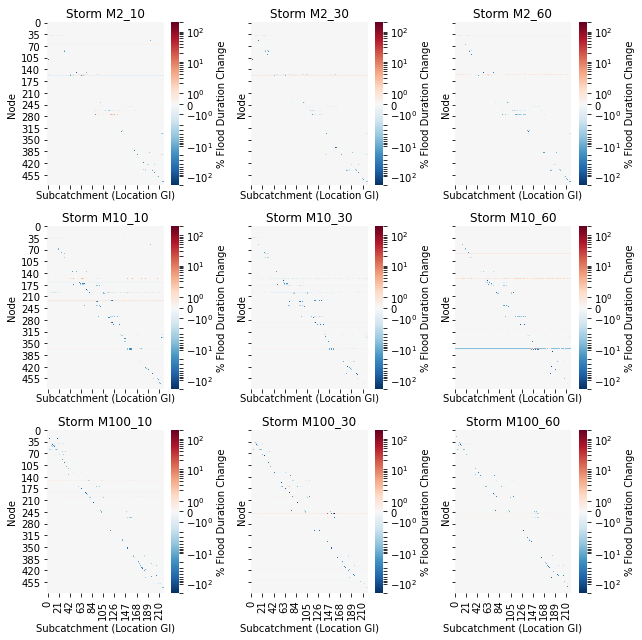

In [63]:
fig,axes=plt.subplots(3,3, figsize=(9,9),sharey=True, sharex=True)
i=0

for ax, s in zip(axes.flat,np.linspace(0,3,10)):
    sns.heatmap(hf[arr[i]],cmap='RdBu_r',center=0,norm=SymLogNorm(2), vmax=200, vmin=-200, ax=ax,cbar_kws={'label':'% Flood Duration Change'})
    ax.set_title(f'Storm {arr[i]}')
    ax.set_xlabel('Subcatchment (Location GI)')
    ax.set_ylabel('Node')
    i=i+1
  

fig.tight_layout()

In [64]:
for i in tqdm(arr):
    for j in tqdm(range(0,220)):
        res[i][j]['%Flood']=flood[i][j]

100%|██████████| 220/220 [00:00<00:00, 8536.76it/s]

100%|██████████| 220/220 [00:00<00:00, 7839.69it/s]

100%|██████████| 220/220 [00:00<00:00, 7309.23it/s]

100%|██████████| 220/220 [00:00<00:00, 13985.04it/s]

100%|██████████| 220/220 [00:00<00:00, 15728.82it/s]

100%|██████████| 220/220 [00:00<00:00, 13682.69it/s]

100%|██████████| 220/220 [00:00<00:00, 17882.00it/s]

100%|██████████| 9/9 [00:00<00:00, 45.51it/s]


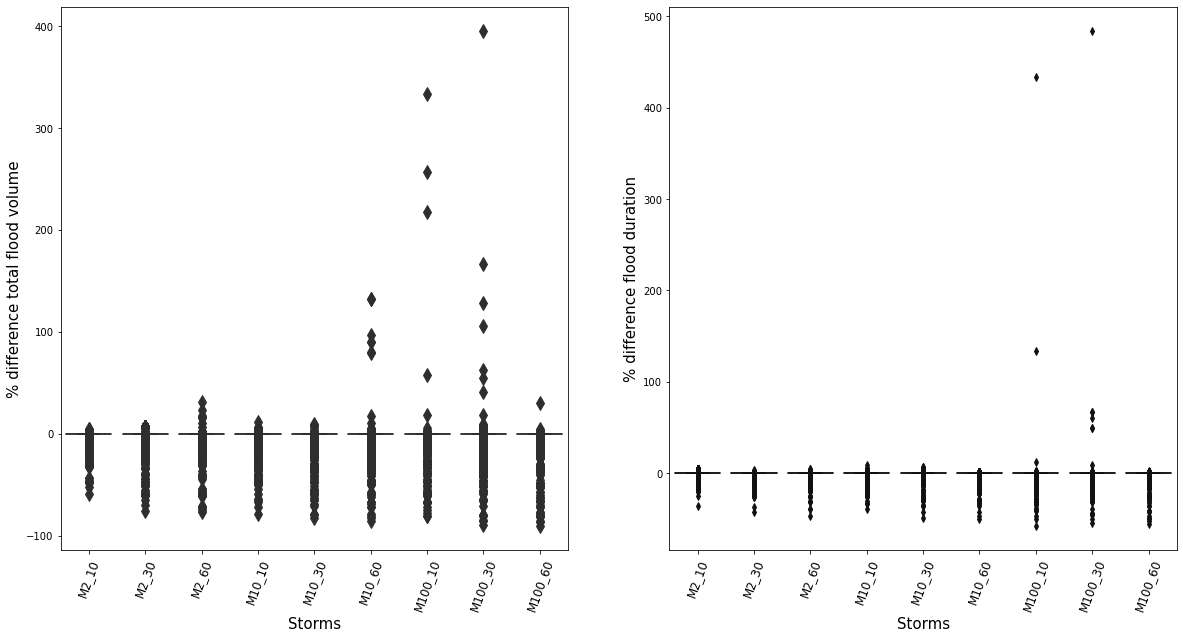

In [65]:
fig, ax =plt.subplots(1,2, figsize=(20,10))

sns.boxplot(x='storm',y='%Flood',data=all_info[all_info['Flood']>10],palette='Blues', ax=ax[0],fliersize=10)
ax[0].set_xlabel('Storms',fontsize=15)
ax[0].set_ylabel('% difference total flood volume',fontsize=15)
ax[0].tick_params(axis="x", labelsize=12, rotation=70)


sns.boxplot(x='storm',y='%HF',data=all_info[all_info['Flood']>15],palette='Greys', ax=ax[1])
ax[1].set_xlabel('Storms',fontsize=15)
ax[1].set_ylabel('% difference flood duration',fontsize=15)
ax[1].tick_params(axis="x", labelsize=12, rotation=70)


In [66]:
floodi=all_info[all_info['Flood']>15].groupby(by='storm')['%Flood'].describe()
floodi=floodi.reindex(arr)
floodi.reset_index(inplace=True)

In [67]:
floodi.round(2)

storm    count  mean   std    min   25%  50%   75%     max
0    M2_10  19574.0 -0.17  1.66 -59.23 -0.02  0.0  0.01    4.69
1    M2_30  23310.0 -0.19  2.26 -76.30 -0.01  0.0  0.01    6.99
2    M2_60  21332.0 -0.15  1.96 -75.07 -0.01  0.0  0.01   17.14
3   M10_10  29904.0 -0.12  1.74 -67.45 -0.01  0.0  0.01   11.03
4   M10_30  31004.0 -0.13  1.94 -79.91 -0.01  0.0  0.01    9.92
5   M10_60  27928.0 -0.18  2.13 -80.96 -0.01  0.0  0.01   17.22
6  M100_10  38923.0 -0.10  2.62 -80.38 -0.00  0.0  0.00  257.24
7  M100_30  38261.0 -0.06  3.09 -85.80 -0.00  0.0  0.01  394.93
8  M100_60  33865.0 -0.11  2.13 -86.53 -0.00  0.0  0.01    4.30

In [68]:
hfi=all_info[all_info['Flood']>15].groupby(by='storm')['%HF'].describe()
hfi=hfi.reindex(arr)
hfi.reset_index(inplace=True)

In [69]:
hfi.round(2)

storm    count  mean   std    min  25%  50%  75%     max
0    M2_10  19574.0 -0.04  0.96 -36.00  0.0  0.0  0.0    4.17
1    M2_30  23310.0 -0.06  0.94 -42.86  0.0  0.0  0.0    3.57
2    M2_60  21332.0 -0.02  0.97 -46.67  0.0  0.0  0.0    4.17
3   M10_10  29904.0 -0.07  1.00 -38.89  0.0  0.0  0.0    9.09
4   M10_30  31004.0 -0.06  0.90 -49.12  0.0  0.0  0.0    6.38
5   M10_60  27928.0 -0.12  1.13 -50.00  0.0  0.0  0.0    1.52
6  M100_10  38923.0 -0.06  2.56 -57.14  0.0  0.0  0.0  433.33
7  M100_30  38261.0 -0.17  3.04 -54.55  0.0  0.0  0.0  483.33
8  M100_60  33865.0 -0.07  1.09 -55.32  0.0  0.0  0.0    2.04

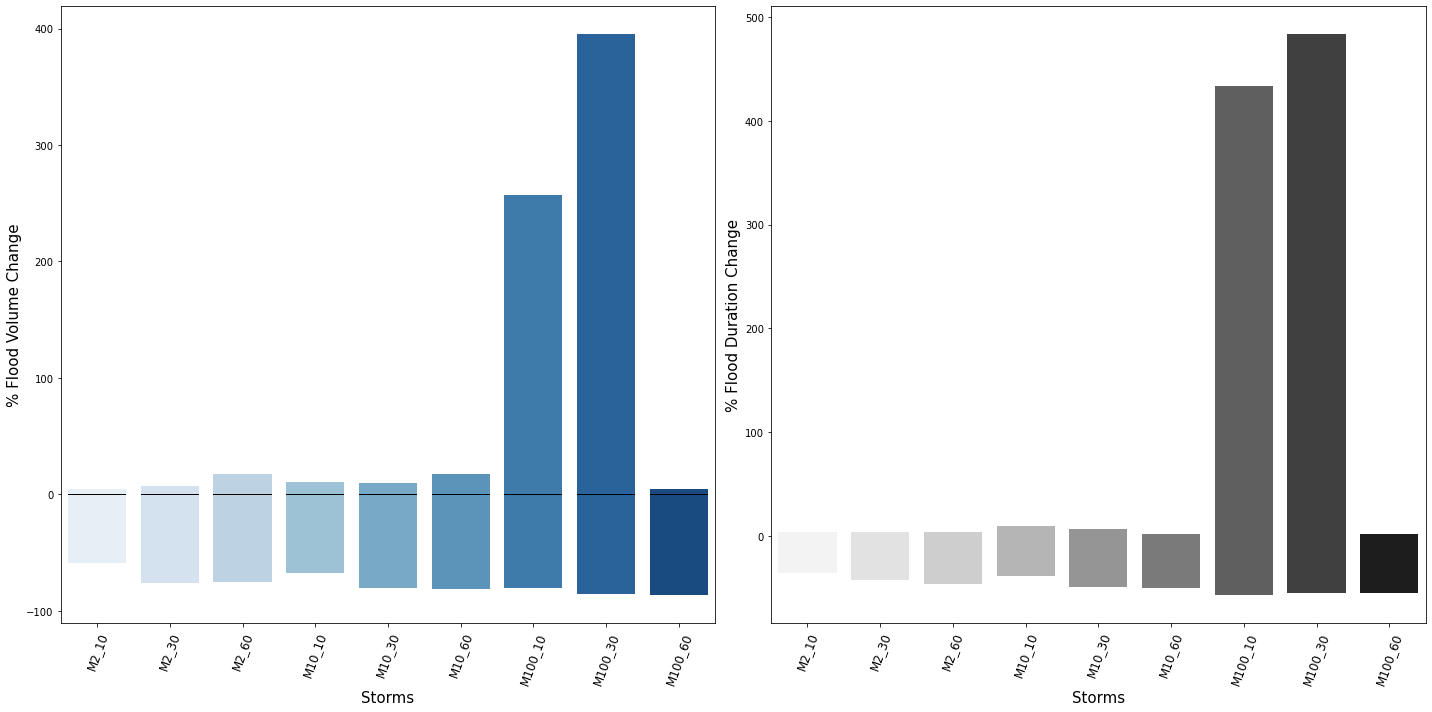

In [70]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

sns.barplot(ax=ax[0], x='storm',y='max',data=floodi,palette='Blues')
sns.barplot(ax=ax[0], x='storm',y='min',data=floodi,palette='Blues')
sns.barplot(ax=ax[0], x='storm',y='mean',data=floodi,color='black')
ax[0].set_ylabel('% Flood Volume Change',fontsize=15)
ax[0].set_xlabel('Storms',fontsize=15)
ax[0].tick_params(axis="x", labelsize=12, rotation=70)



sns.barplot(ax=ax[1], x='storm',y='max',data=hfi,palette='Greys')
sns.barplot(ax=ax[1], x='storm',y='min',data=hfi,palette='Greys')
sns.barplot(ax=ax[1], x='storm',y='mean',data=hfi,color='b')
ax[1].set_ylabel('% Flood Duration Change',fontsize=15)
ax[1].set_xlabel('Storms',fontsize=15)
ax[1].tick_params(axis="x", labelsize=12, rotation=70)

fig.tight_layout()

### AFFECTED NODES

In [71]:
affected_nodes_unchanged=pd.DataFrame()
affected_nodes_reduction=pd.DataFrame()
affected_nodes_increase=pd.DataFrame()

for i in tqdm(arr):
    affected_nodes_unchanged[i]=(flood[i][flood[i]==0].count()/487)*100
    affected_nodes_reduction[i]=(flood[i][flood[i]<0].count()/487)*100
    affected_nodes_increase[i]=(flood[i][flood[i]>0].count()/487)*100

100%|██████████| 9/9 [00:00<00:00, 119.85it/s]


In [72]:
affected_nodes_unchanged_hf=pd.DataFrame()
affected_nodes_reduction_hf=pd.DataFrame()
affected_nodes_increase_hf=pd.DataFrame()

for i in tqdm(arr):
    affected_nodes_unchanged_hf[i]=(hf[i][hf[i]==0].count()/487)*100
    affected_nodes_reduction_hf[i]=(hf[i][hf[i]<0].count()/487)*100
    affected_nodes_increase_hf[i]=(hf[i][hf[i]>0].count()/487)*100

100%|██████████| 9/9 [00:00<00:00, 131.73it/s]


In [73]:
sns.set_style('white')

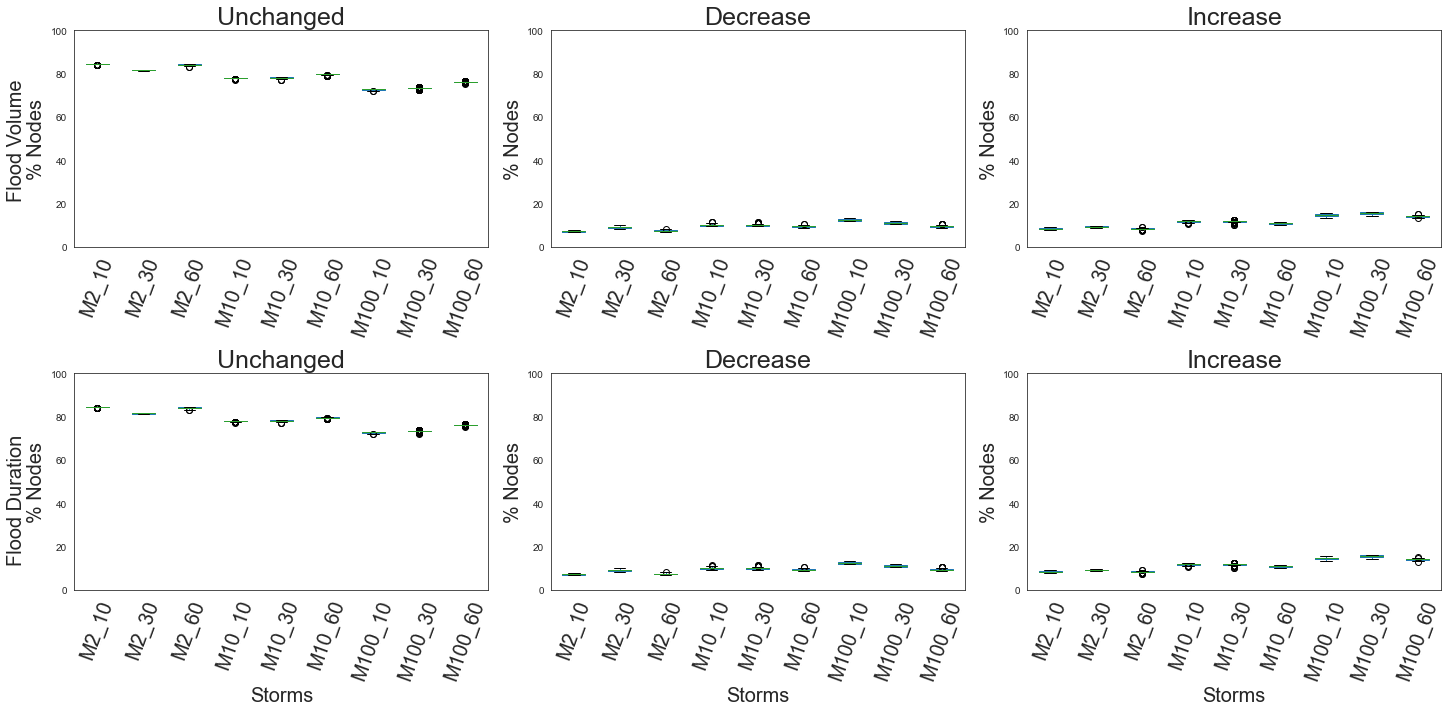

In [80]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

affected_nodes_unchanged.boxplot(ax=ax[0,0],grid=False)

ax[0,0].set_ylabel('% Nodes',fontsize=20)
ax[0,0].tick_params(axis="x", labelsize=20, rotation=70)
ax[0,0].set_ylim([0,100])
ax[0,0].set_title('Unchanged',fontsize=25)

affected_nodes_reduction.boxplot(ax=ax[0,1],grid=False)

ax[0,1].set_ylabel('% Nodes',fontsize=20)
ax[0,1].tick_params(axis="x", labelsize=20, rotation=70)
ax[0,1].set_ylim([0,100])
ax[0,1].set_title('Decrease',fontsize=25)



affected_nodes_increase.boxplot(ax=ax[0,2],grid=False)

ax[0,2].set_ylabel('% Nodes',fontsize=20)
ax[0,2].tick_params(axis="x", labelsize=20, rotation=70)
ax[0,2].set_ylim([0,100])
ax[0,2].set_title('Increase',fontsize=25)


fig.text(0, 0.3, 'Flood Duration', ha='center', va='center', rotation='vertical', fontsize=20)


affected_nodes_unchanged_hf.boxplot(ax=ax[1,0],grid=False)
ax[1,0].set_xlabel('Storms',fontsize=20)
ax[1,0].set_ylabel('% Nodes',fontsize=20)
ax[1,0].tick_params(axis="x", labelsize=20, rotation=70)
ax[1,0].set_ylim([0,100])
ax[1,0].set_title('Unchanged',fontsize=25)

affected_nodes_reduction_hf.boxplot(ax=ax[1,1],grid=False)
ax[1,1].set_xlabel('Storms',fontsize=20)
ax[1,1].set_ylabel('% Nodes',fontsize=20)
ax[1,1].tick_params(axis="x", labelsize=20, rotation=70)
ax[1,1].set_ylim([0,100])
ax[1,1].set_title('Decrease',fontsize=25)

affected_nodes_increase_hf.boxplot(ax=ax[1,2],grid=False)
ax[1,2].set_xlabel('Storms',fontsize=20)
ax[1,2].set_ylabel('% Nodes',fontsize=20)
ax[1,2].tick_params(axis="x", labelsize=20, rotation=70)
ax[1,2].set_ylim([0,100])
ax[1,2].set_title('Increase',fontsize=25)


fig.text(0, 0.8, 'Flood Volume', ha='center', va='center', rotation='vertical', fontsize=20)

fig.tight_layout()

/Users/mayrodriguez/opt/anaconda3/envs/geogeo/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/mayrodriguez/opt/anaconda3/envs/geogeo/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/mayrodriguez/opt/anaconda3/envs/geogeo/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/mayrodriguez/opt/anaconda3/envs/geogeo/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/mayrodriguez/opt/anaconda3/envs/geogeo/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0

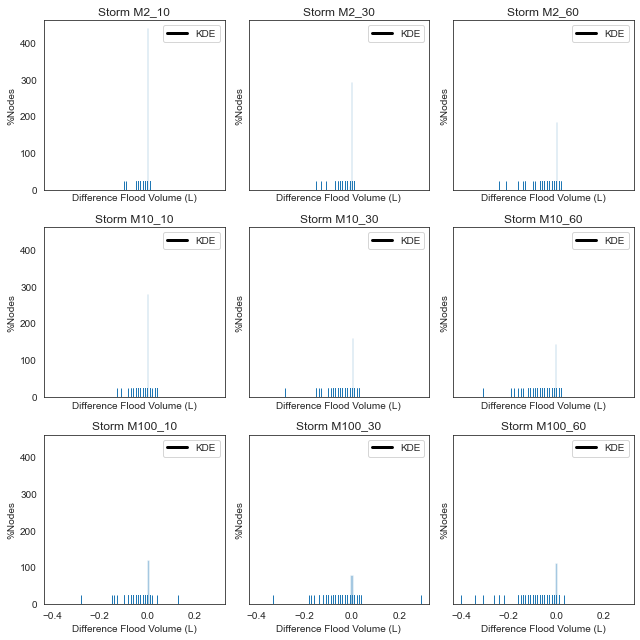

In [75]:
fig, axes=plt.subplots(3,3,sharey=True, sharex=True,figsize=(9,9))
i=0

for ax, s in zip(axes.flat,np.linspace(0,3,10)):
    sns.distplot(res_storm[arr[i]][res_storm[arr[i]]['Flood']>15]['DifHF'], rug=True,kde_kws={"color": "k", "lw": 3, "label": "KDE"},ax=ax)
    ax.set_title(f'Storm {arr[i]}')
    ax.set_xlabel('Difference Flood Volume (L)')
    ax.set_ylabel('%Nodes')
    i=i+1
    
fig.tight_layout()

In [76]:
res_storm['M2_10'].nsmallest(10,'DifFlood')

Name         X        Y  TInflowVolume        Flood  HoursFlooded  \
158  SX96882208  296254.0  88208.0    6376.668175  4770.142067          0.74   
171  SX96882430  296280.0  88499.0    6158.050041   346.259670          0.21   
252  SX96884204  296459.0  88285.0   19354.790994  5529.858066          0.93   
252  SX96884204  296459.0  88285.0   19351.473050  5530.045519          0.93   
171  SX96882430  296280.0  88499.0    6161.800438   354.459748          0.21   
111  SX96880521  296044.0  88573.0    2789.492668   869.454618          1.74   
171  SX96882430  296280.0  88499.0    6170.885134   356.711472          0.22   
252  SX96884204  296459.0  88285.0   19354.447461  5535.428432          0.93   
252  SX96884204  296459.0  88285.0   19355.416850  5536.039725          0.93   
252  SX96884204  296459.0  88285.0   19362.606476  5538.443024          0.93   

          Res  storm  subcat                      geometry     distance  \
158  0.988467  M2_10      44  POINT (296254.000 88208.000)   284.493050   
171  0.999754  M2_10      88  POINT (296280.000 88499.000)    20.518285   
252  0.994464  M2_10     153  POINT (296459.000 88285.000)   895.964763   
252  0.994463  M2_10     158  POINT (296459.000 88285.000)   811.688325   
171  0.999748  M2_10      58  POINT (296280.000 88499.000)   110.853301   
111  0.988701  M2_10      37  POINT (296044.000 88573.000)  1683.606980   
171  0.999735  M2_10      60  POINT (296280.000 88499.000)    16.278821   
252  0.994459  M2_10     105  POINT (296459.000 88285.000)   734.990280   
252  0.994458  M2_10     157  POINT (296459.000 88285.000)   875.886465   
252  0.994458  M2_10     152  POINT (296459.000 88285.000)   928.263796   

     dist_norm    DifFlood  DifHF     %Flood       %HF  
158   0.390188 -146.730494  -0.01  -2.984224 -1.333333  
171   0.023152  -67.555574  -0.01 -16.325057 -4.545455  
252   1.329454  -59.677751   0.00  -1.067669  0.000000  
252   1.322251  -59.490298   0.00  -1.064316  0.000000  
171   0.113842  -59.355496  -0.01 -14.343477 -4.545455  
111   1.763917  -59.298502  -0.02  -6.384743 -1.136364  
171   0.019135  -57.103772   0.00 -13.799340  0.000000  
252   1.317689  -54.107385   0.00  -0.968012  0.000000  
252   1.331862  -53.496092   0.00  -0.957076  0.000000  
252   1.315885  -51.092793   0.00  -0.914079  0.000000

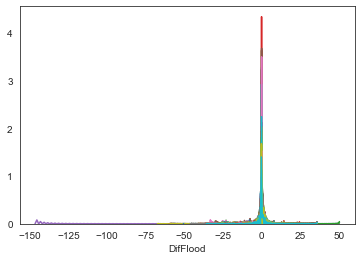

In [77]:
fig, ax=plt.subplots()
for i in range(0,220):
    sns.distplot(res['M2_10'][i][res['M2_10'][i]['Flood']>15]['DifFlood'], hist=False)

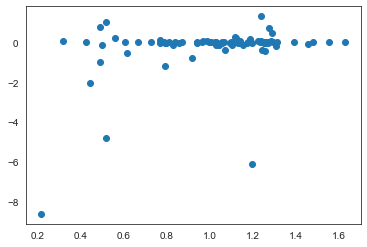

In [78]:

plt.scatter(x=res['M2_10'][i][res['M2_10'][i]['Flood']>15]['dist_norm'],y=res['M2_10'][i][res['M2_10'][i]['Flood']>15]['%Flood'])

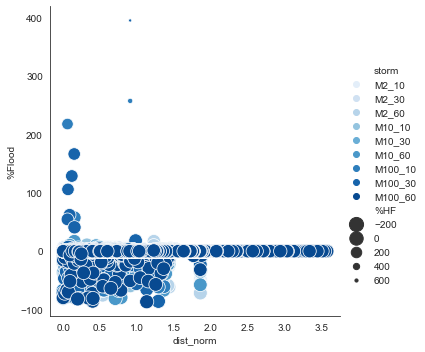

In [79]:
sns.relplot(x='dist_norm',y='%Flood', size='%HF',hue='storm',palette='Blues', sizes=(200, 10),data=all_info[all_info['Flood']>15])

## Location (continues)

Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [84]:
norm_geom=pd.DataFrame()
for i in range(0,220):
    norm_geom[i]=route_geoms[i]/route_geoms[i].mean()

    
    
norm_geom.replace(to_replace=np.inf,value=0,inplace=True)
norm_geom.replace(to_replace=np.nan,value=0,inplace=True)

<ipython-input-87-a31d4dbc1e47>:3: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  sns.heatmap(flood["M100_60"],cmap='RdBu_r',center=0,norm=SymLogNorm(2), vmax=200, vmin=-200, ax=ax[0],cbar_kws={'label':'% Flood Duration Change'})


Text(768.7272727272725, 0.5, 'Node')

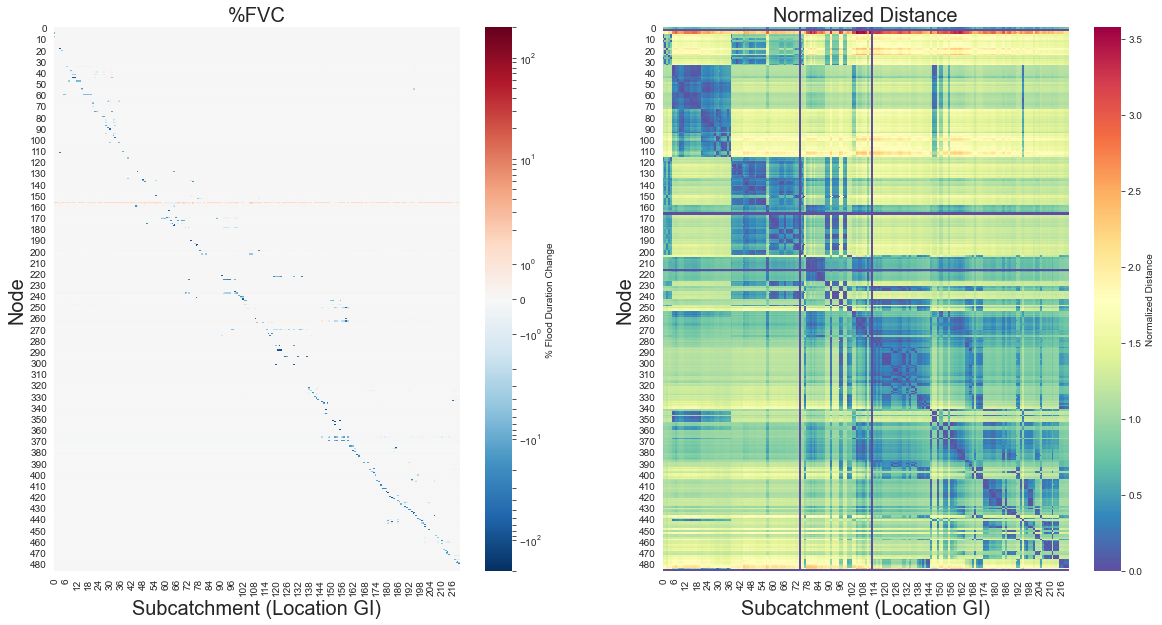

In [87]:
fig,ax=plt.subplots(1,2,figsize=(20,10))

sns.heatmap(flood["M100_60"],cmap='RdBu_r',center=0,norm=SymLogNorm(2), vmax=200, vmin=-200, ax=ax[0],cbar_kws={'label':'% Flood Duration Change'})
ax[0].set_title(f'%FVC',fontsize=20)
ax[0].set_xlabel('Subcatchment (Location GI)', fontsize=20)
ax[0].set_ylabel('Node',fontsize=20)


sns.heatmap(norm_geom,cmap='Spectral_r',ax=ax[1],cbar_kws={'label':'Normalized Distance'})
ax[1].set_title(f'Normalized Distance',fontsize=20)
ax[1].set_xlabel('Subcatchment (Location GI)',fontsize=20)
ax[1].set_ylabel('Node',fontsize=20)

In [335]:
for i in tqdm(arr):
    res_storm[i].reset_index(drop=True,inplace=True)
    for index,row in tqdm(res_storm[i].iterrows()):
        res_storm[i].loc[index,'geometry']=subcat[subcat.index==row['subcat']]['geometry'].values[0]

  0%|          | 0/9 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  9.52it/s]
52it [00:00, 13.50it/s]
116it [00:00, 19.11it/s]
180it [00:00, 26.95it/s]
244it [00:00, 37.81it/s]
306it [00:00, 52.63it/s]
362it [00:00, 72.24it/s]
421it [00:00, 98.04it/s]
482it [00:00, 130.96it/s]
544it [00:01, 171.44it/s]
606it [00:01, 218.81it/s]
672it [00:01, 273.50it/s]
737it [00:01, 330.58it/s]
801it [00:01, 386.66it/s]
865it [00:01, 438.67it/s]
928it [00:01, 481.09it/s]
991it [00:01, 516.54it/s]
1055it [00:01, 546.16it/s]
1118it [00:01, 542.20it/s]
1178it [00:02, 535.45it/s]
1236it [00:02, 532.03it/s]
1294it [00:02, 544.47it/s]
1358it [00:02, 569.74it/s]
1422it [00:02, 587.38it/s]
1486it [00:02, 601.20it/s]
1548it [00:02, 594.47it/s]
1609it [00:02, 588.07it/s]
1669it [00:02, 580.05it/s]
1732it [00:02, 592.11it/s]
1792it [00:03, 592.37it/s]
1852it [00:03, 567.90it/s]
1914it [00:03, 580.54it/s]
1976it [00:03, 589.96it/s]
2041it [00:03, 606.35it/s]
2103it [00:03, 610.04it/s]
2165it [00:03, 604.57it/s]

34228it [00:54, 656.49it/s]
34294it [00:54, 656.11it/s]
34360it [00:54, 650.77it/s]
34426it [00:54, 646.96it/s]
34491it [00:54, 646.29it/s]
34556it [00:55, 645.44it/s]
34621it [00:55, 646.16it/s]
34686it [00:55, 644.82it/s]
34751it [00:55, 645.16it/s]
34816it [00:55, 644.14it/s]
34881it [00:55, 644.22it/s]
34946it [00:55, 643.37it/s]
35011it [00:55, 640.56it/s]
35076it [00:55, 642.79it/s]
35141it [00:55, 643.23it/s]
35206it [00:56, 644.19it/s]
35271it [00:56, 643.33it/s]
35336it [00:56, 643.49it/s]
35401it [00:56, 643.52it/s]
35466it [00:56, 644.25it/s]
35531it [00:56, 644.99it/s]
35596it [00:56, 623.76it/s]
35659it [00:56, 600.52it/s]
35724it [00:56, 613.06it/s]
35789it [00:56, 621.82it/s]
35854it [00:57, 629.13it/s]
35920it [00:57, 635.42it/s]
35986it [00:57, 641.17it/s]
36052it [00:57, 644.24it/s]
36118it [00:57, 647.27it/s]
36184it [00:57, 650.49it/s]
36251it [00:57, 654.69it/s]
36317it [00:57, 655.91it/s]
36384it [00:57, 657.32it/s]
36450it [00:57, 656.05it/s]
36517it [00:58, 657.

68868it [01:48, 654.23it/s]
68935it [01:48, 656.42it/s]
69001it [01:48, 656.14it/s]
69067it [01:48, 655.23it/s]
69133it [01:48, 655.70it/s]
69200it [01:48, 657.00it/s]
69268it [01:48, 662.08it/s]
69335it [01:48, 659.55it/s]
69401it [01:48, 654.78it/s]
69467it [01:49, 652.21it/s]
69533it [01:49, 651.65it/s]
69599it [01:49, 652.79it/s]
69665it [01:49, 651.61it/s]
69731it [01:49, 648.29it/s]
69796it [01:49, 646.25it/s]
69861it [01:49, 644.77it/s]
69926it [01:49, 646.27it/s]
69991it [01:49, 646.27it/s]
70056it [01:49, 646.54it/s]
70121it [01:50, 647.06it/s]
70186it [01:50, 643.70it/s]
70251it [01:50, 645.12it/s]
70317it [01:50, 647.61it/s]
70382it [01:50, 647.10it/s]
70447it [01:50, 645.44it/s]
70512it [01:50, 644.90it/s]
70577it [01:50, 645.79it/s]
70642it [01:50, 646.76it/s]
70707it [01:50, 641.46it/s]
70774it [01:51, 647.60it/s]
70840it [01:51, 650.50it/s]
70907it [01:51, 653.56it/s]
70973it [01:51, 655.18it/s]
71039it [01:51, 655.41it/s]
71105it [01:51, 654.42it/s]
71171it [01:51, 649.

103290it [02:41, 618.47it/s]
103354it [02:41, 622.42it/s]
103420it [02:41, 632.35it/s]
103485it [02:41, 635.97it/s]
103549it [02:41, 629.86it/s]
103613it [02:42, 628.66it/s]
103676it [02:42, 628.89it/s]
103739it [02:42, 629.15it/s]
103803it [02:42, 630.49it/s]
103867it [02:42, 632.03it/s]
103931it [02:42, 631.51it/s]
103995it [02:42, 632.27it/s]
104059it [02:42, 629.71it/s]
104122it [02:42, 624.78it/s]
104185it [02:42, 556.43it/s]
104243it [02:43, 560.59it/s]
104307it [02:43, 582.24it/s]
104372it [02:43, 600.55it/s]
104437it [02:43, 614.38it/s]
104503it [02:43, 625.27it/s]
104567it [02:43, 628.02it/s]
104633it [02:43, 634.72it/s]
104698it [02:43, 638.54it/s]
104763it [02:43, 639.95it/s]
104828it [02:44, 642.72it/s]
104893it [02:44, 643.93it/s]
104958it [02:44, 642.35it/s]
105024it [02:44, 645.38it/s]
105090it [02:44, 647.59it/s]
105156it [02:44, 649.34it/s]
105222it [02:44, 649.71it/s]
105287it [02:44, 647.29it/s]
105352it [02:44, 644.60it/s]
105417it [02:44, 644.80it/s]
105483it [02:4

30872it [00:48, 671.50it/s]
30940it [00:48, 672.37it/s]
31008it [00:48, 672.41it/s]
31077it [00:48, 675.60it/s]
31147it [00:48, 681.85it/s]
31216it [00:48, 670.46it/s]
31284it [00:48, 665.29it/s]
31351it [00:49, 611.46it/s]
31414it [00:49, 579.44it/s]
31473it [00:49, 564.18it/s]
31534it [00:49, 576.95it/s]
31600it [00:49, 599.21it/s]
31666it [00:49, 616.20it/s]
31732it [00:49, 628.37it/s]
31798it [00:49, 636.93it/s]
31864it [00:49, 641.91it/s]
31930it [00:49, 647.10it/s]
31996it [00:50, 649.65it/s]
32063it [00:50, 655.18it/s]
32129it [00:50, 655.72it/s]
32195it [00:50, 656.22it/s]
32261it [00:50, 656.94it/s]
32327it [00:50, 655.16it/s]
32393it [00:50, 654.75it/s]
32459it [00:50, 650.58it/s]
32525it [00:50, 652.38it/s]
32593it [00:50, 657.65it/s]
32659it [00:51, 656.93it/s]
32726it [00:51, 658.19it/s]
32794it [00:51, 662.93it/s]
32861it [00:51, 664.20it/s]
32928it [00:51, 664.41it/s]
32996it [00:51, 667.34it/s]
33064it [00:51, 668.25it/s]
33131it [00:51, 668.57it/s]
33198it [00:51, 663.

64521it [01:43, 643.19it/s]
64586it [01:43, 643.76it/s]
64651it [01:43, 640.38it/s]
64717it [01:43, 643.47it/s]
64783it [01:43, 647.57it/s]
64849it [01:43, 650.39it/s]
64915it [01:43, 651.52it/s]
64981it [01:43, 653.30it/s]
65047it [01:43, 654.01it/s]
65114it [01:44, 656.63it/s]
65180it [01:44, 656.36it/s]
65246it [01:44, 648.73it/s]
65312it [01:44, 650.13it/s]
65378it [01:44, 648.78it/s]
65444it [01:44, 651.83it/s]
65511it [01:44, 654.82it/s]
65577it [01:44, 654.72it/s]
65643it [01:44, 654.47it/s]
65709it [01:44, 655.76it/s]
65775it [01:45, 656.27it/s]
65841it [01:45, 656.66it/s]
65908it [01:45, 658.06it/s]
65974it [01:45, 656.26it/s]
66040it [01:45, 652.96it/s]
66106it [01:45, 653.69it/s]
66172it [01:45, 655.04it/s]
66238it [01:45, 650.94it/s]
66304it [01:45, 651.29it/s]
66370it [01:45, 645.06it/s]
66435it [01:46, 639.23it/s]
66500it [01:46, 642.32it/s]
66565it [01:46, 644.53it/s]
66630it [01:46, 644.28it/s]
66696it [01:46, 648.64it/s]
66762it [01:46, 651.32it/s]
66828it [01:46, 651.

99756it [02:36, 672.30it/s]
99824it [02:36, 670.28it/s]
99892it [02:37, 668.32it/s]
99959it [02:37, 662.98it/s]
100027it [02:37, 666.16it/s]
100095it [02:37, 668.81it/s]
100162it [02:37, 668.56it/s]
100231it [02:37, 672.22it/s]
100299it [02:37, 667.15it/s]
100366it [02:37, 666.59it/s]
100433it [02:37, 664.65it/s]
100500it [02:37, 664.88it/s]
100568it [02:38, 668.69it/s]
100635it [02:38, 660.36it/s]
100702it [02:38, 662.27it/s]
100770it [02:38, 666.57it/s]
100837it [02:38, 664.84it/s]
100905it [02:38, 669.32it/s]
100972it [02:38, 669.33it/s]
101039it [02:38, 668.70it/s]
101106it [02:38, 668.38it/s]
101174it [02:38, 668.57it/s]
101241it [02:39, 615.01it/s]
101307it [02:39, 627.29it/s]
101375it [02:39, 640.05it/s]
101443it [02:39, 649.88it/s]
101512it [02:39, 659.55it/s]
101579it [02:39, 662.27it/s]
101646it [02:39, 663.71it/s]
101713it [02:39, 665.43it/s]
101781it [02:39, 667.12it/s]
101849it [02:39, 668.39it/s]
101916it [02:40, 668.22it/s]
101984it [02:40, 670.49it/s]
102052it [02:40, 6

27640it [00:42, 668.97it/s]
27708it [00:42, 669.52it/s]
27775it [00:42, 666.23it/s]
27843it [00:42, 668.55it/s]
27911it [00:42, 669.62it/s]
27979it [00:43, 671.08it/s]
28047it [00:43, 669.62it/s]
28115it [00:43, 671.10it/s]
28183it [00:43, 671.20it/s]
28251it [00:43, 671.11it/s]
28320it [00:43, 674.35it/s]
28388it [00:43, 674.91it/s]
28457it [00:43, 676.77it/s]
28525it [00:43, 676.77it/s]
28593it [00:43, 676.63it/s]
28661it [00:44, 674.71it/s]
28729it [00:44, 674.62it/s]
28797it [00:44, 674.90it/s]
28865it [00:44, 672.54it/s]
28933it [00:44, 673.09it/s]
29001it [00:44, 672.96it/s]
29069it [00:44, 674.39it/s]
29137it [00:44, 675.10it/s]
29205it [00:44, 671.70it/s]
29273it [00:44, 670.94it/s]
29341it [00:45, 671.26it/s]
29409it [00:45, 665.22it/s]
29476it [00:45, 657.22it/s]
29542it [00:45, 657.88it/s]
29609it [00:45, 659.01it/s]
29677it [00:45, 663.96it/s]
29745it [00:45, 666.61it/s]
29813it [00:45, 670.07it/s]
29881it [00:45, 670.37it/s]
29949it [00:45, 652.72it/s]
30015it [00:46, 654.

63179it [01:36, 670.98it/s]
63247it [01:36, 661.22it/s]
63314it [01:36, 659.52it/s]
63381it [01:36, 662.27it/s]
63448it [01:36, 662.74it/s]
63515it [01:36, 659.46it/s]
63582it [01:36, 660.57it/s]
63650it [01:36, 664.37it/s]
63718it [01:37, 668.84it/s]
63786it [01:37, 670.32it/s]
63854it [01:37, 668.09it/s]
63922it [01:37, 671.15it/s]
63990it [01:37, 668.66it/s]
64058it [01:37, 669.78it/s]
64126it [01:37, 671.79it/s]
64194it [01:37, 659.57it/s]
64261it [01:37, 653.14it/s]
64327it [01:37, 650.37it/s]
64393it [01:38, 652.54it/s]
64459it [01:38, 653.36it/s]
64526it [01:38, 655.50it/s]
64592it [01:38, 656.55it/s]
64659it [01:38, 659.11it/s]
64725it [01:38, 658.77it/s]
64791it [01:38, 658.92it/s]
64857it [01:38, 658.41it/s]
64923it [01:38, 657.27it/s]
64989it [01:38, 657.30it/s]
65057it [01:39, 663.62it/s]
65125it [01:39, 667.07it/s]
65193it [01:39, 670.59it/s]
65261it [01:39, 672.37it/s]
65329it [01:39, 671.58it/s]
65398it [01:39, 674.34it/s]
65466it [01:39, 673.11it/s]
65534it [01:39, 671.

97893it [02:30, 642.67it/s]
97959it [02:30, 646.38it/s]
98025it [02:30, 649.85it/s]
98092it [02:30, 653.77it/s]
98159it [02:30, 655.88it/s]
98226it [02:30, 657.72it/s]
98293it [02:30, 659.68it/s]
98359it [02:30, 658.71it/s]
98425it [02:30, 658.40it/s]
98491it [02:31, 656.01it/s]
98558it [02:31, 658.23it/s]
98625it [02:31, 659.80it/s]
98691it [02:31, 658.10it/s]
98757it [02:31, 658.20it/s]
98823it [02:31, 658.47it/s]
98889it [02:31, 658.25it/s]
98955it [02:31, 656.75it/s]
99022it [02:31, 658.06it/s]
99088it [02:31, 658.54it/s]
99154it [02:32, 654.73it/s]
99220it [02:32, 655.48it/s]
99287it [02:32, 657.77it/s]
99354it [02:32, 658.71it/s]
99421it [02:32, 659.35it/s]
99487it [02:32, 658.55it/s]
99553it [02:32, 656.87it/s]
99619it [02:32, 654.61it/s]
99685it [02:32, 655.57it/s]
99751it [02:32, 653.93it/s]
99817it [02:33, 652.13it/s]
99883it [02:33, 654.23it/s]
99949it [02:33, 652.37it/s]
100015it [02:33, 654.11it/s]
100081it [02:33, 655.20it/s]
100147it [02:33, 655.04it/s]
100213it [02:33, 

25614it [00:39, 528.41it/s]
25678it [00:39, 556.63it/s]
25743it [00:39, 580.37it/s]
25809it [00:39, 599.92it/s]
25875it [00:39, 616.43it/s]
25941it [00:40, 628.36it/s]
26007it [00:40, 636.15it/s]
26073it [00:40, 641.64it/s]
26139it [00:40, 646.93it/s]
26204it [00:40, 643.28it/s]
26269it [00:40, 641.52it/s]
26334it [00:40, 642.87it/s]
26400it [00:40, 646.29it/s]
26465it [00:40, 646.66it/s]
26530it [00:40, 642.92it/s]
26595it [00:41, 644.55it/s]
26661it [00:41, 647.12it/s]
26728it [00:41, 651.39it/s]
26794it [00:41, 652.03it/s]
26860it [00:41, 652.47it/s]
26927it [00:41, 655.14it/s]
26993it [00:41, 654.85it/s]
27059it [00:41, 653.62it/s]
27126it [00:41, 655.73it/s]
27192it [00:41, 655.47it/s]
27258it [00:42, 656.45it/s]
27324it [00:42, 656.21it/s]
27390it [00:42, 656.09it/s]
27456it [00:42, 654.87it/s]
27522it [00:42, 654.71it/s]
27588it [00:42, 655.58it/s]
27654it [00:42, 655.01it/s]
27720it [00:42, 653.86it/s]
27786it [00:42, 653.91it/s]
27852it [00:42, 654.03it/s]
27919it [00:43, 656.

60510it [01:32, 656.95it/s]
60576it [01:33, 656.78it/s]
60642it [01:33, 656.17it/s]
60708it [01:33, 656.14it/s]
60774it [01:33, 656.72it/s]
60840it [01:33, 656.65it/s]
60906it [01:33, 654.29it/s]
60972it [01:33, 653.86it/s]
61038it [01:33, 654.20it/s]
61104it [01:33, 654.68it/s]
61170it [01:33, 654.85it/s]
61236it [01:34, 655.48it/s]
61302it [01:34, 656.47it/s]
61368it [01:34, 657.44it/s]
61434it [01:34, 657.91it/s]
61500it [01:34, 656.93it/s]
61566it [01:34, 657.02it/s]
61632it [01:34, 656.97it/s]
61699it [01:34, 660.20it/s]
61766it [01:34, 660.41it/s]
61833it [01:34, 658.82it/s]
61899it [01:35, 659.09it/s]
61965it [01:35, 657.93it/s]
62031it [01:35, 657.06it/s]
62097it [01:35, 656.60it/s]
62164it [01:35, 658.57it/s]
62230it [01:35, 658.55it/s]
62296it [01:35, 657.99it/s]
62362it [01:35, 656.82it/s]
62428it [01:35, 655.17it/s]
62495it [01:35, 657.49it/s]
62561it [01:36, 656.68it/s]
62628it [01:36, 658.33it/s]
62695it [01:36, 659.74it/s]
62761it [01:36, 659.26it/s]
62827it [01:36, 657.

95503it [02:26, 673.68it/s]
95571it [02:26, 674.77it/s]
95640it [02:26, 676.98it/s]
95708it [02:27, 675.62it/s]
95776it [02:27, 674.86it/s]
95844it [02:27, 675.90it/s]
95912it [02:27, 675.53it/s]
95980it [02:27, 676.31it/s]
96048it [02:27, 674.18it/s]
96116it [02:27, 673.73it/s]
96184it [02:27, 673.13it/s]
96252it [02:27, 672.05it/s]
96320it [02:27, 672.09it/s]
96388it [02:28, 673.87it/s]
96456it [02:28, 674.10it/s]
96524it [02:28, 674.84it/s]
96592it [02:28, 674.61it/s]
96660it [02:28, 675.70it/s]
96728it [02:28, 676.01it/s]
96796it [02:28, 670.85it/s]
96864it [02:28, 670.90it/s]
96932it [02:28, 672.06it/s]
97000it [02:28, 671.26it/s]
97068it [02:29, 669.48it/s]
97135it [02:29, 668.07it/s]
97204it [02:29, 672.23it/s]
97272it [02:29, 670.83it/s]
97341it [02:29, 673.72it/s]
97410it [02:29, 676.83it/s]
97479it [02:29, 678.25it/s]
97547it [02:29, 675.85it/s]
97615it [02:29, 673.30it/s]
97683it [02:29, 675.05it/s]
97751it [02:30, 675.71it/s]
97819it [02:30, 676.83it/s]
97887it [02:30, 676.

23698it [00:36, 665.00it/s]
23766it [00:36, 667.69it/s]
23833it [00:36, 665.73it/s]
23900it [00:36, 666.62it/s]
23968it [00:36, 669.21it/s]
24035it [00:36, 660.23it/s]
24102it [00:36, 662.10it/s]
24169it [00:37, 664.28it/s]
24236it [00:37, 663.91it/s]
24303it [00:37, 663.70it/s]
24371it [00:37, 665.97it/s]
24439it [00:37, 668.47it/s]
24507it [00:37, 669.95it/s]
24575it [00:37, 670.35it/s]
24643it [00:37, 670.24it/s]
24711it [00:37, 666.19it/s]
24778it [00:37, 665.47it/s]
24846it [00:38, 667.22it/s]
24914it [00:38, 670.40it/s]
24982it [00:38, 672.44it/s]
25050it [00:38, 671.81it/s]
25118it [00:38, 667.61it/s]
25185it [00:38, 663.15it/s]
25253it [00:38, 667.35it/s]
25321it [00:38, 670.98it/s]
25389it [00:38, 673.49it/s]
25457it [00:38, 672.53it/s]
25525it [00:39, 672.87it/s]
25593it [00:39, 670.73it/s]
25661it [00:39, 669.34it/s]
25728it [00:39, 669.03it/s]
25796it [00:39, 671.02it/s]
25864it [00:39, 668.55it/s]
25931it [00:39, 668.53it/s]
25999it [00:39, 671.05it/s]
26067it [00:39, 672.

58927it [01:29, 655.88it/s]
58994it [01:30, 657.56it/s]
59061it [01:30, 658.46it/s]
59127it [01:30, 658.47it/s]
59193it [01:30, 657.16it/s]
59259it [01:30, 656.50it/s]
59325it [01:30, 656.62it/s]
59393it [01:30, 661.10it/s]
59461it [01:30, 664.82it/s]
59529it [01:30, 667.30it/s]
59597it [01:30, 668.58it/s]
59665it [01:31, 671.93it/s]
59733it [01:31, 672.55it/s]
59802it [01:31, 675.95it/s]
59870it [01:31, 675.08it/s]
59938it [01:31, 673.82it/s]
60006it [01:31, 674.23it/s]
60074it [01:31, 673.53it/s]
60142it [01:31, 673.09it/s]
60210it [01:31, 671.41it/s]
60278it [01:31, 669.75it/s]
60345it [01:32, 665.31it/s]
60412it [01:32, 666.39it/s]
60479it [01:32, 663.93it/s]
60546it [01:32, 664.93it/s]
60613it [01:32, 659.40it/s]
60679it [01:32, 656.48it/s]
60745it [01:32, 649.89it/s]
60811it [01:32, 646.32it/s]
60876it [01:32, 644.07it/s]
60942it [01:32, 646.77it/s]
61008it [01:33, 650.52it/s]
61074it [01:33, 647.31it/s]
61139it [01:33, 645.83it/s]
61204it [01:33, 645.10it/s]
61270it [01:33, 647.

94086it [02:23, 656.52it/s]
94153it [02:23, 657.74it/s]
94219it [02:23, 657.18it/s]
94285it [02:23, 657.21it/s]
94351it [02:23, 656.40it/s]
94417it [02:24, 654.50it/s]
94483it [02:24, 655.96it/s]
94550it [02:24, 657.30it/s]
94617it [02:24, 658.68it/s]
94683it [02:24, 658.35it/s]
94749it [02:24, 657.66it/s]
94815it [02:24, 656.78it/s]
94881it [02:24, 654.32it/s]
94947it [02:24, 652.19it/s]
95013it [02:24, 653.38it/s]
95079it [02:25, 654.99it/s]
95146it [02:25, 656.87it/s]
95212it [02:25, 657.28it/s]
95278it [02:25, 657.58it/s]
95344it [02:25, 655.70it/s]
95410it [02:25, 656.37it/s]
95476it [02:25, 656.63it/s]
95543it [02:25, 658.23it/s]
95609it [02:25, 656.40it/s]
95675it [02:26, 655.72it/s]
95741it [02:26, 656.99it/s]
95807it [02:26, 655.98it/s]
95873it [02:26, 647.28it/s]
95940it [02:26, 651.59it/s]
96007it [02:26, 655.76it/s]
96074it [02:26, 659.24it/s]
96140it [02:26, 659.05it/s]
96206it [02:26, 655.32it/s]
96272it [02:26, 653.51it/s]
96338it [02:27, 653.86it/s]
96404it [02:27, 654.

21393it [00:33, 625.88it/s]
21457it [00:33, 628.25it/s]
21520it [00:33, 628.54it/s]
21583it [00:33, 625.93it/s]
21646it [00:34, 625.78it/s]
21709it [00:34, 625.94it/s]
21772it [00:34, 626.84it/s]
21836it [00:34, 628.13it/s]
21899it [00:34, 627.13it/s]
21962it [00:34, 626.36it/s]
22025it [00:34, 626.15it/s]
22088it [00:34, 627.09it/s]
22151it [00:34, 623.82it/s]
22214it [00:34, 625.27it/s]
22278it [00:35, 626.91it/s]
22341it [00:35, 626.82it/s]
22405it [00:35, 628.14it/s]
22468it [00:35, 627.32it/s]
22531it [00:35, 626.04it/s]
22594it [00:35, 625.97it/s]
22657it [00:35, 623.87it/s]
22720it [00:35, 624.68it/s]
22784it [00:35, 626.62it/s]
22847it [00:35, 625.55it/s]
22910it [00:36, 626.70it/s]
22973it [00:36, 627.60it/s]
23036it [00:36, 627.48it/s]
23099it [00:36, 625.27it/s]
23162it [00:36, 625.60it/s]
23225it [00:36, 626.66it/s]
23288it [00:36, 626.63it/s]
23351it [00:36, 627.34it/s]
23414it [00:36, 625.71it/s]
23477it [00:36, 625.53it/s]
23540it [00:37, 626.48it/s]
23603it [00:37, 624.

53565it [01:28, 489.77it/s]
53615it [01:28, 457.69it/s]
53662it [01:28, 439.24it/s]
53718it [01:28, 469.60it/s]
53767it [01:28, 472.46it/s]
53815it [01:29, 457.14it/s]
53862it [01:29, 425.11it/s]
53912it [01:29, 442.91it/s]
53969it [01:29, 472.43it/s]
54022it [01:29, 486.38it/s]
54084it [01:29, 519.43it/s]
54147it [01:29, 546.84it/s]
54207it [01:29, 560.66it/s]
54265it [01:29, 487.01it/s]
54317it [01:30, 462.91it/s]
54375it [01:30, 492.59it/s]
54439it [01:30, 527.81it/s]
54501it [01:30, 551.94it/s]
54563it [01:30, 569.33it/s]
54624it [01:30, 580.18it/s]
54683it [01:30, 544.06it/s]
54739it [01:30, 510.63it/s]
54792it [01:30, 484.77it/s]
54842it [01:31, 478.18it/s]
54895it [01:31, 492.16it/s]
54956it [01:31, 521.94it/s]
55019it [01:31, 548.89it/s]
55078it [01:31, 559.85it/s]
55141it [01:31, 577.24it/s]
55204it [01:31, 591.03it/s]
55266it [01:31, 596.84it/s]
55329it [01:31, 605.13it/s]
55391it [01:31, 606.22it/s]
55452it [01:32, 584.49it/s]
55511it [01:32, 542.99it/s]
55567it [01:32, 518.

85397it [02:24, 529.83it/s]
85451it [02:24, 530.61it/s]
85505it [02:24, 524.32it/s]
85560it [02:24, 530.51it/s]
85614it [02:24, 524.87it/s]
85667it [02:24, 524.22it/s]
85720it [02:24, 522.91it/s]
85773it [02:25, 517.21it/s]
85825it [02:25, 510.05it/s]
85878it [02:25, 514.72it/s]
85930it [02:25, 504.69it/s]
85982it [02:25, 509.18it/s]
86034it [02:25, 511.04it/s]
86086it [02:25, 480.90it/s]
86140it [02:25, 495.78it/s]
86190it [02:25, 472.99it/s]
86243it [02:26, 488.68it/s]
86299it [02:26, 507.39it/s]
86351it [02:26, 478.12it/s]
86400it [02:26, 466.33it/s]
86448it [02:26, 452.28it/s]
86494it [02:26, 452.79it/s]
86543it [02:26, 463.07it/s]
86590it [02:26, 445.23it/s]
86635it [02:26, 446.02it/s]
86681it [02:26, 448.70it/s]
86732it [02:27, 464.48it/s]
86779it [02:27, 445.82it/s]
86824it [02:27, 417.94it/s]
86867it [02:27, 408.04it/s]
86909it [02:27, 402.25it/s]
86955it [02:27, 416.80it/s]
87007it [02:27, 443.17it/s]
87060it [02:27, 464.97it/s]
87118it [02:27, 492.72it/s]
87181it [02:28, 525.

11587it [00:17, 653.84it/s]
11653it [00:18, 652.44it/s]
11719it [00:18, 649.44it/s]
11784it [00:18, 645.83it/s]
11849it [00:18, 635.77it/s]
11914it [00:18, 639.81it/s]
11980it [00:18, 644.78it/s]
12046it [00:18, 648.41it/s]
12112it [00:18, 650.48it/s]
12178it [00:18, 653.17it/s]
12245it [00:18, 656.14it/s]
12311it [00:19, 655.46it/s]
12377it [00:19, 656.17it/s]
12445it [00:19, 660.16it/s]
12512it [00:19, 657.32it/s]
12579it [00:19, 658.60it/s]
12646it [00:19, 660.12it/s]
12713it [00:19, 661.56it/s]
12781it [00:19, 665.01it/s]
12848it [00:19, 661.60it/s]
12915it [00:19, 662.88it/s]
12982it [00:20, 663.35it/s]
13049it [00:20, 659.38it/s]
13117it [00:20, 661.92it/s]
13184it [00:20, 658.55it/s]
13250it [00:20, 652.81it/s]
13316it [00:20, 647.90it/s]
13381it [00:20, 642.55it/s]
13446it [00:20, 641.68it/s]
13511it [00:20, 637.39it/s]
13575it [00:20, 635.39it/s]
13639it [00:21, 634.29it/s]
13704it [00:21, 636.91it/s]
13769it [00:21, 638.29it/s]
13836it [00:21, 645.51it/s]
13902it [00:21, 649.

45592it [01:12, 659.43it/s]
45659it [01:12, 661.85it/s]
45726it [01:12, 659.73it/s]
45793it [01:12, 662.50it/s]
45860it [01:12, 658.38it/s]
45927it [01:12, 659.46it/s]
45993it [01:12, 658.44it/s]
46060it [01:12, 661.31it/s]
46127it [01:12, 648.71it/s]
46193it [01:12, 649.77it/s]
46259it [01:13, 651.76it/s]
46325it [01:13, 652.52it/s]
46392it [01:13, 655.84it/s]
46458it [01:13, 654.68it/s]
46525it [01:13, 656.51it/s]
46591it [01:13, 646.56it/s]
46657it [01:13, 648.92it/s]
46724it [01:13, 652.90it/s]
46791it [01:13, 657.49it/s]
46858it [01:13, 658.38it/s]
46925it [01:14, 659.25it/s]
46992it [01:14, 659.89it/s]
47059it [01:14, 662.30it/s]
47126it [01:14, 663.04it/s]
47193it [01:14, 664.26it/s]
47261it [01:14, 666.33it/s]
47328it [01:14, 666.62it/s]
47395it [01:14, 666.77it/s]
47462it [01:14, 667.11it/s]
47529it [01:14, 666.53it/s]
47596it [01:15, 654.50it/s]
47662it [01:15, 652.80it/s]
47729it [01:15, 655.01it/s]
47795it [01:15, 656.33it/s]
47862it [01:15, 657.65it/s]
47928it [01:15, 657.

79616it [02:06, 557.33it/s]
79673it [02:06, 560.59it/s]
79739it [02:06, 586.23it/s]
79800it [02:06, 591.90it/s]
79860it [02:06, 561.21it/s]
79917it [02:06, 500.82it/s]
79970it [02:06, 507.02it/s]
80033it [02:06, 538.19it/s]
80097it [02:06, 564.08it/s]
80155it [02:07, 557.80it/s]
80221it [02:07, 584.68it/s]
80284it [02:07, 596.63it/s]
80349it [02:07, 611.65it/s]
80414it [02:07, 620.87it/s]
80480it [02:07, 631.24it/s]
80544it [02:07, 633.59it/s]
80610it [02:07, 640.25it/s]
80675it [02:07, 640.07it/s]
80740it [02:07, 636.43it/s]
80804it [02:08, 637.28it/s]
80870it [02:08, 643.47it/s]
80937it [02:08, 651.02it/s]
81003it [02:08, 652.88it/s]
81069it [02:08, 654.10it/s]
81135it [02:08, 598.47it/s]
81199it [02:08, 609.62it/s]
81265it [02:08, 621.95it/s]
81329it [02:08, 626.82it/s]
81394it [02:09, 633.18it/s]
81459it [02:09, 636.75it/s]
81524it [02:09, 640.24it/s]
81589it [02:09, 641.29it/s]
81654it [02:09, 642.63it/s]
81720it [02:09, 647.65it/s]
81788it [02:09, 654.56it/s]
81854it [02:09, 646.

6683it [00:10, 646.70it/s]
6750it [00:10, 651.66it/s]
6818it [00:10, 658.09it/s]
6886it [00:10, 662.03it/s]
6953it [00:10, 659.46it/s]
7019it [00:10, 659.57it/s]
7085it [00:10, 657.61it/s]
7152it [00:10, 659.41it/s]
7219it [00:11, 659.79it/s]
7285it [00:11, 657.70it/s]
7351it [00:11, 655.96it/s]
7418it [00:11, 659.30it/s]
7484it [00:11, 658.30it/s]
7550it [00:11, 656.98it/s]
7617it [00:11, 659.52it/s]
7683it [00:11, 659.17it/s]
7750it [00:11, 661.56it/s]
7817it [00:11, 660.27it/s]
7884it [00:12, 660.07it/s]
7951it [00:12, 661.69it/s]
8018it [00:12, 656.58it/s]
8084it [00:12, 656.31it/s]
8151it [00:12, 658.13it/s]
8217it [00:12, 655.46it/s]
8284it [00:12, 658.96it/s]
8351it [00:12, 661.05it/s]
8418it [00:12, 658.28it/s]
8484it [00:12, 658.55it/s]
8550it [00:13, 652.90it/s]
8617it [00:13, 655.66it/s]
8684it [00:13, 657.58it/s]
8751it [00:13, 659.59it/s]
8818it [00:13, 660.25it/s]
8885it [00:13, 660.18it/s]
8952it [00:13, 657.76it/s]
9018it [00:13, 657.86it/s]
9084it [00:13, 654.60it/s]
9

41088it [01:04, 655.29it/s]
41155it [01:04, 657.15it/s]
41221it [01:04, 653.94it/s]
41288it [01:04, 657.77it/s]
41355it [01:04, 659.14it/s]
41421it [01:04, 655.36it/s]
41488it [01:04, 658.07it/s]
41555it [01:05, 659.42it/s]
41622it [01:05, 662.32it/s]
41689it [01:05, 664.31it/s]
41756it [01:05, 655.79it/s]
41822it [01:05, 656.32it/s]
41889it [01:05, 659.91it/s]
41956it [01:05, 659.36it/s]
42022it [01:05, 659.20it/s]
42089it [01:05, 661.07it/s]
42156it [01:05, 661.31it/s]
42223it [01:06, 662.86it/s]
42290it [01:06, 661.93it/s]
42357it [01:06, 663.34it/s]
42424it [01:06, 658.92it/s]
42490it [01:06, 657.87it/s]
42556it [01:06, 656.58it/s]
42622it [01:06, 646.78it/s]
42687it [01:06, 646.92it/s]
42753it [01:06, 650.37it/s]
42820it [01:06, 655.42it/s]
42886it [01:07, 647.39it/s]
42953it [01:07, 651.54it/s]
43019it [01:07, 653.08it/s]
43086it [01:07, 657.37it/s]
43153it [01:07, 659.51it/s]
43219it [01:07, 659.46it/s]
43286it [01:07, 659.80it/s]
43353it [01:07, 661.54it/s]
43420it [01:07, 661.

75153it [01:58, 660.56it/s]
75220it [01:58, 661.83it/s]
75287it [01:58, 664.11it/s]
75354it [01:58, 663.22it/s]
75421it [01:58, 658.89it/s]
75487it [01:58, 656.83it/s]
75554it [01:59, 658.60it/s]
75621it [01:59, 659.88it/s]
75688it [01:59, 661.75it/s]
75755it [01:59, 659.12it/s]
75822it [01:59, 660.04it/s]
75889it [01:59, 660.98it/s]
75956it [01:59, 661.53it/s]
76023it [01:59, 661.89it/s]
76090it [01:59, 662.80it/s]
76157it [02:00, 660.35it/s]
76225it [02:00, 664.74it/s]
76292it [02:00, 664.90it/s]
76359it [02:00, 662.80it/s]
76427it [02:00, 665.22it/s]
76494it [02:00, 662.04it/s]
76561it [02:00, 659.41it/s]
76629it [02:00, 664.29it/s]
76696it [02:00, 661.11it/s]
76764it [02:00, 664.83it/s]
76832it [02:01, 667.08it/s]
76899it [02:01, 663.24it/s]
76967it [02:01, 665.43it/s]
77034it [02:01, 662.14it/s]
77101it [02:01, 662.44it/s]
77168it [02:01, 658.06it/s]
77234it [02:01, 652.83it/s]
77301it [02:01, 656.16it/s]
77368it [02:01, 658.34it/s]
77434it [02:01, 653.40it/s]
77500it [02:02, 655.

2563it [00:03, 665.18it/s]
2630it [00:04, 663.33it/s]
2697it [00:04, 664.05it/s]
2764it [00:04, 665.13it/s]
2831it [00:04, 660.21it/s]
2898it [00:04, 660.96it/s]
2965it [00:04, 658.57it/s]
3031it [00:04, 655.81it/s]
3098it [00:04, 659.08it/s]
3164it [00:04, 658.61it/s]
3232it [00:04, 663.15it/s]
3299it [00:05, 654.14it/s]
3365it [00:05, 646.11it/s]
3432it [00:05, 651.79it/s]
3499it [00:05, 656.30it/s]
3566it [00:05, 657.91it/s]
3634it [00:05, 663.37it/s]
3702it [00:05, 665.76it/s]
3769it [00:05, 662.69it/s]
3837it [00:05, 664.76it/s]
3904it [00:05, 661.77it/s]
3971it [00:06, 650.70it/s]
4037it [00:06, 649.20it/s]
4102it [00:06, 643.57it/s]
4167it [00:06, 641.81it/s]
4232it [00:06, 640.29it/s]
4297it [00:06, 636.48it/s]
4362it [00:06, 637.85it/s]
4426it [00:06, 633.04it/s]
4491it [00:06, 635.62it/s]
4559it [00:07, 647.94it/s]
4625it [00:07, 650.61it/s]
4691it [00:07, 644.77it/s]
4758it [00:07, 650.70it/s]
4824it [00:07, 651.26it/s]
4890it [00:07, 652.50it/s]
4957it [00:07, 655.49it/s]
5

37500it [00:58, 653.91it/s]
37566it [00:58, 651.56it/s]
37632it [00:58, 651.17it/s]
37698it [00:58, 653.54it/s]
37764it [00:58, 651.54it/s]
37830it [00:58, 653.02it/s]
37896it [00:58, 652.62it/s]
37962it [00:58, 652.81it/s]
38028it [00:58, 654.33it/s]
38094it [00:58, 652.76it/s]
38160it [00:59, 652.48it/s]
38227it [00:59, 655.70it/s]
38293it [00:59, 654.60it/s]
38359it [00:59, 639.71it/s]
38425it [00:59, 643.93it/s]
38490it [00:59, 643.92it/s]
38556it [00:59, 648.00it/s]
38622it [00:59, 648.96it/s]
38687it [00:59, 648.61it/s]
38753it [00:59, 650.46it/s]
38819it [01:00, 651.57it/s]
38885it [01:00, 652.61it/s]
38951it [01:00, 652.19it/s]
39017it [01:00, 649.68it/s]
39083it [01:00, 652.45it/s]
39149it [01:00, 653.65it/s]
39215it [01:00, 639.80it/s]
39280it [01:00, 605.44it/s]
39343it [01:00, 612.59it/s]
39408it [01:01, 622.77it/s]
39474it [01:01, 631.06it/s]
39539it [01:01, 635.44it/s]
39605it [01:01, 642.12it/s]
39671it [01:01, 645.82it/s]
39736it [01:01, 645.63it/s]
39801it [01:01, 645.

71535it [01:52, 660.04it/s]
71602it [01:52, 652.94it/s]
71668it [01:52, 653.81it/s]
71735it [01:52, 657.31it/s]
71801it [01:52, 658.09it/s]
71867it [01:52, 655.70it/s]
71933it [01:52, 652.09it/s]
71999it [01:52, 638.27it/s]
72063it [01:52, 629.26it/s]
72127it [01:53, 629.08it/s]
72190it [01:53, 615.82it/s]
72252it [01:53, 595.95it/s]
72312it [01:53, 577.82it/s]
72374it [01:53, 589.00it/s]
72439it [01:53, 604.27it/s]
72505it [01:53, 617.92it/s]
72572it [01:53, 631.67it/s]
72639it [01:53, 641.06it/s]
72707it [01:53, 650.05it/s]
72773it [01:54, 652.91it/s]
72839it [01:54, 653.71it/s]
72906it [01:54, 656.90it/s]
72973it [01:54, 660.47it/s]
73040it [01:54, 655.93it/s]
73108it [01:54, 660.71it/s]
73175it [01:54, 657.86it/s]
73241it [01:54, 653.64it/s]
73308it [01:54, 657.13it/s]
73375it [01:54, 657.75it/s]
73441it [01:55, 652.16it/s]
73508it [01:55, 657.26it/s]
73575it [01:55, 659.21it/s]
73642it [01:55, 661.05it/s]
73710it [01:55, 665.56it/s]
73777it [01:55, 664.49it/s]
73844it [01:55, 665.

105369it [02:46, 649.76it/s]
105435it [02:46, 652.36it/s]
105501it [02:46, 654.15it/s]
105567it [02:46, 654.27it/s]
105633it [02:46, 652.78it/s]
105699it [02:46, 652.17it/s]
105765it [02:46, 650.07it/s]
105831it [02:46, 650.14it/s]
105897it [02:47, 650.92it/s]
105963it [02:47, 651.91it/s]
106029it [02:47, 652.29it/s]
106095it [02:47, 647.71it/s]
106161it [02:47, 650.88it/s]
106227it [02:47, 651.30it/s]
106293it [02:47, 651.57it/s]
106360it [02:47, 655.82it/s]
106427it [02:47, 659.75it/s]
106494it [02:47, 660.22it/s]
106561it [02:48, 660.79it/s]
106628it [02:48, 663.00it/s]
106695it [02:48, 657.90it/s]
106761it [02:48, 635.44it/s]
106825it [02:48, 636.26it/s]
106889it [02:48, 613.69it/s]
106951it [02:48, 552.38it/s]
107008it [02:48, 555.81it/s]
107074it [02:48, 581.79it/s]
107140it [02:49, 633.92it/s]
100%|██████████| 9/9 [25:14<00:00, 168.33s/it]


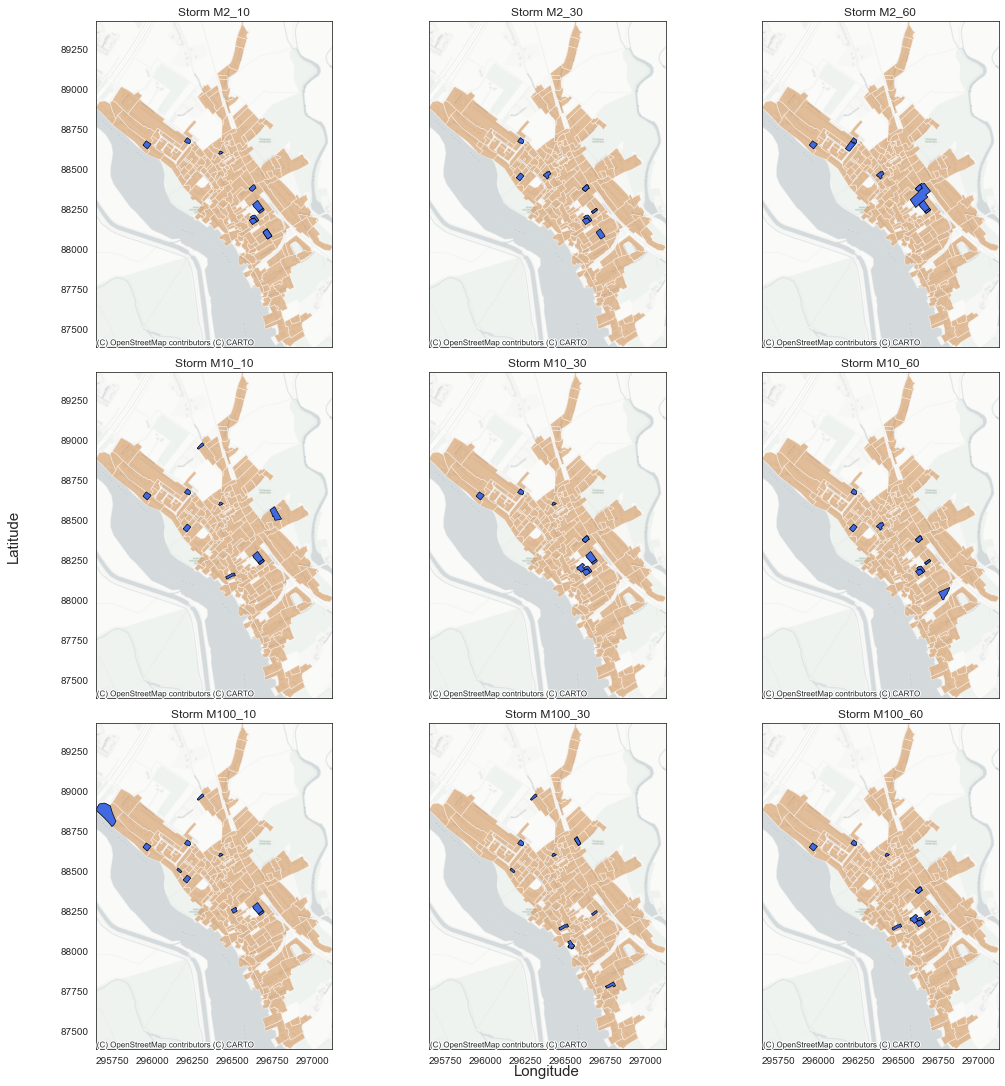

In [366]:
fig, axes=plt.subplots(3,3, sharey=True, sharex=True,figsize=(15,15))
i=0

for ax, s in zip(axes.flat,np.linspace(0,3,10)):
    subcat.plot(ax=ax,edgecolor='white',linewidth=0.7,color='peru',alpha=0.5)
    res_storm[arr[i]].nsmallest(10,"DifHF").plot(ax=ax,edgecolor='black',scheme='FisherJenks', k=9, color='royalblue',linewidth=0.7)
    # nodes.plot(ax=ax,color='black',markersize=3)
    # links.plot(ax=ax,color='black',linewidth=0.5)

    ax.set_ylim([latmin,latmax])
    ax.set_xlim([lonmin,lonmax])
    
    ax.set_title(f'Storm {arr[i]}')

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:27700')
    
    i=i+1

fig.text(0.5, 0, 'Longitude', ha='center',fontsize=15)
fig.text(0, 0.5, 'Latitude', va='center', rotation='vertical',fontsize=15)

fig.tight_layout()

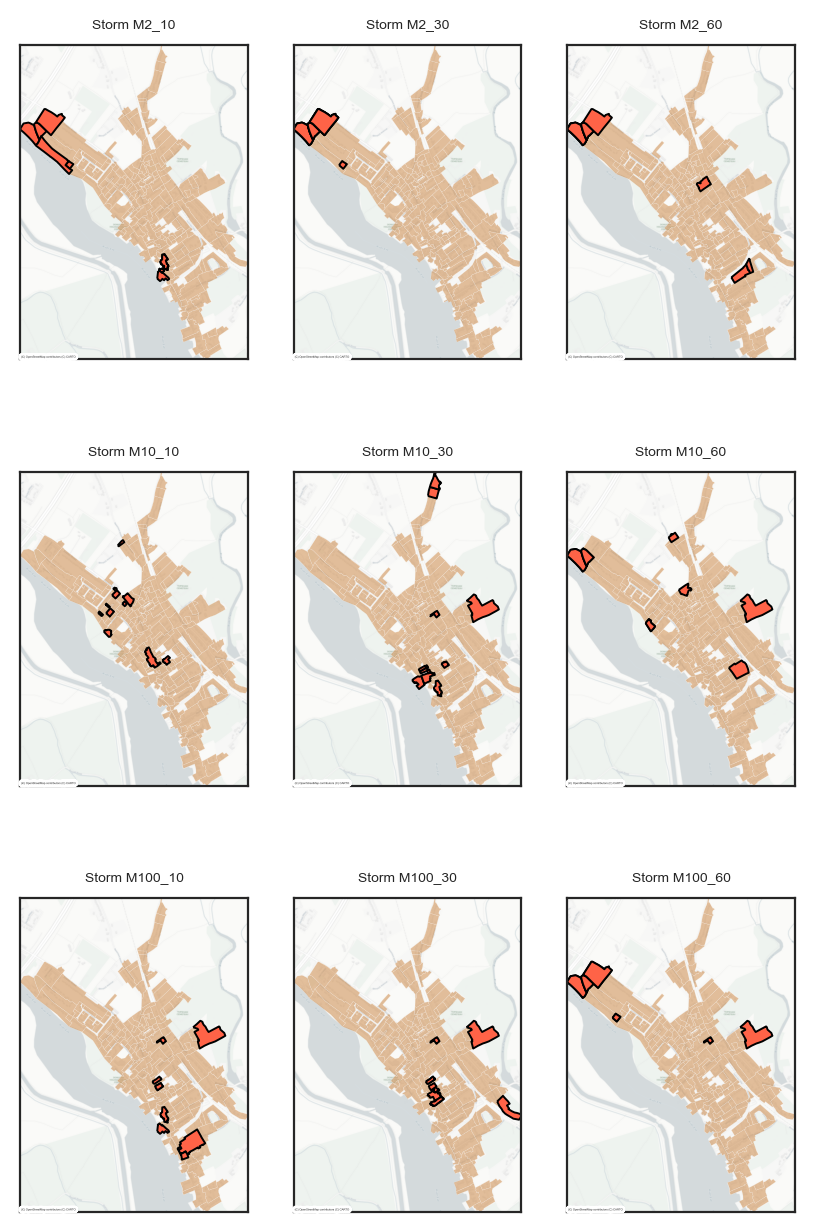

In [378]:
fig, axes=plt.subplots(3,3, sharey=True, sharex=True,figsize=(5,8),dpi=200)
i=0

for ax, s in zip(axes.flat,np.linspace(0,3,10)):
    subcat.plot(ax=ax,edgecolor='white',linewidth=0.1,color='peru',alpha=0.5)
    res_storm[arr[i]].nlargest(10,'DifHF').plot(ax=ax,edgecolor='black',scheme='FisherJenks', k=9, color='tomato',linewidth=0.7)
    # nodes.plot(ax=ax,color='black',markersize=3)
    # links.plot(ax=ax,color='black',linewidth=0.5)

    ax.set_ylim([latmin,latmax])
    ax.set_xlim([lonmin,lonmax])
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(f'Storm {arr[i]}', fontsize=5)

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:27700', attribution_size=.1)
    
    i=i+1

# fig.text(0.5, 0, 'Longitude', ha='center')
# fig.text(0, 0.5, 'Latitude', va='center', rotation='vertical')

# fig.tight_layout()

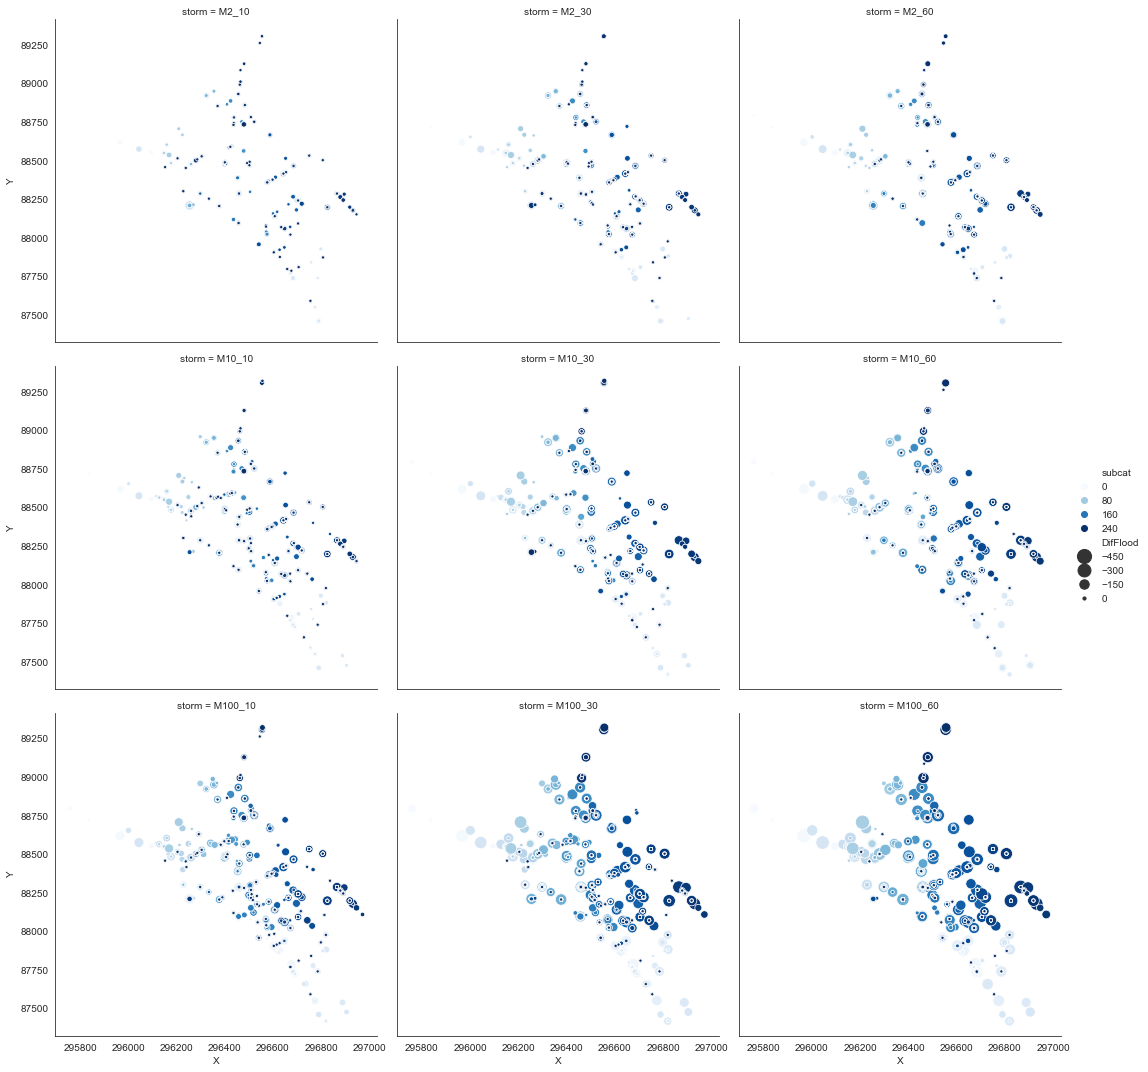

In [403]:
sns.relplot(x='X',y='Y', size='DifFlood',hue='subcat',col='storm',palette='Blues',col_wrap=3,sizes=(200, 10),data=all_info[all_info['DifFlood']<0])

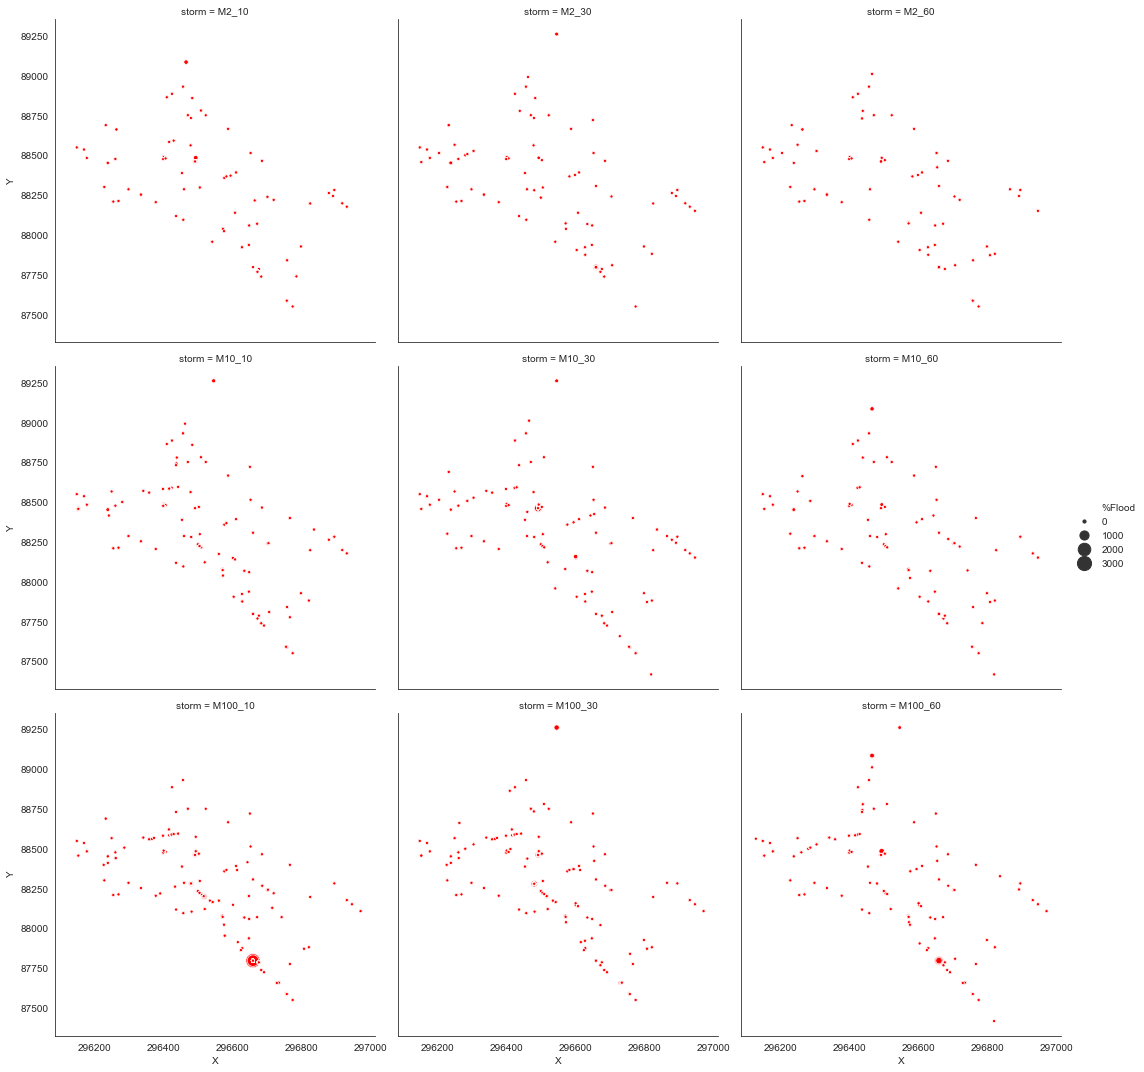

In [401]:
sns.relplot(x='X',y='Y', size='%Flood',col='storm', color='Red',col_wrap=3,sizes=(10, 200),data=all_info[all_info['%Flood']>0])

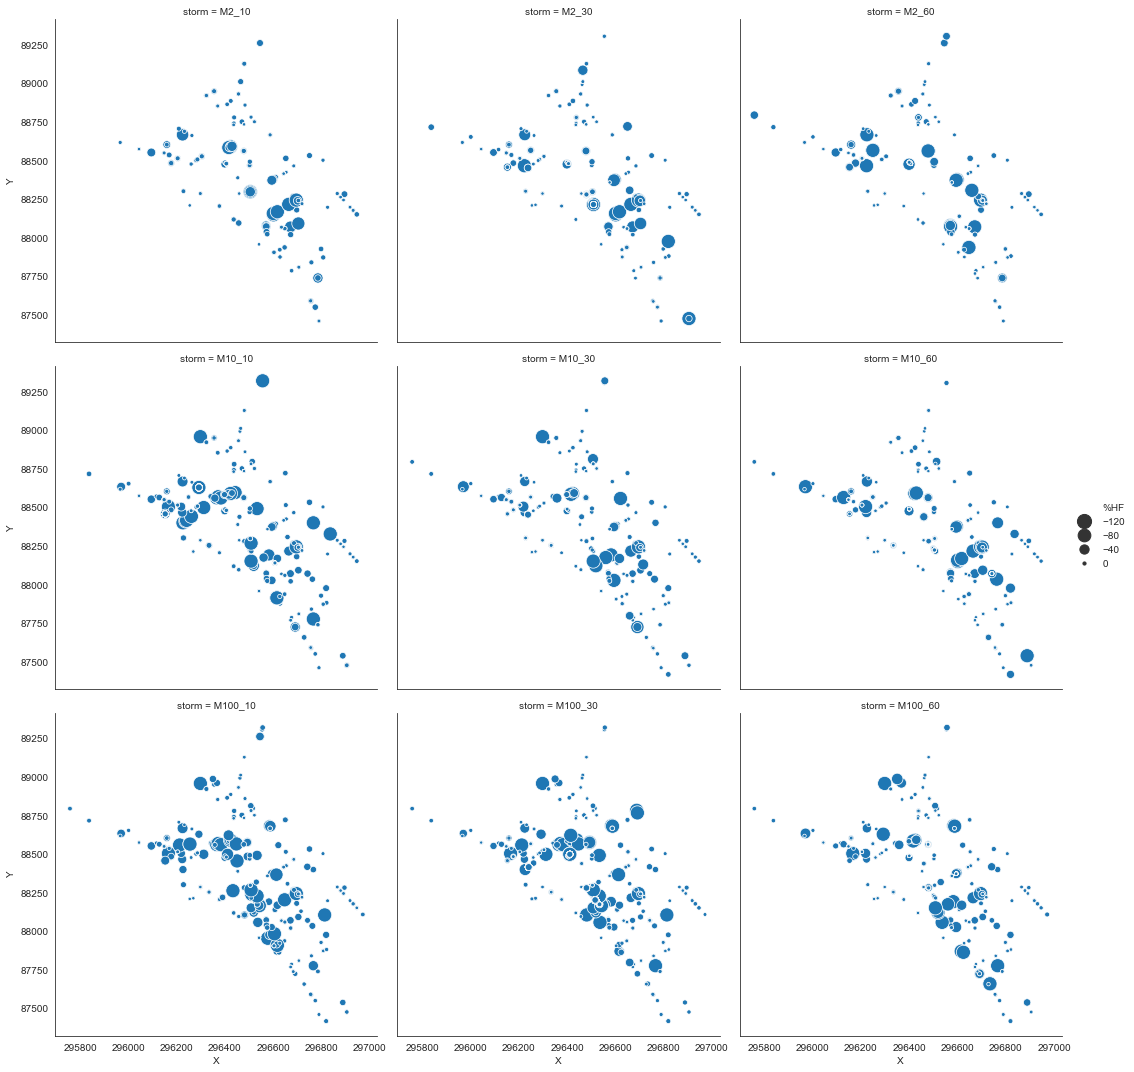

In [396]:
sns.relplot(x='X',y='Y', size='%HF',col='storm', palette='Blues',col_wrap=3,sizes=(200, 10),data=all_info[all_info['%HF']<0])

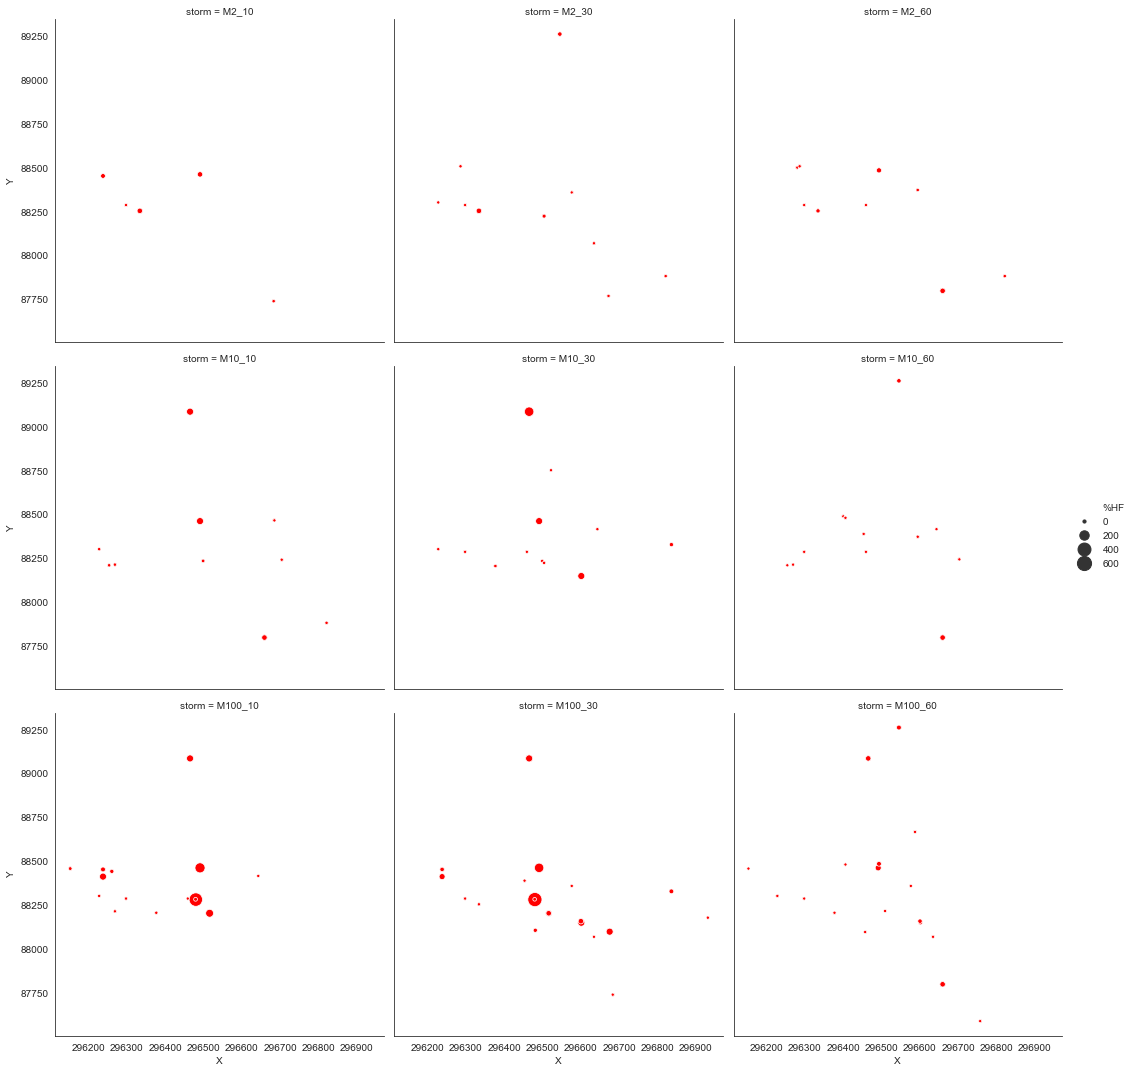

In [399]:
sns.relplot(x='X',y='Y', size='%HF',col='storm', color='Red',col_wrap=3,sizes=(10,200),data=all_info[all_info['%HF']>0])

In [404]:
from sklearn import cluster
from sklearn.preprocessing import scale

In [405]:
km5 = cluster.KMeans(n_clusters=5)

In [407]:
km5cls = km5.fit(all_info[['%Flood','dist_norm']].values)

[(-20.0, 20.0),
 Text(0, 0.5, '%FVC'),
 (0.0, 2.0),
 Text(0.5, 0, 'Normalized Distance')]

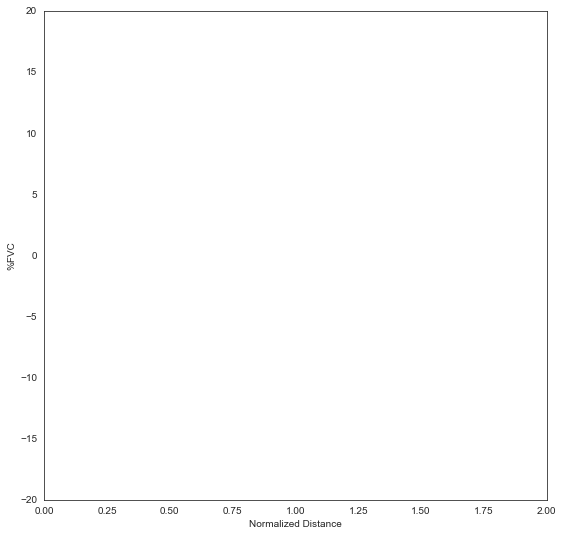

In [412]:
fig,ax = plt.subplots(figsize=(9,9))

sns.kdeplot(all_info[all_info['Flood']>15]['X'],all_info[all_info['Flood']>15]['Y'],cut=2, shade=True, ax=ax)

ax.set(xlim=(0,2.0),ylim=(-20,20),xlabel='Normalized Distance', ylabel='%FVC')